# I) Import the necessary packages

In [2]:
# =====================
# 1. Standard Libraries
# =====================
import os
import math
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
from itertools import combinations

# =====================
# 2. Data Manipulation
# =====================
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import f_oneway

# =====================
# 3. Data Visualization
# =====================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import seaborn as sns
import scikitplot as skplt
from sklearn.metrics import ConfusionMatrixDisplay

# =====================
# 4. Preprocessing & Pipeline
# =====================
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# =====================
# 5. Clustering & Dimensionality Reduction
# =====================
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import davies_bouldin_score

# =====================
# 6. Model Persistence
# =====================
import joblib

# II) Get the data

## 1) Load and merge CSV files

In [5]:
# Load Olist datasets
customers = pd.read_csv('olist_customers_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')
items = pd.read_csv('olist_order_items_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')
reviews = pd.read_csv('olist_order_reviews_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
translation = pd.read_csv('product_category_name_translation.csv')

tables = {
    'customers': customers,
    'geolocation': geolocation,
    'items': items,
    'payments': payments,
    'reviews': reviews,
    'orders': orders,
    'products': products,
    'sellers': sellers,
    'translation': translation
}

def show_column_names(tables_dict):
    """Display column information (data types, non-null counts) for each table."""
    for name, df in tables_dict.items():
        print(f"\n{name.upper()}:")
        print(df.info())

def process_data(customers, orders, items, products, translation, sellers, payments, reviews):
    """
    Merge all Olist tables into one unified DataFrame.
    Includes merging logic, voucher handling, and order aggregation.
    """

    # Step 1: Merge orders with customer info
    df = pd.merge(orders, customers, on='customer_id', how='left')

    # Step 2: Merge with order items
    df = pd.merge(df, items, on='order_id', how='left')

    # Step 3: Merge with product categories
    df = pd.merge(df, products[['product_id', 'product_category_name']], on='product_id', how='left')

    # Step 4: Translate product category to English
    df = pd.merge(df, translation, on='product_category_name', how='left')

    # Step 5: Merge with seller info
    df = pd.merge(df, sellers, on='seller_id', how='left')

    # Step 6: Add payment type info
    df = pd.merge(df, payments[['order_id', 'payment_type']], on='order_id', how='left')

    # Step 7: Add review scores
    df = pd.merge(df, reviews[['order_id', 'review_score']], on='order_id', how='left')

    # Step 8: Select relevant columns only
    cols_to_keep = [
        'customer_id', 'customer_unique_id', 'customer_city', 'customer_state',
        'order_id', 'order_status', 'order_purchase_timestamp',
        'order_item_id', 'product_id', 'product_category_name_english',
        'price', 'freight_value',
        'seller_id', 'seller_city', 'seller_state',
        'payment_type', 'review_score'
    ]
    df = df[cols_to_keep].drop_duplicates()

    # Step 9: Create "has_voucher" flag = 1 if voucher used in any payment method of order
    df['has_voucher'] = df.groupby('order_id')['payment_type'].transform(lambda x: int('voucher' in x.values))

    # Step 10: Remove voucher rows (already marked above)
    df = df[df['payment_type'] != 'voucher']

    # Step 11: Drop order_item_id to group by order level
    df = df.drop(columns=['order_item_id'])

    # Step 12: Group by all columns except price and freight_value
    cols_to_group = df.columns.difference(['price', 'freight_value']).tolist()

    # Step 13: Aggregate price and freight_value, count number of items/orders
    df_grouped = df.groupby(cols_to_group, dropna=False).agg({
        'price': 'sum',
        'freight_value': 'sum'
    }).reset_index()

    df_grouped['num_orders'] = df.groupby(cols_to_group, dropna=False).size().values

    return df_grouped

In [6]:
show_column_names(tables)


CUSTOMERS:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None

GEOLOCATION:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city

In [7]:
df_result = process_data(customers, orders, items, products, translation, sellers, payments, reviews)
print(df_result.info())
df_result.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101761 entries, 0 to 101760
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_city                  101761 non-null  object 
 1   customer_id                    101761 non-null  object 
 2   customer_state                 101761 non-null  object 
 3   customer_unique_id             101761 non-null  object 
 4   has_voucher                    101761 non-null  int64  
 5   order_id                       101761 non-null  object 
 6   order_purchase_timestamp       101761 non-null  object 
 7   order_status                   101761 non-null  object 
 8   payment_type                   101760 non-null  object 
 9   product_category_name_english  99604 non-null   object 
 10  product_id                     101066 non-null  object 
 11  review_score                   100964 non-null  float64
 12  seller_city                   

customer_city                       customer_id customer_state  \
0   abadia dos dourados  9e01f714a2b3b8962c222cf2b74c20dc             MG   
1   abadia dos dourados  a23e3f9a2b656b23b7e52075964b42cd             MG   
2   abadia dos dourados  f11eb8f0b8b87510a93e3e1aa10b0ade             MG   
3             abadiania  576d71ddb21b21763cfedce73b902180             GO   
4                abaete  08528824266cd0720658ff01df662b6a             MG   
5                abaete  225634426cfd64638ae97bf60e190f5b             MG   
6                abaete  24d97ea7bb12a40f87d701e17017d282             MG   
7                abaete  2bf14bf7a1f0610883d264cae6bc4de6             MG   
8                abaete  3c46a6771b9833c7571cd2498f548f95             MG   
9                abaete  5371894984937a27cf40c7d20699a786             MG   
10               abaete  5e9e1ae42e02df93e9a591e86fd531a3             MG   
11               abaete  962b41ee521809e7435fdac0d93063a9             MG   
12               abaete  a3d3c38e58b9d2dfb9207cab690b6310             MG   
13               abaete  d47c8bb51df6f716e196ecd6cd5d2c09             MG   
14               abaete  e67618ef4120e6f73c343ef079dc405e             MG   
15               abaete  ff0d62f8be4c098e6306f39bc6ebded4             MG   
16           abaetetuba  305f736d2711641a06f6a9c9bd837b00             PA   
17           abaetetuba  367fd22f1e994de87cf447d29c167a1f             PA   
18           abaetetuba  3c12346ea1f05ce151ba3029c1cbf60d             PA   
19           abaetetuba  3f6cd3d8326965c0d9cc53a851559a0e             PA   

                  customer_unique_id  has_voucher  \
0   e1feae9083c4c2895ddf6dc80526a85d            0   
1   afddf43a03a9941624ed42c0b2c17280            0   
2   64ee476500a01beb94df40f97a108c50            0   
3   8d76b559181609308fcae630ea64cd61            0   
4   8f7f547488a05660770b51be707eb2a3            0   
5   ca1a0307fe782c9125fd9264c92db778            0   
6   5bd046eccd966d97c4fe06e8d75a64a7            0   
7   1605eaf5744972f09529a6ce287e9e47            0   
8   2a19a29632faf108fd680a976034fa3d            0   
9   2d69de392ffdb5def80917230154351d            0   
10  28af9604f7830ef6d1230fb575c39eb1            0   
11  8b8545eb716cbef0248f0546f3335c1c            0   
12  5a4fa4919cbf2b049e72be460a380e5b            0   
13  189af2582a09a860e7ebebaec950b0af            0   
14  a0e363eb99ec5c321d26ef6618308918            0   
15  ab26557b289641b505abd795c0913683            0   
16  adc650abc7894831caafbf528540e9ea            0   
17  9811f75e58306711797259182809ba81            0   
18  9bf9e8c962ab8bce4daf3ec7d0a59e13            0   
19  c86ac97751bb46bf642e75bf8455f199            0   

                            order_id order_purchase_timestamp order_status  \
0   50ba38c4dc467baab1ea2c8c7747934d      2018-03-02 21:32:44    delivered   
1   d99e6849f7676dade195f20c26f0eb4f      2017-09-02 22:37:17    delivered   
2   0a9a43ac5fe59c6c4bee2a8f9b9fcce8      2018-07-02 08:00:35    delivered   
3   3f1294f87d79b57f5d55ba7b80c3d94f      2018-01-28 14:21:58    delivered   
4   5525ea8ee9e6150faa9b41dfc4024552      2018-08-20 21:33:48    delivered   
5   ee2b11b5601e9de355fb771525a195ce      2017-11-20 17:08:59    delivered   
6   74bdc516d1c6a8e16cd1a546ea067c26      2018-03-27 11:00:09    delivered   
7   902864b6c62e404e8a57ca48c90657e8      2017-07-31 17:48:16    delivered   
8   33d425553bc88c255ddeb68ab933167e      2018-03-05 12:47:02    delivered   
9   6c12feac9a308e1382d9b19cca7f20b2      2017-05-05 13:48:37    delivered   
10  807756ebd577f025334944b87da7dbc3      2017-11-23 16:47:19    delivered   
11  eb2eb20abe0258707c152cc393dfcb16      2017-07-15 10:28:32    delivered   
12  2eecb0d85f281280f79fa00f9cec1a95      2017-02-17 17:21:55    delivered   
13  3f6833af28b1e2885b8df4899e9aa8d1      2017-08-31 17:25:03    delivered   
14  1c2f555edfc445e72867c301b68ac512      2018-06-28 16:12:59    delivered   
15  4ccc4e96e0fa5c35efbf9bf836ebef72      2018-06-0

## 2) Rename features

In [9]:
df_result.rename(columns={
    'customer_id': 'Customer ID',
    'customer_unique_id': 'Customer Unique ID',
    'customer_city': 'Customer City',
    'customer_state': 'Customer State',
    'order_id': 'Order ID',
    'order_purchase_timestamp': 'Purchase Time',
    'order_status': 'Order Status',
    'payment_type': 'Payment Method',
    'has_voucher': 'Used Voucher',
    'product_id': 'Product ID',
    'product_category_name_english': 'Product Category',
    'price': 'Price',
    'freight_value': 'Shipping Fee',
    'review_score': 'Review Score',
    'seller_id': 'Seller ID',
    'seller_city': 'Seller City',
    'seller_state': 'Seller State',
    'num_orders': 'Num Items'
}, inplace=True)

ordered_cols = [
    'Order ID', 'Purchase Time', 'Order Status',
    'Customer ID', 'Customer Unique ID', 'Customer City', 'Customer State',
    'Product ID', 'Product Category', 'Num Items',
    'Price', 'Shipping Fee',
    'Seller ID', 'Seller City', 'Seller State',
    'Payment Method', 'Used Voucher', 'Review Score'
]

df_result = df_result[ordered_cols]

df_result['Purchase Time'] = pd.to_datetime(df_result['Purchase Time'], errors='coerce')

df_result['Used Voucher'] = df_result['Used Voucher'].map({1: 'Yes', 0: 'No'})

# III) Explore the Data

## 1) Quick glance at the data

In [12]:
full_data = df_result.copy()

In [13]:
full_data['Day'] = full_data['Purchase Time'].dt.day
full_data['Month'] = full_data['Purchase Time'].dt.month
full_data['Year'] = full_data['Purchase Time'].dt.year

In [14]:
full_data.head()

Order ID       Purchase Time Order Status  \
0  50ba38c4dc467baab1ea2c8c7747934d 2018-03-02 21:32:44    delivered   
1  d99e6849f7676dade195f20c26f0eb4f 2017-09-02 22:37:17    delivered   
2  0a9a43ac5fe59c6c4bee2a8f9b9fcce8 2018-07-02 08:00:35    delivered   
3  3f1294f87d79b57f5d55ba7b80c3d94f 2018-01-28 14:21:58    delivered   
4  5525ea8ee9e6150faa9b41dfc4024552 2018-08-20 21:33:48    delivered   

                        Customer ID                Customer Unique ID  \
0  9e01f714a2b3b8962c222cf2b74c20dc  e1feae9083c4c2895ddf6dc80526a85d   
1  a23e3f9a2b656b23b7e52075964b42cd  afddf43a03a9941624ed42c0b2c17280   
2  f11eb8f0b8b87510a93e3e1aa10b0ade  64ee476500a01beb94df40f97a108c50   
3  576d71ddb21b21763cfedce73b902180  8d76b559181609308fcae630ea64cd61   
4  08528824266cd0720658ff01df662b6a  8f7f547488a05660770b51be707eb2a3   

         Customer City Customer State                        Product ID  \
0  abadia dos dourados             MG  418d480693f2f01e9cf4568db0346d28   
1  abadia dos dourados             MG  1081ae52311daac87fb54ba8ce4670ac   
2  abadia dos dourados             MG  c1aabbb6f4caec9f5bf7cd80519d6cc0   
3            abadiania             GO  0a9b9a871ffaec6c0198334558a6c6a1   
4               abaete             MG  3354a4e684f5e7199f9407db70ccd92b   

         Product Category  Num Items  ...  Shipping Fee  \
0              cool_stuff          1  ...         20.63   
1          sports_leisure          1  ...         15.59   
2  books_general_interest          1  ...         18.38   
3        small_appliances          1  ...         75.53   
4              cool_stuff          1  ...         23.40   

                          Seller ID     Seller City Seller State  \
0  12b9676b00f60f3b700e83af21824c0e      montenegro           RS   
1  4371b634e0efc0e22b09b52907d9d469       sao paulo           SP   
2  579891617139df7d8671d373f0669622  rio de janeiro           RJ   
3  f9244d45189d3a3605499abddeade7d5       sao paulo           SP   
4  7a67c85e85bb2ce8582c35f2203ad736       sao paulo           SP   

  Payment Method Used Voucher Review Score  Day  Month  Year  
0    credit_card           No          5.0    2      3  2018  
1    credit_card           No          5.0    2      9  2017  
2         boleto           No          5.0    2      7  2018  
3    credit_card           No          4.0   28      1  2018  
4    credit_card           No          5.0   20      8  2018  

[5 rows x 21 columns]

In [15]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101761 entries, 0 to 101760
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Order ID            101761 non-null  object        
 1   Purchase Time       101761 non-null  datetime64[ns]
 2   Order Status        101761 non-null  object        
 3   Customer ID         101761 non-null  object        
 4   Customer Unique ID  101761 non-null  object        
 5   Customer City       101761 non-null  object        
 6   Customer State      101761 non-null  object        
 7   Product ID          101066 non-null  object        
 8   Product Category    99604 non-null   object        
 9   Num Items           101761 non-null  int64         
 10  Price               101761 non-null  float64       
 11  Shipping Fee        101761 non-null  float64       
 12  Seller ID           101066 non-null  object        
 13  Seller City         101066 no

In [16]:
full_data.describe()

Purchase Time      Num Items          Price  \
count                         101761  101761.000000  101761.000000   
mean   2017-12-31 08:21:15.410520832       1.100107     132.476854   
min              2016-09-04 21:15:19       1.000000       0.000000   
25%              2017-09-12 17:22:15       1.000000      44.900000   
50%              2018-01-18 18:55:18       1.000000      80.380000   
75%              2018-05-04 15:44:40       1.000000     147.900000   
max              2018-09-03 14:14:25      20.000000   13440.000000   
std                              NaN       0.458296     205.667467   

        Shipping Fee   Review Score            Day          Month  \
count  101761.000000  100964.000000  101761.000000  101761.000000   
mean       21.886266       4.060160      15.515826       6.038276   
min         0.000000       1.000000       1.000000       1.000000   
25%        13.460000       4.000000       8.000000       3.000000   
50%        16.810000       5.000000      15.000000       6.000000   
75%        23.230000       5.000000      23.000000       8.000000   
max      1794.960000       5.000000      31.000000      12.000000   
std        20.548591       1.367182       8.668471       3.233895   

                Year  
count  101761.000000  
mean     2017.539264  
min      2016.000000  
25%      2017.000000  
50%      2018.000000  
75%      2018.000000  
max      2018.000000  
std         0.505175

<Axes: >

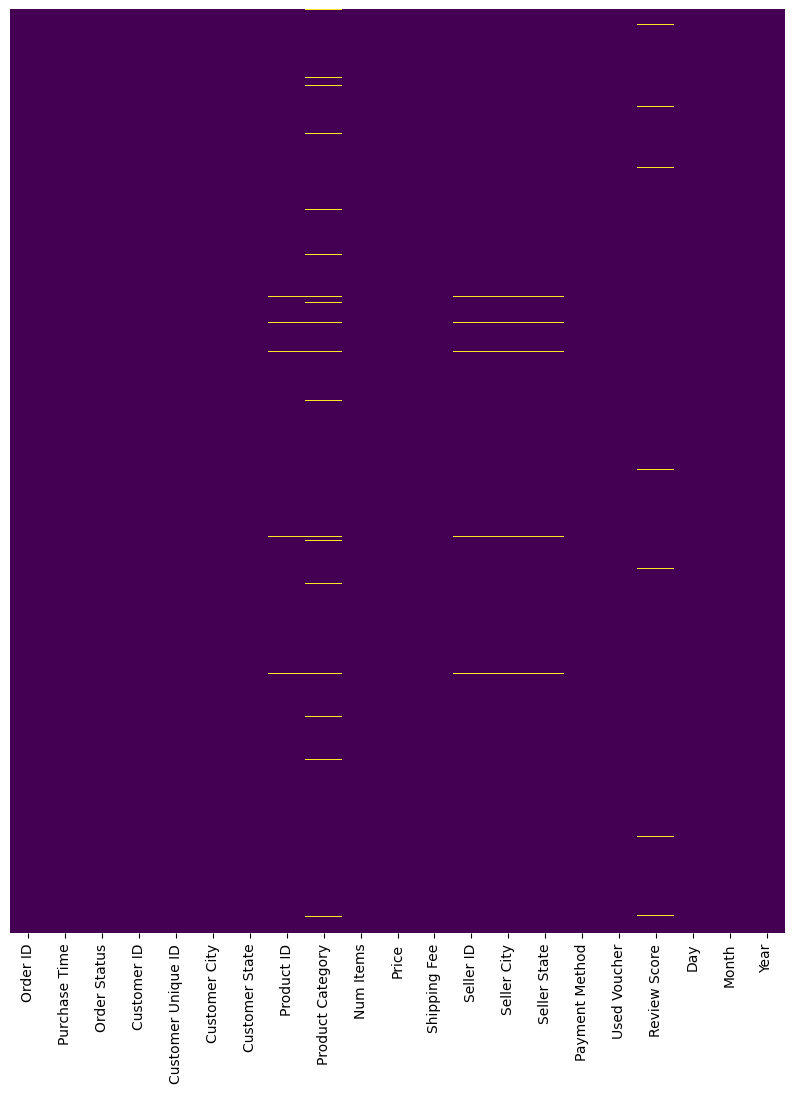

In [17]:
plt.figure(figsize=(10,12))
sns.heatmap(full_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [18]:
full_data.nunique()

Order ID              97820
Purchase Time         97268
Order Status              8
Customer ID           97820
Customer Unique ID    94637
Customer City          4110
Customer State           27
Product ID            32576
Product Category         71
Num Items                16
Price                  6946
Shipping Fee           7938
Seller ID              3085
Seller City             609
Seller State             23
Payment Method            4
Used Voucher              2
Review Score              5
Day                      31
Month                    12
Year                      3
dtype: int64

In [19]:
full_data.isnull().sum()

Order ID                 0
Purchase Time            0
Order Status             0
Customer ID              0
Customer Unique ID       0
Customer City            0
Customer State           0
Product ID             695
Product Category      2157
Num Items                0
Price                    0
Shipping Fee             0
Seller ID              695
Seller City            695
Seller State           695
Payment Method           1
Used Voucher             0
Review Score           797
Day                      0
Month                    0
Year                     0
dtype: int64

In [20]:
full_data = full_data.dropna()

## 2) Functions used to explore each feature

In [22]:
def get_value_counts_summary(df, feature):
    """
    Returns a table showing the count and percentage frequency 
    of each unique value in the given feature.
    """
    counts = df[feature].value_counts(dropna=False)
    freqs = df[feature].value_counts(normalize=True, dropna=False) * 100
    summary = pd.concat([counts, freqs], axis=1)
    summary.columns = ['Count', 'Frequency (%)']
    return summary


def summarize_feature(df, feature, show=True):
    """
    Display or return a summary of a single feature, including:
    - Data type
    - Descriptive statistics
    - Missing value ratio
    - Count & frequency table
    """
    summary = {}

    # Data type
    dtype = df[feature].dtype
    summary['Data Type'] = dtype

    # Descriptive statistics
    if pd.api.types.is_numeric_dtype(dtype):
        desc = df[feature].describe()
    else:
        desc = df[feature].describe(include='all')
    summary['Description'] = desc

    # Missing values
    null_count = df[feature].isna().sum()
    total_count = len(df)
    null_pct = (null_count / total_count) * 100
    summary['Missing Count'] = null_count
    summary['Missing (%)'] = null_pct

    # Value counts and frequency
    value_summary = get_value_counts_summary(df, feature)
    summary['Value Counts'] = value_summary

    # Display the result
    if show:
        print(f"{'='*60}")
        print(f"Feature: {feature}")
        print(f"{'-'*60}")
        print("Data Type:", dtype)
        print("Missing Values: {} ({:.2f}%)".format(null_count, null_pct))
        print(f"{'-'*60}")
        print("Description:")
        print(desc)
        print(f"{'-'*60}")
        print("Value Counts (All):")
        print(value_summary)
        print(f"{'='*60}\n")
    else:
        return summary


In [23]:
def create_pie_plot(df, feature, figsize=(8, 8)):
    """
    Draws a pie chart for the given feature.
    Automatically displays only the top 10 categories if there are too many.
    Modern look: light background, pastel colors, legend on the right.
    """
    # Calculate counts and frequencies
    counts = df[feature].value_counts(dropna=False)
    freqs = df[feature].value_counts(normalize=True, dropna=False) * 100

    # Limit to top 10 if necessary
    if len(counts) > 10:
        counts = counts.head(10)
        freqs = freqs.head(10)
        print(f"Feature {feature} has more than 10 categories. Displaying top 10 most frequent.")

    labels = counts.index
    sizes = freqs.values
    legend_labels = [f"{str(label)} ({counts.loc[label]})" for label in labels]

    # Light gray-white background
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor('#f7f7f7')

    # List of 10 distinct pastel colors
    colors = [
        "#FFB3BA", "#FFDFBA", "#FFFFBA", "#BAFFC9", "#BAE1FF",
        "#D5BAFF", "#FFC4E1", "#C4FFFF", "#E6FFBA", "#FFBACD"
    ][:len(labels)]

    # Draw pie chart
    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=None,
        autopct='%1.2f%%',
        startangle=90,
        colors=colors,
        wedgeprops={'edgecolor': 'black'},
        textprops={'fontsize': 10}
    )

    ax.set_title(f"Pie Chart of {feature}", fontsize=14)
    ax.axis('equal')

    # Legend on the right
    ax.legend(wedges, legend_labels, title="Labels", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9)

    plt.show()


In [24]:
def create_bar_plot(df, feature, figsize=(10, 6)):
    """
    Draws a bar chart for a given feature.
    Uses a light background and custom pastel colors for bars.
    If there are more than 10 categories, only the top 10 are displayed.
    """
    # Calculate counts and frequencies
    value_counts = df[feature].value_counts(dropna=False)
    value_freq = df[feature].value_counts(normalize=True, dropna=False) * 100

    if len(value_counts) > 10:
        print(f"Feature {feature} has more than 10 categories. Displaying top 10 most frequent.")
        value_counts = value_counts.head(10)
        value_freq = value_freq.head(10)

    labels = value_counts.index.astype(str).tolist()
    counts = value_counts.values
    freqs = value_freq.values

    plot_df = pd.DataFrame({
        feature: labels,
        'Count': counts,
        'Frequency (%)': freqs
    })

    # Custom pastel colors
    colors = [
        "#FFB3BA", "#FFDFBA", "#FFFFBA", "#BAFFC9", "#BAE1FF",
        "#D5BAFF", "#FFC4E1", "#C4FFFF", "#E6FFBA", "#FFBACD"
    ][:len(labels)]

    # Light background style
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=figsize, facecolor='#f5f5f5')
    ax.set_facecolor('#f5f5f5')

    # Draw the bar plot
    bars = sns.barplot(
        x=feature,
        y='Count',
        data=plot_df,
        palette=colors,
        edgecolor='black',
        ax=ax,
        width=0.6
    )

    # Annotate bars with count and percentage
    for i, row in plot_df.iterrows():
        ax.text(i, row['Count'] + max(counts) * 0.01,
                f"{row['Count']} ({row['Frequency (%)']:.1f}%)",
                ha='center', va='bottom', fontsize=10, color='black')

    # Customize axes and title
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    ax.set_title(f"Bar Chart of {feature}", fontsize=14, weight='bold')
    ax.set_xticklabels(labels, rotation=45, ha='right')

    plt.tight_layout()

    plt.show()


In [25]:
def create_box_plot(df, feature, figsize=(10, 6), box_color="#FFB3BA", clip_outliers=True, clip_percentile=99):
    """
    Draws two side-by-side boxplots:
    - Original boxplot (full data including outliers)
    - Clipped boxplot (removes extreme outliers above the given percentile)
    """
    sns.set(style="whitegrid")

    data_full = df[feature].dropna()
    clip_value = np.percentile(data_full, clip_percentile)
    data_clipped = data_full[data_full <= clip_value]

    fig, axes = plt.subplots(1, 2, figsize=figsize, facecolor="#f5f5f5")
    for ax in axes:
        ax.set_facecolor("#f5f5f5")

    # Original boxplot with outliers
    sns.boxplot(y=data_full, color=box_color, ax=axes[0], width=0.5, fliersize=4)
    axes[0].set_title(f"{feature} - Full Data (with outliers)", fontsize=13, weight='bold')
    axes[0].set_ylabel('')
    axes[0].grid(True, axis='y', linestyle='--', alpha=0.7)

    max_val_full = data_full.max()
    if max_val_full >= 1000:
        axes[0].get_yaxis().set_major_formatter(
            ticker.FuncFormatter(lambda x, _: format(int(x), ',')))
    elif max_val_full < 10:
        axes[0].get_yaxis().set_major_formatter(
            ticker.FuncFormatter(lambda x, _: f"{x:.2f}"))

    # Clipped boxplot (removing top outliers)
    sns.boxplot(y=data_clipped, color=box_color, ax=axes[1], width=0.5, fliersize=4)
    axes[1].set_title(f"{feature} - Clipped at P{clip_percentile}", fontsize=13, weight='bold')
    axes[1].set_ylabel('')
    axes[1].grid(True, axis='y', linestyle='--', alpha=0.7)

    max_val_clip = data_clipped.max()
    if max_val_clip >= 1000:
        axes[1].get_yaxis().set_major_formatter(
            ticker.FuncFormatter(lambda x, _: format(int(x), ',')))
    elif max_val_clip < 10:
        axes[1].get_yaxis().set_major_formatter(
            ticker.FuncFormatter(lambda x, _: f"{x:.2f}"))

    plt.tight_layout()
    plt.show()


In [26]:
def compare_hist_with_clip(df, feature, bins=50, kde=True, clip_percentile=99, hist_color="#FFB3BA"):
    """
    Displays two histograms:
    - Original (including outliers)
    - Clipped version (removes outliers above the given percentile)
    """
    sns.set(style="whitegrid")

    data_full = df[feature].dropna()
    clip_value = np.percentile(data_full, clip_percentile)
    data_clipped = data_full[data_full <= clip_value]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), facecolor="#f5f5f5")
    for ax in axes:
        ax.set_facecolor("#f5f5f5")

    # Original distribution
    sns.histplot(data_full, bins=bins, kde=kde, color=hist_color, ax=axes[0])
    axes[0].set_title(f'{feature} - Full Distribution', fontsize=12, weight='bold')
    axes[0].set_xlabel(feature)
    axes[0].set_ylabel("Frequency")
    if data_full.max() >= 1000:
        axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: format(int(x), ',')))

    # Clipped distribution (above PXX removed)
    sns.histplot(data_clipped, bins=bins, kde=kde, color=hist_color, ax=axes[1])
    axes[1].set_title(f'{feature} - Clipped at P{clip_percentile}', fontsize=12, weight='bold')
    axes[1].set_xlabel(feature)
    axes[1].set_ylabel("Frequency")
    if data_clipped.max() >= 1000:
        axes[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: format(int(x), ',')))

    plt.tight_layout()
    plt.show()


In [27]:
def analyze_numerical_feature(df, feature):
    print(f"===== Summary of feature: {feature} =====\n")
    summarize_feature(df, feature)
    
    print("\n===== Box Plot =====\n")
    create_box_plot(df, feature)
    
    print("\n===== Histogram Comparison (Full vs Clipped) =====\n")
    compare_hist_with_clip(df, feature)

def analyze_categorical_feature(df, feature):
    print(f"===== Summary of feature: {feature} =====\n")
    summarize_feature(df, feature)
    
    print("\n===== Pie Chart =====\n")
    create_pie_plot(df, feature)
    
    print("\n===== Bar Chart =====\n")
    create_bar_plot(df, feature)

In [28]:
def process_datetime_feature(df, feature, hist_color="#FFB3BA"):  
    """
    Converts a datetime feature and extracts components (Day, Month, Quarter, Year).
    Then summarizes and visualizes each component using count plots.
    """
    df_copy = df.copy()

    # Convert to datetime
    df_copy[feature] = pd.to_datetime(df_copy[feature], errors='coerce')

    # Create integer-based categorical columns (supporting NaN)
    df_copy[f"{feature} Day"] = df_copy[feature].dt.day.astype(pd.Int64Dtype()).astype("category")
    df_copy[f"{feature} Month"] = df_copy[feature].dt.month.astype(pd.Int64Dtype()).astype("category")
    df_copy[f"{feature} Quarter"] = df_copy[feature].dt.quarter.astype(pd.Int64Dtype()).astype("category")
    df_copy[f"{feature} Year"] = df_copy[feature].dt.year.astype(pd.Int64Dtype()).astype("category")

    new_features = [
        f"{feature} Day", f"{feature} Month", f"{feature} Quarter", f"{feature} Year"
    ]

    sns.set(style="whitegrid")

    for feat in new_features:
        print(f"===== Summary of feature: {feat} =====\n")
        summarize_feature(df_copy, feat)

        plt.figure(figsize=(16, 6), facecolor="#f5f5f5")
        ax = sns.countplot(x=feat, data=df_copy, color=hist_color)
        ax.set_facecolor("#f5f5f5")
        ax.set_title(f'Frequency of {feat}', fontsize=12, weight='bold')
        ax.set_xlabel(feat)
        ax.set_ylabel('Count')
        plt.tight_layout()
        plt.show()


## 3) Univariate analysis

### 3.1) Order Status

===== Summary of feature: Order Status =====

Feature: Order Status
------------------------------------------------------------
Data Type: object
Missing Values: 0 (0.00%)
------------------------------------------------------------
Description:
count         98834
unique            7
top       delivered
freq          96793
Name: Order Status, dtype: object
------------------------------------------------------------
Value Counts (All):
              Count  Frequency (%)
Order Status                      
delivered     96793      97.934921
shipped        1009       1.020904
canceled        429       0.434061
invoiced        312       0.315681
processing      282       0.285327
unavailable       7       0.007083
approved          2       0.002024


===== Pie Chart =====



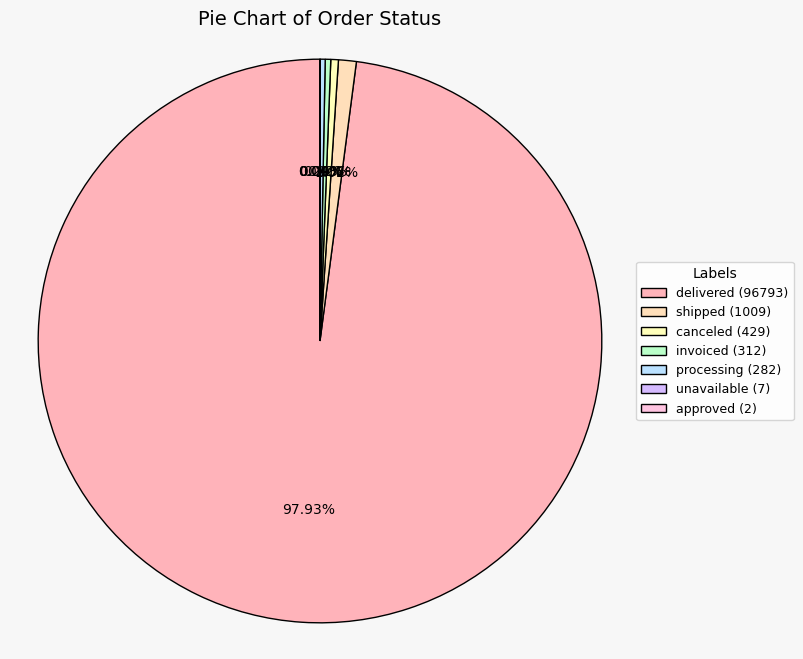


===== Bar Chart =====



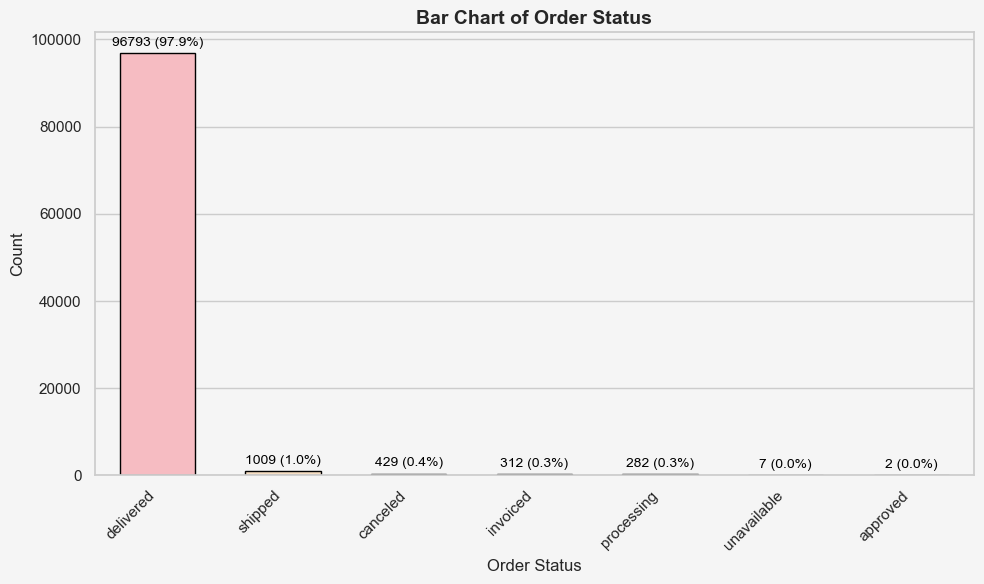

In [31]:
analyze_categorical_feature(full_data, 'Order Status')

- The `Order Status` feature has **7 unique categories** and no missing values.
- **Delivered** orders dominate the dataset, accounting for **~97.9%** of all entries.
- Other statuses like `shipped`, `canceled`, and `invoiced` occur much less frequently, with some statuses (`approved`, `unavailable`) being extremely rare.
- This strong class imbalance suggests that most transactions are successfully completed, which may affect classification models if used as a target or feature.

### 3.2) Customer City

===== Summary of feature: Customer City =====

Feature: Customer City
------------------------------------------------------------
Data Type: object
Missing Values: 0 (0.00%)
------------------------------------------------------------
Description:
count         98834
unique         4084
top       sao paulo
freq          15481
Name: Customer City, dtype: object
------------------------------------------------------------
Value Counts (All):
                     Count  Frequency (%)
Customer City                            
sao paulo            15481      15.663638
rio de janeiro        6760       6.839752
belo horizonte        2762       2.794585
brasilia              2140       2.165247
curitiba              1513       1.530850
...                    ...            ...
lutecia                  1       0.001012
luizlandia do oeste      1       0.001012
luiz alves               1       0.001012
luis correia             1       0.001012
zortea                   1       0.001012

[4084 ro

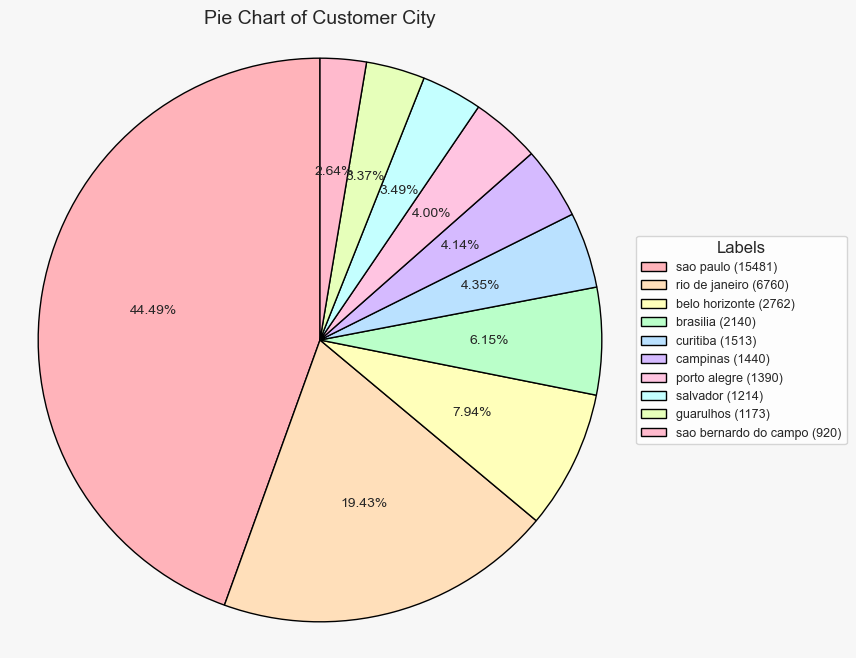


===== Bar Chart =====

Feature Customer City has more than 10 categories. Displaying top 10 most frequent.


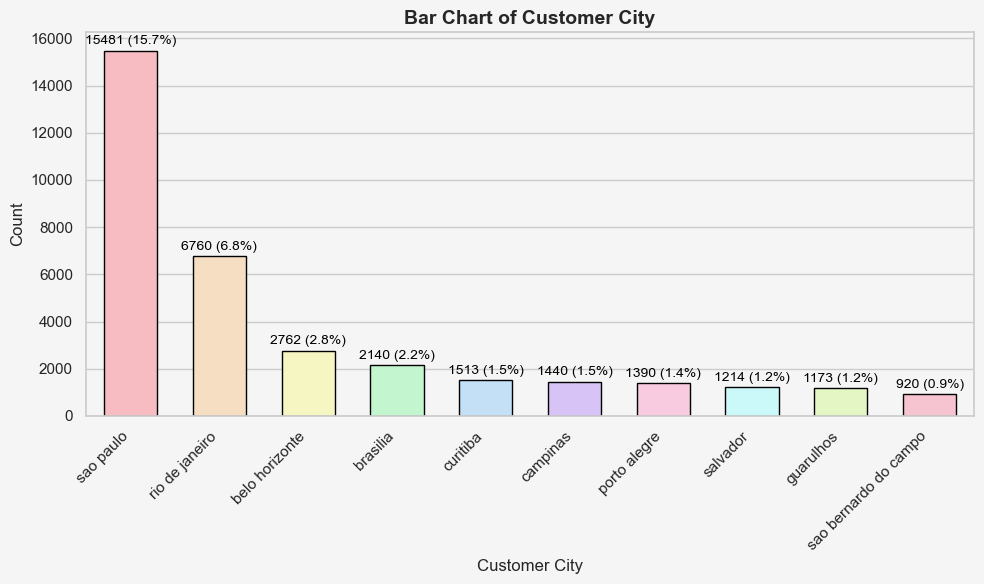

In [34]:
analyze_categorical_feature(full_data, 'Customer City')

- The `Customer City` feature contains **4,084 unique cities**, indicating a highly diverse geographic spread.
- The dataset is **heavily skewed**, with **São Paulo alone accounting for ~15.7%** of all orders.
- A long tail of cities (many with only a single order) suggests sparse distribution outside major urban areas.
- This geographic imbalance highlights concentration in urban hubs, which may influence delivery logistics and customer behavior patterns.

### 3.3) Customer State

===== Summary of feature: Customer State =====

Feature: Customer State
------------------------------------------------------------
Data Type: object
Missing Values: 0 (0.00%)
------------------------------------------------------------
Description:
count     98834
unique       27
top          SP
freq      41586
Name: Customer State, dtype: object
------------------------------------------------------------
Value Counts (All):
                Count  Frequency (%)
Customer State                      
SP              41586      42.076613
RJ              12679      12.828581
MG              11592      11.728757
RS               5479       5.543639
PR               4988       5.046846
SC               3607       3.649554
BA               3333       3.372321
DF               2148       2.173341
ES               2016       2.039784
GO               2003       2.026631
PE               1624       1.643159
CE               1319       1.334561
PA                954       0.965255
MT           

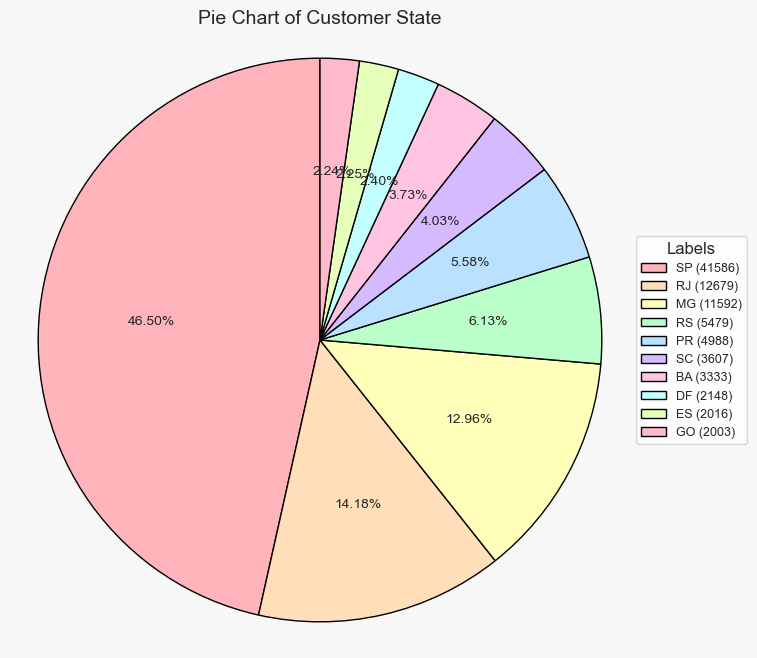


===== Bar Chart =====

Feature Customer State has more than 10 categories. Displaying top 10 most frequent.


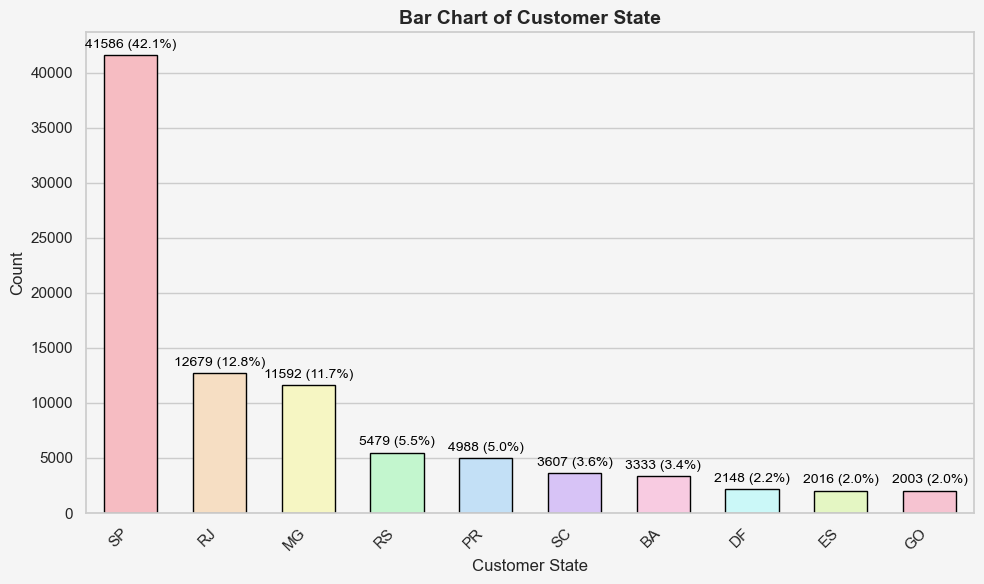

In [37]:
analyze_categorical_feature(full_data, 'Customer State')


- The `Customer State` feature includes **27 unique states**, with **no missing values**.
- **São Paulo (SP)** dominates with over **42% of all orders**, followed by **Rio de Janeiro (RJ)** and **Minas Gerais (MG)**.
- The distribution is highly skewed toward a few southeastern states, indicating a regional concentration of e-commerce activity.
- Several northern and northeastern states contribute marginally, reflecting disparities in customer reach or market penetraion.


### 3.4) Product Category

===== Summary of feature: Product Category =====

Feature: Product Category
------------------------------------------------------------
Data Type: object
Missing Values: 0 (0.00%)
------------------------------------------------------------
Description:
count              98834
unique                71
top       bed_bath_table
freq                9940
Name: Product Category, dtype: object
------------------------------------------------------------
Value Counts (All):
                           Count  Frequency (%)
Product Category                               
bed_bath_table              9940      10.057268
health_beauty               8860       8.964526
sports_leisure              7706       7.796912
computers_accessories       6779       6.858976
furniture_decor             6635       6.713277
...                          ...            ...
home_comfort_2                22       0.022260
cds_dvds_musicals             12       0.012142
la_cuisine                    12       0.01214

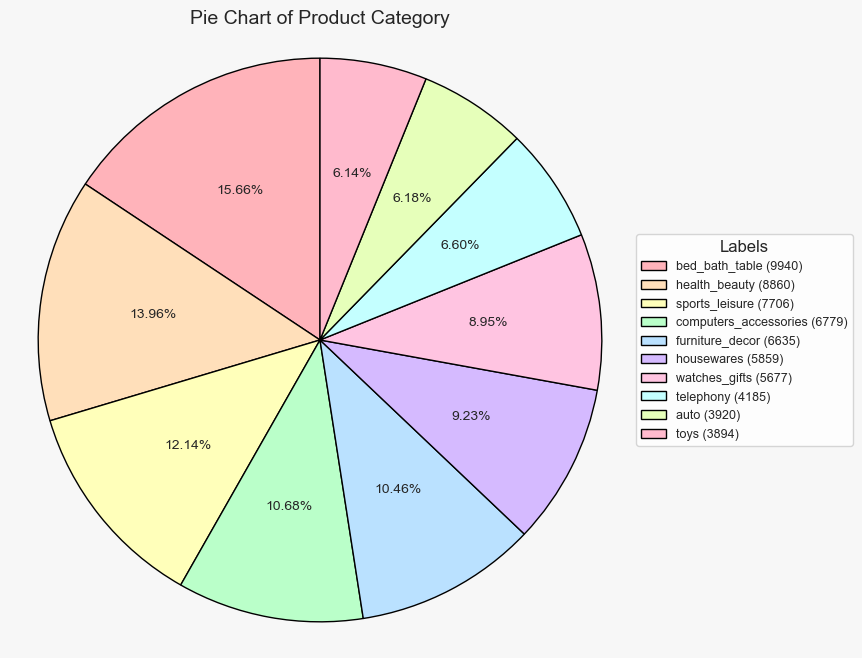


===== Bar Chart =====

Feature Product Category has more than 10 categories. Displaying top 10 most frequent.


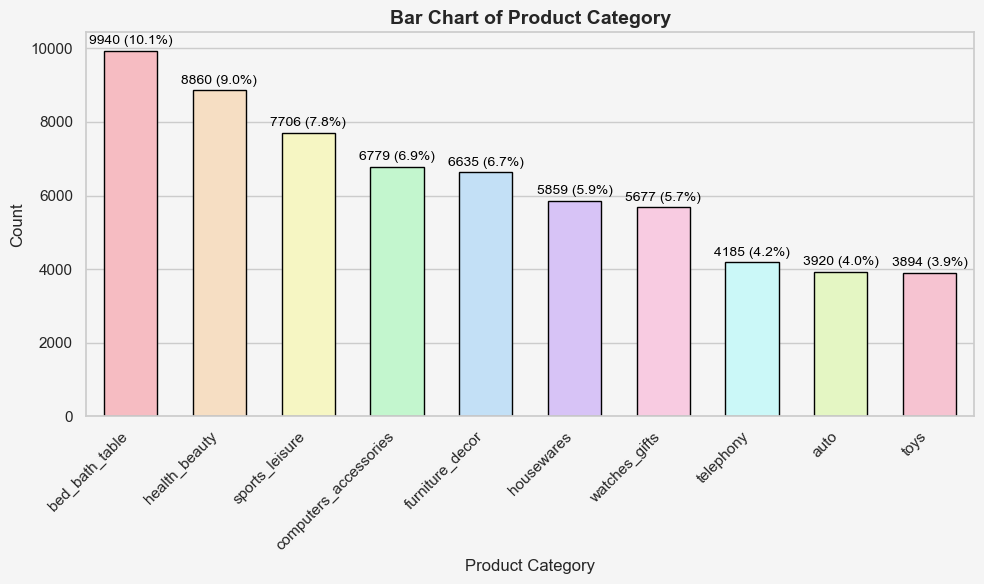

In [40]:
analyze_categorical_feature(full_data, 'Product Category')

- The `Product Category` feature has **71 unique categories** and no missing values.
- The most common category is **bed_bath_table**, making up **~10.1%** of all products, followed closely by health and leisure-related items.
- The distribution is **long-tailed**, with many niche categories having very low representation (some fewer than 10 orders).
- This suggests a diverse product range with a strong concentration in a few high-demand categories and significant fragmentation across others.

### 3.5) Seller City

===== Summary of feature: Seller City =====

Feature: Seller City
------------------------------------------------------------
Data Type: object
Missing Values: 0 (0.00%)
------------------------------------------------------------
Description:
count         98834
unique          602
top       sao paulo
freq          24435
Name: Seller City, dtype: object
------------------------------------------------------------
Value Counts (All):
                Count  Frequency (%)
Seller City                         
sao paulo       24435      24.723273
ibitinga         6964       7.046158
curitiba         2713       2.745007
santo andre      2667       2.698464
belo horizonte   2310       2.337252
...               ...            ...
pitangueiras        1       0.001012
sbc                 1       0.001012
santa cecilia       1       0.001012
santa catarina      1       0.001012
ronda alta          1       0.001012

[602 rows x 2 columns]


===== Pie Chart =====

Feature Seller City has more th

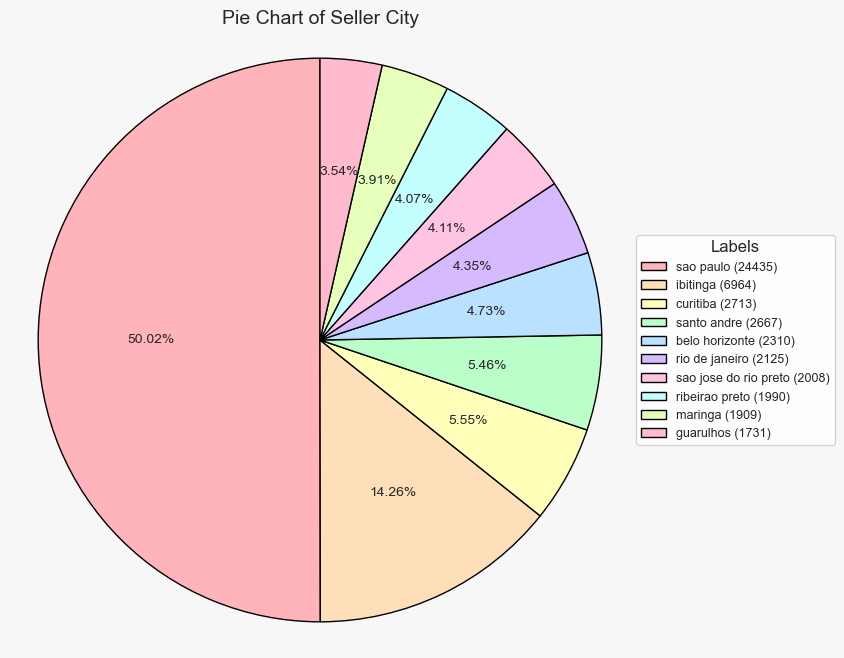


===== Bar Chart =====

Feature Seller City has more than 10 categories. Displaying top 10 most frequent.


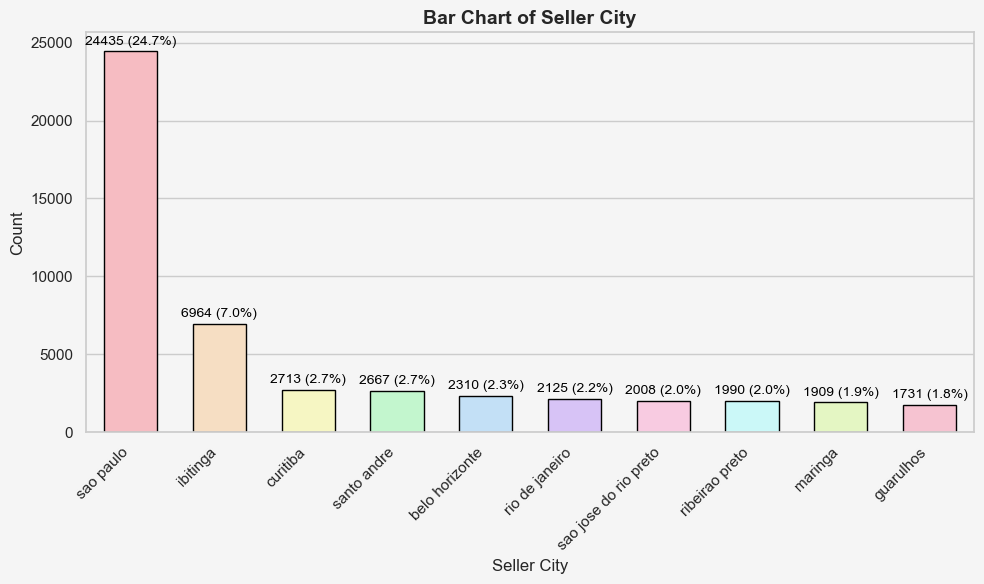

In [43]:
analyze_categorical_feature(full_data, 'Seller City')

- The `Seller City` feature contains **602 unique cities**, showing a wide distribution of sellers across Brazil.
- **São Paulo** stands out as the top seller location, contributing to nearly **25% of all orders**.
- A handful of cities like Ibitinga and Curitiba follow, but most others have minimal presence, with many contributing just a single sale.
- This reflects a **centralized seller market**, with dominant urban hubs and a long tail of low-activity seller locations.

### 3.6) Seller State

===== Summary of feature: Seller State =====

Feature: Seller State
------------------------------------------------------------
Data Type: object
Missing Values: 0 (0.00%)
------------------------------------------------------------
Description:
count     98834
unique       23
top          SP
freq      70159
Name: Seller State, dtype: object
------------------------------------------------------------
Value Counts (All):
              Count  Frequency (%)
Seller State                      
SP            70159      70.986705
MG             7762       7.853573
PR             7702       7.792865
RJ             4259       4.309246
SC             3658       3.701155
RS             1947       1.969970
DF              806       0.815509
BA              564       0.570654
GO              464       0.469474
PE              402       0.406743
MA              392       0.396625
ES              311       0.314669
MT              140       0.141652
CE               88       0.089038
RN            

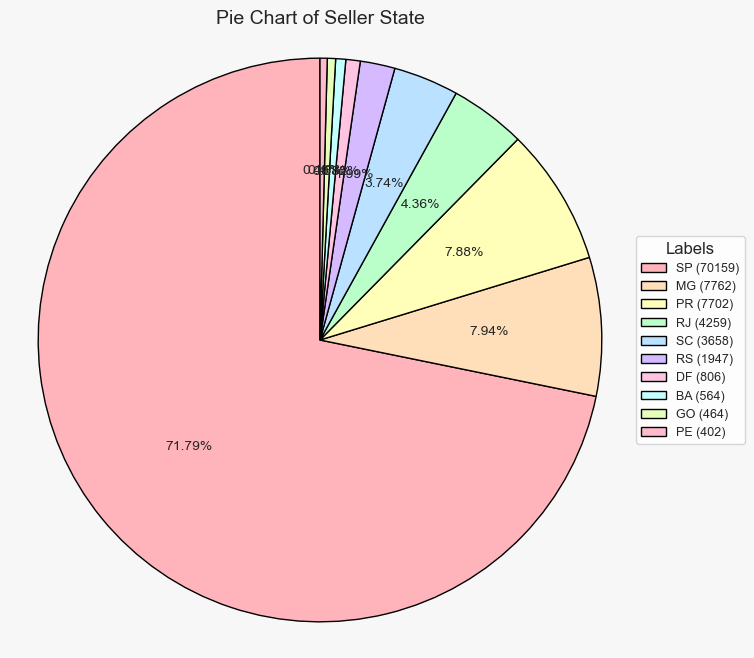


===== Bar Chart =====

Feature Seller State has more than 10 categories. Displaying top 10 most frequent.


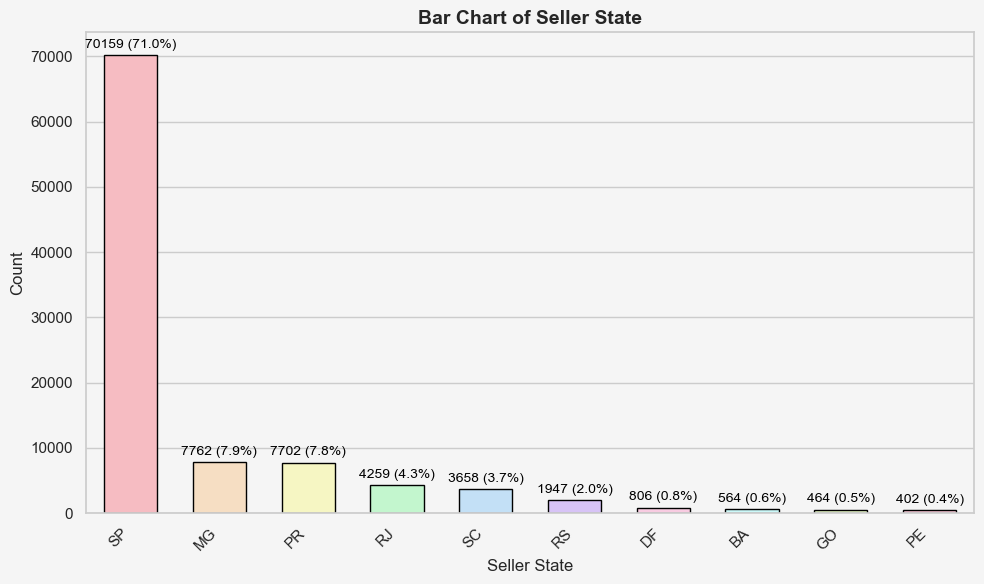

In [46]:
analyze_categorical_feature(full_data, 'Seller State')

- The `Seller State` feature includes **23 unique states**, with **no missing values**.
- **São Paulo (SP)** overwhelmingly dominates, accounting for over **70% of all sellers** in the dataset.
- Other states like MG, PR, and RJ contribute modestly, while many have negligible seller representation.
- This heavy concentration in SP highlights a strong centralization of e-commerce supply chains in one region.

### 3.7) Payment Method

===== Summary of feature: Payment Method =====

Feature: Payment Method
------------------------------------------------------------
Data Type: object
Missing Values: 0 (0.00%)
------------------------------------------------------------
Description:
count           98834
unique              3
top       credit_card
freq            77382
Name: Payment Method, dtype: object
------------------------------------------------------------
Value Counts (All):
                Count  Frequency (%)
Payment Method                      
credit_card     77382      78.294919
boleto          19905      20.139830
debit_card       1547       1.565251


===== Pie Chart =====



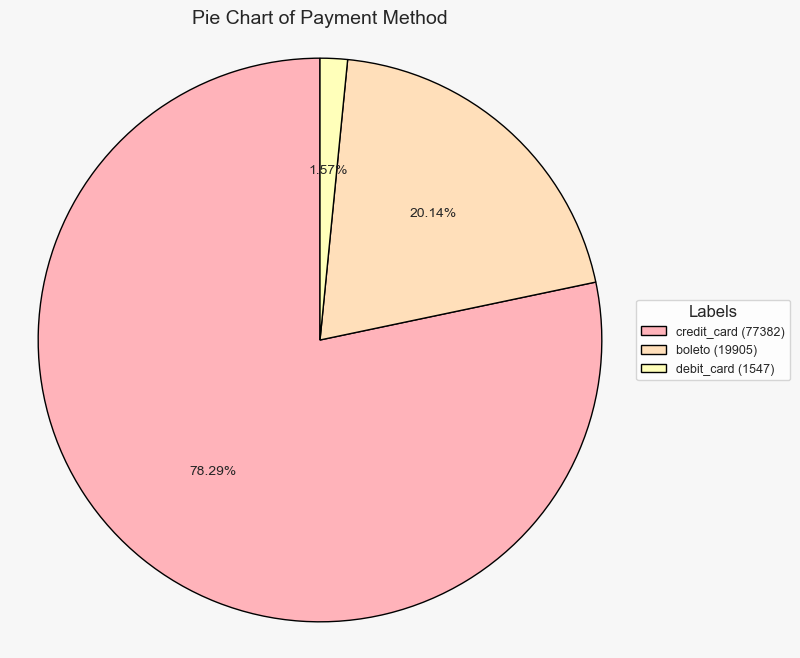


===== Bar Chart =====



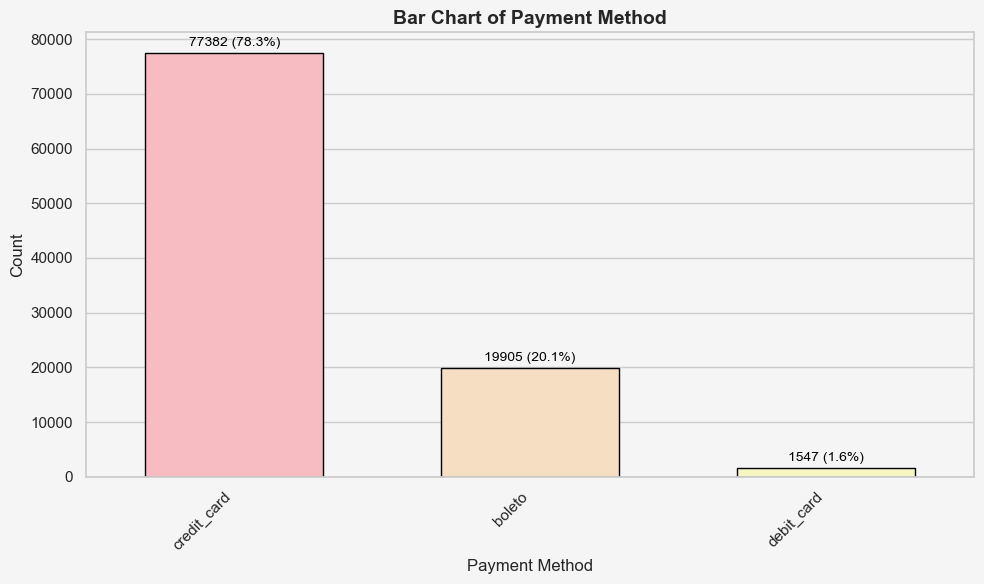

In [49]:
analyze_categorical_feature(full_data, 'Payment Method')

- The `Payment Method` feature has **3 unique categories** and **no missing values**.
- **Credit card** is the dominant method, used in over **78% of all transactions**, followed by **boleto** at 20%.
- **Debit card** is rarely used, representing just **1.6%** of payments.
- This indicates a strong preference for credit-based payments in e-commerce, possibly due to flexibility or installment options.

### 3.8) Used Voucher

===== Summary of feature: Used Voucher =====

Feature: Used Voucher
------------------------------------------------------------
Data Type: object
Missing Values: 0 (0.00%)
------------------------------------------------------------
Description:
count     98834
unique        2
top          No
freq      96566
Name: Used Voucher, dtype: object
------------------------------------------------------------
Value Counts (All):
              Count  Frequency (%)
Used Voucher                      
No            96566      97.705243
Yes            2268       2.294757


===== Pie Chart =====



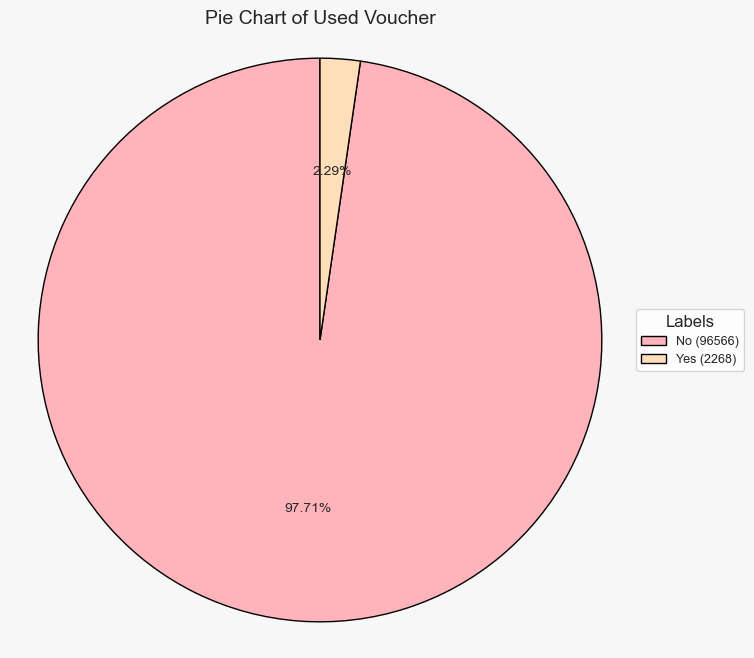


===== Bar Chart =====



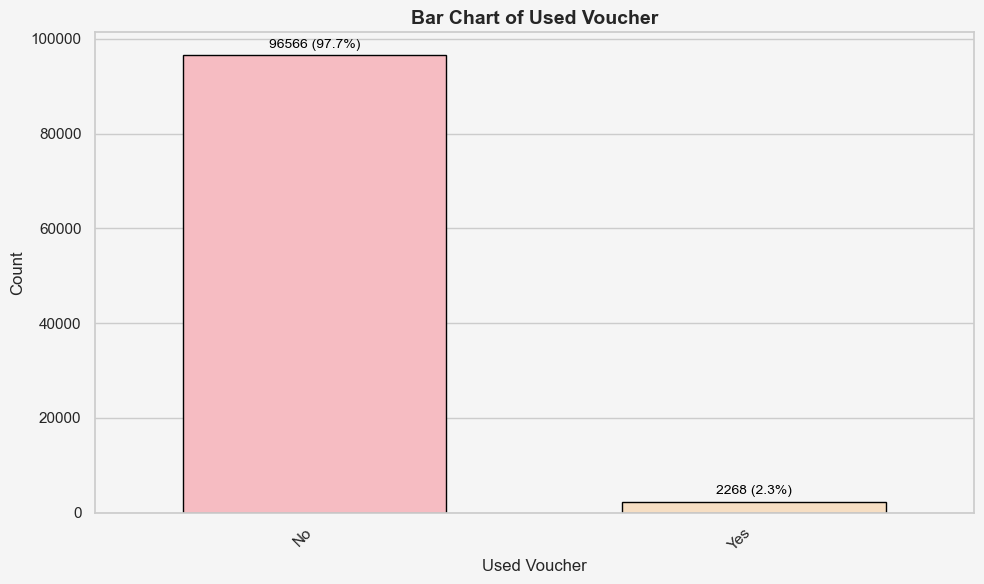

In [52]:
analyze_categorical_feature(full_data, 'Used Voucher')

- The `Used Voucher` feature has **2 categories**: "Yes" and "No", with **no missing values**.
- An overwhelming **97.7% of transactions did not use a voucher**, while only **2.3%** applied one.
- This suggests that promotional voucher usage is relatively rare in the dataset.
- The low adoption may reflect limited availability, low awareness, or customer preference for other discounts.

### 3.9) Purchase Time

===== Summary of feature: Purchase Time Day =====

Feature: Purchase Time Day
------------------------------------------------------------
Data Type: category
Missing Values: 0 (0.00%)
------------------------------------------------------------
Description:
count     98834
unique       31
top          24
freq       3910
Name: Purchase Time Day, dtype: int64
------------------------------------------------------------
Value Counts (All):
                   Count  Frequency (%)
Purchase Time Day                      
24                  3910       3.956128
16                  3591       3.633365
15                  3487       3.528138
4                   3464       3.504867
5                   3431       3.471477
6                   3416       3.456300
18                  3406       3.446182
14                  3372       3.411781
19                  3349       3.388510
7                   3317       3.356133
8                   3302       3.340956
26                  3298       3.33690

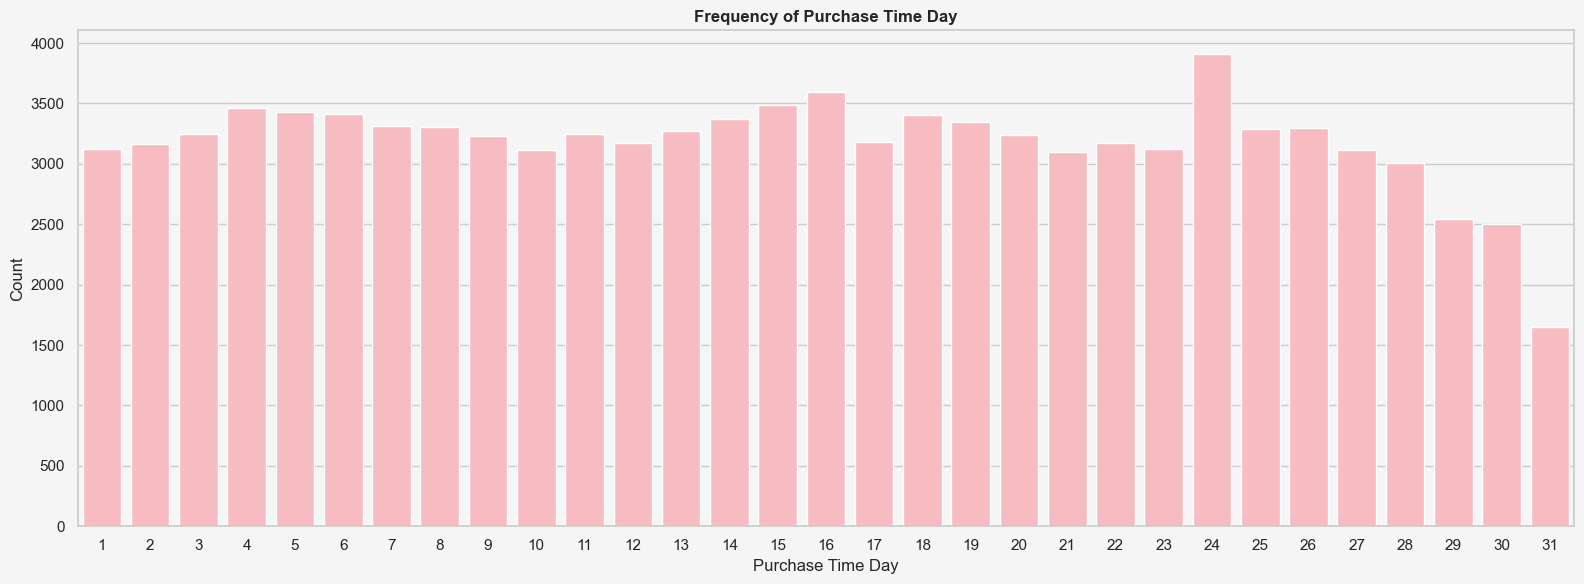

===== Summary of feature: Purchase Time Month =====

Feature: Purchase Time Month
------------------------------------------------------------
Data Type: category
Missing Values: 0 (0.00%)
------------------------------------------------------------
Description:
count     98834
unique       12
top           8
freq      10878
Name: Purchase Time Month, dtype: int64
------------------------------------------------------------
Value Counts (All):
                     Count  Frequency (%)
Purchase Time Month                      
8                    10878      11.006334
5                    10590      10.714936
7                    10298      10.419491
3                     9744       9.858955
6                     9471       9.582735
4                     9321       9.430965
2                     8348       8.446486
1                     7940       8.033673
11                    7525       7.613777
12                    5552       5.617500
10                    4927       4.985127
9     

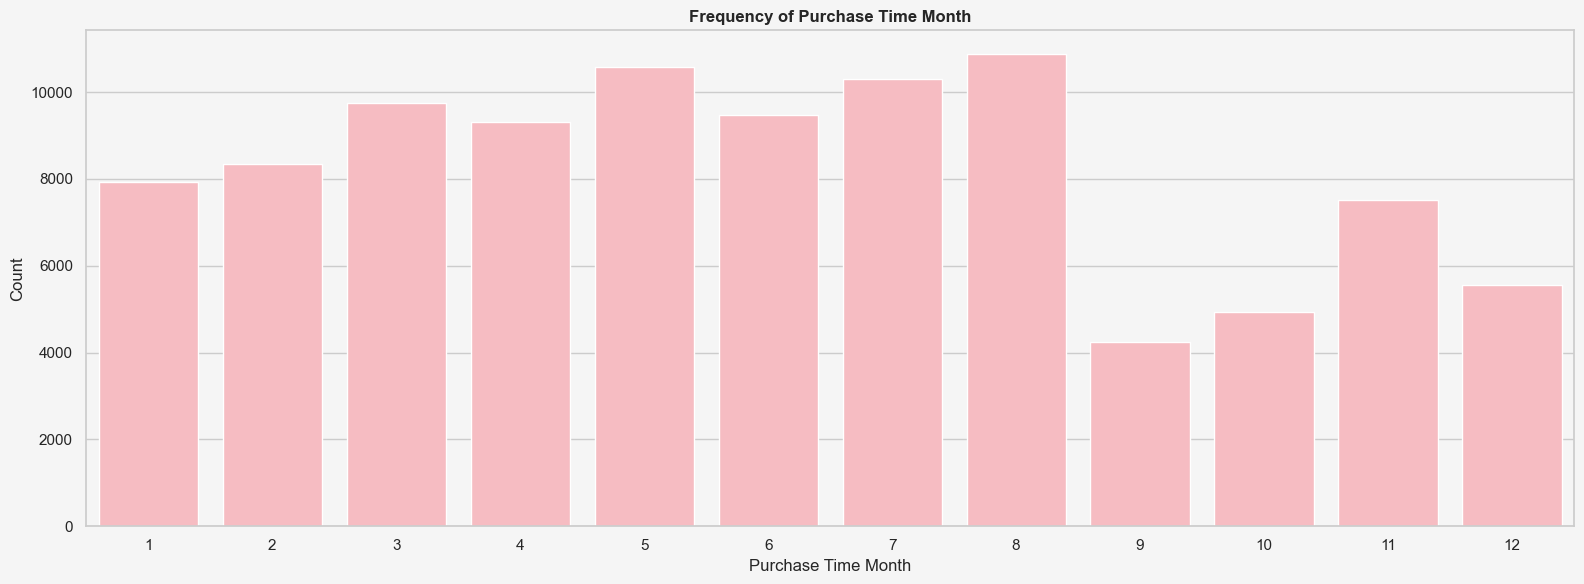

===== Summary of feature: Purchase Time Quarter =====

Feature: Purchase Time Quarter
------------------------------------------------------------
Data Type: category
Missing Values: 0 (0.00%)
------------------------------------------------------------
Description:
count     98834
unique        4
top           2
freq      29382
Name: Purchase Time Quarter, dtype: int64
------------------------------------------------------------
Value Counts (All):
                       Count  Frequency (%)
Purchase Time Quarter                      
2                      29382      29.728636
1                      26032      26.339114
3                      25416      25.715847
4                      18004      18.216403



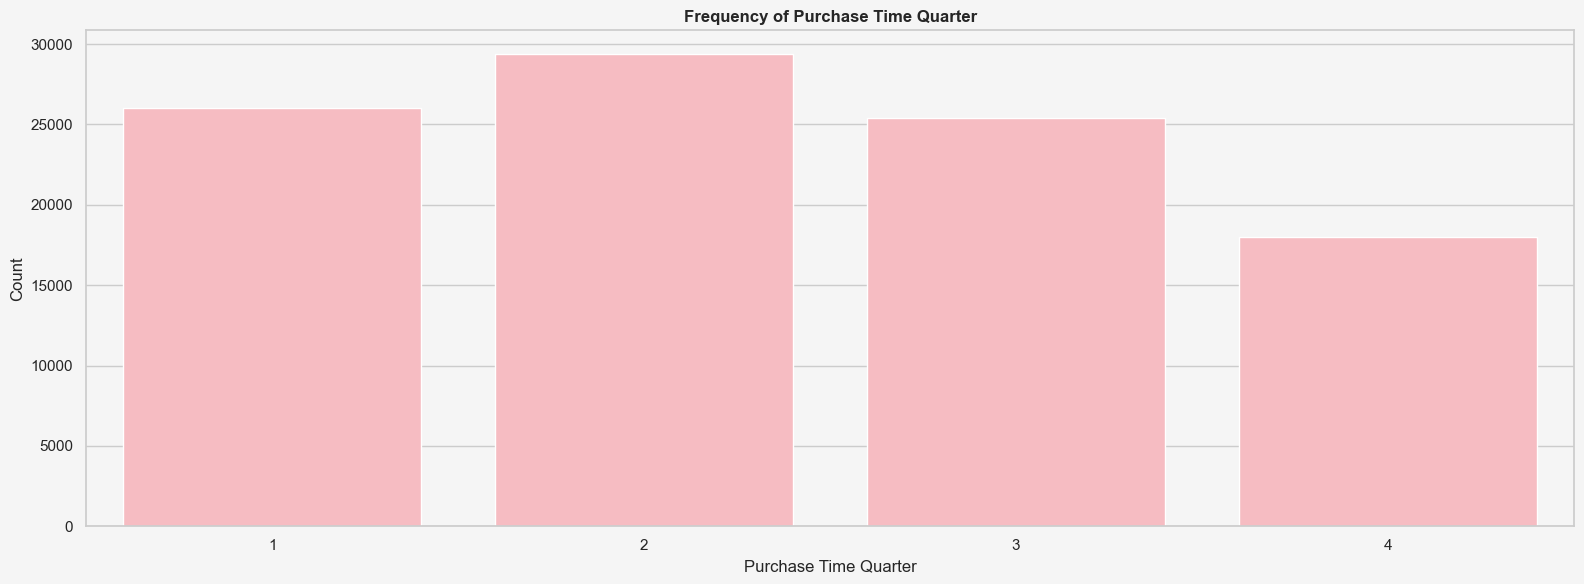

===== Summary of feature: Purchase Time Year =====

Feature: Purchase Time Year
------------------------------------------------------------
Data Type: category
Missing Values: 0 (0.00%)
------------------------------------------------------------
Description:
count     98834
unique        3
top        2018
freq      54037
Name: Purchase Time Year, dtype: int64
------------------------------------------------------------
Value Counts (All):
                    Count  Frequency (%)
Purchase Time Year                      
2018                54037      54.674505
2017                44478      45.002732
2016                  319       0.322763



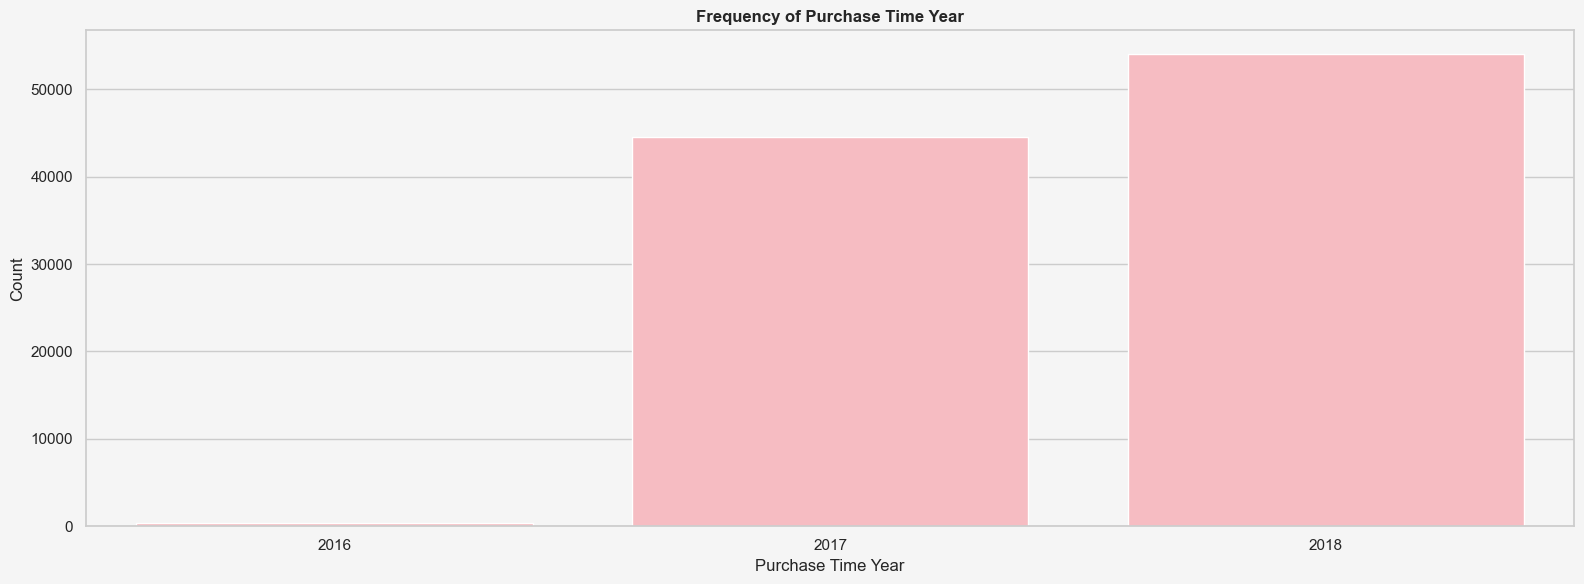

In [55]:
process_datetime_feature(full_data, 'Purchase Time')

- The `Purchase Time` feature has been decomposed into **day, month, quarter, and year**, all with **no missing values**.
- Most purchases occurred on the **24th day** of the month, in **August**, and during **Q2**, showing clear temporal peaks.
- The majority of transactions took place in **2018 (54.7%)**, followed by **2017**, with **2016** activity being negligible.
- These patterns indicate both seasonal and monthly fluctuations, likely tied to promotions, holidays, or consumer behavior cycles.

### 3.10) Num Items

===== Summary of feature: Num Items =====

Feature: Num Items
------------------------------------------------------------
Data Type: int64
Missing Values: 0 (0.00%)
------------------------------------------------------------
Description:
count    98834.000000
mean         1.100168
std          0.455038
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         20.000000
Name: Num Items, dtype: float64
------------------------------------------------------------
Value Counts (All):
           Count  Frequency (%)
Num Items                      
1          91964      93.048951
2           5221       5.282595
3            916       0.926807
4            380       0.384483
6            167       0.168970
5            164       0.165935
10             5       0.005059
7              4       0.004047
12             2       0.002024
9              2       0.002024
15             2       0.002024
14             2       0.002024
8              2       

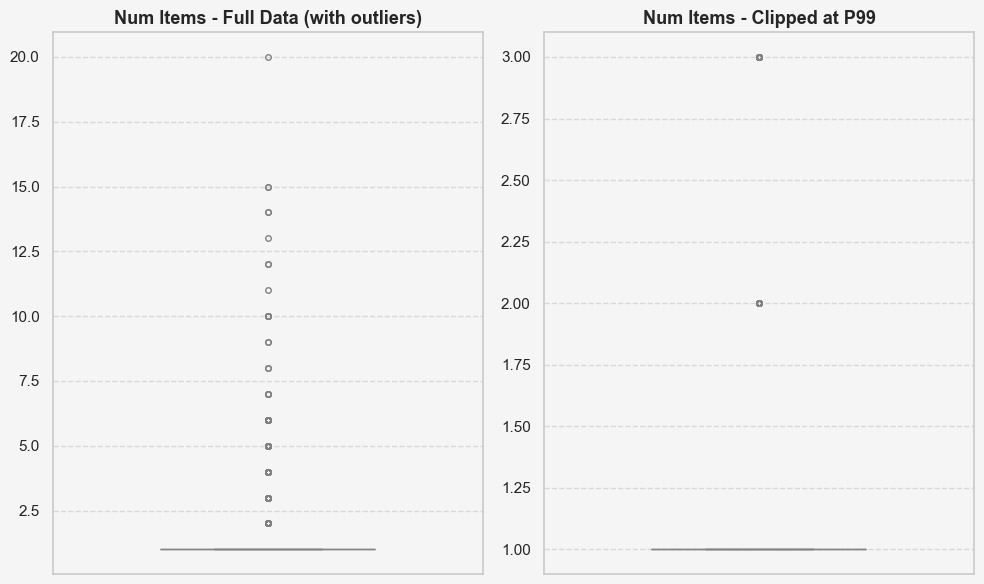


===== Histogram Comparison (Full vs Clipped) =====



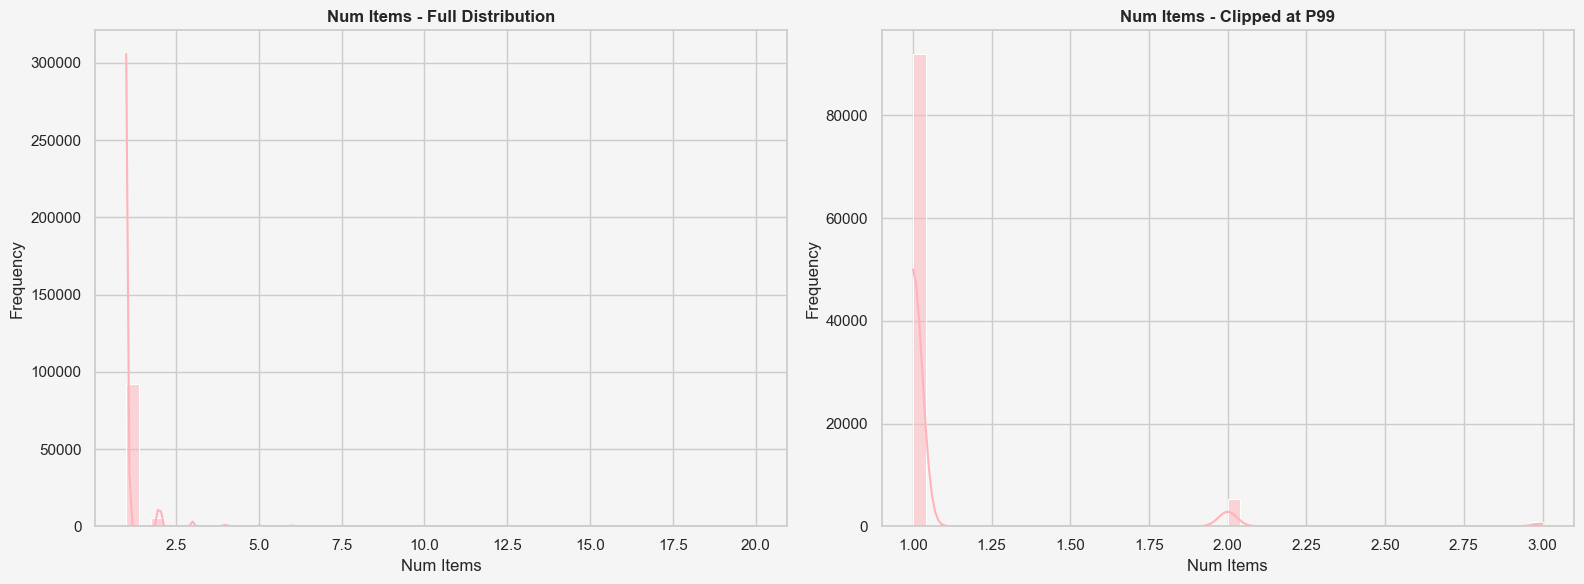

In [60]:
analyze_numerical_feature(full_data, 'Num Items')

- The `Num Items` feature has **no missing values** and ranges from **1 to 20**, with a **mean of 1.10** and a **median of 1**.
- A dominant **93% of orders contain only one item**, indicating that most purchases are single-product transactions.
- Higher item counts are extremely rare, with orders of 5 or more items making up less than **1%** of the dataset.
- This strong right-skewed distribution reflects typical e-commerce behavior, where customers usually purchase a limited number of items per order.

### 3.11) Review Score

===== Summary of feature: Review Score =====

Feature: Review Score
------------------------------------------------------------
Data Type: float64
Missing Values: 0 (0.00%)
------------------------------------------------------------
Description:
count    98834.000000
mean         4.078819
std          1.351202
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: Review Score, dtype: float64
------------------------------------------------------------
Value Counts (All):
              Count  Frequency (%)
Review Score                      
5.0           56866      57.536880
4.0           19015      19.239331
1.0           11435      11.569905
3.0            8265       8.362507
2.0            3253       3.291377


===== Box Plot =====



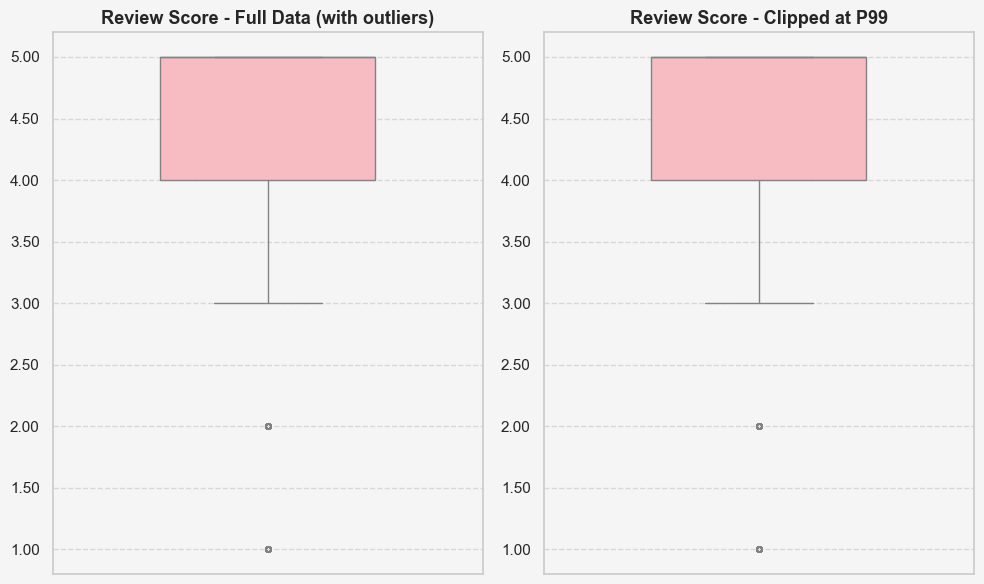


===== Histogram Comparison (Full vs Clipped) =====



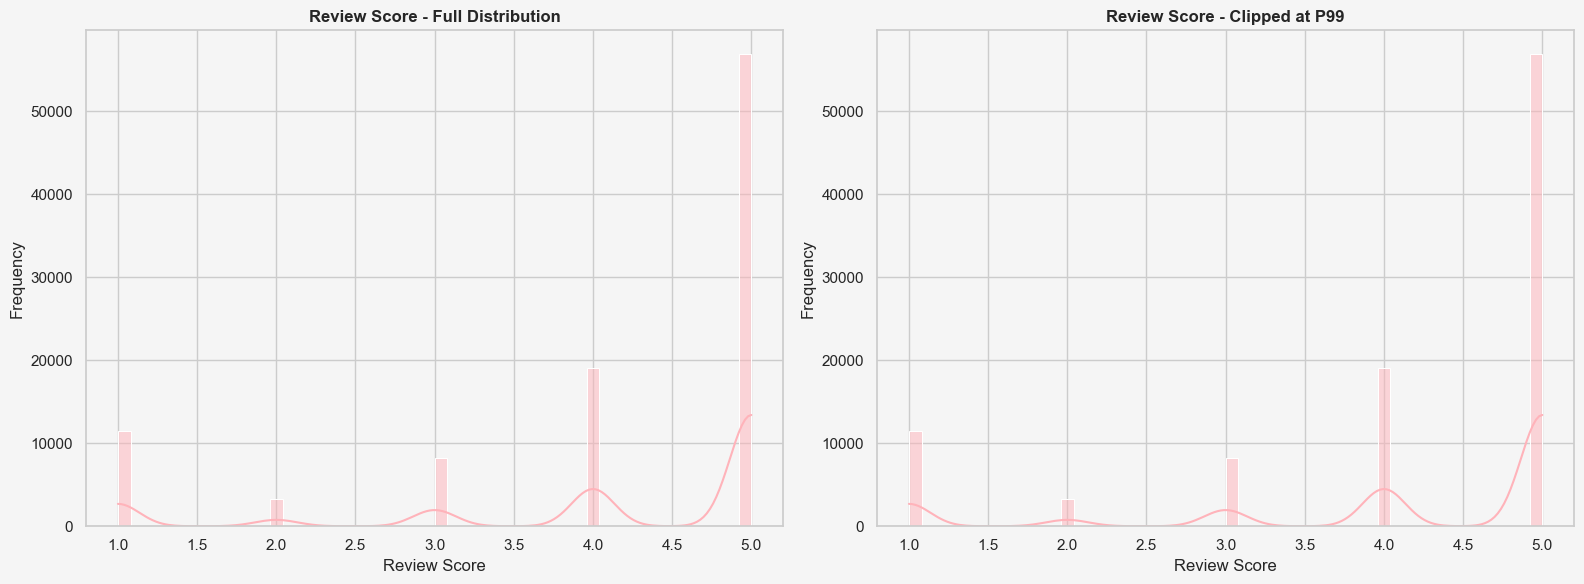

In [63]:
analyze_numerical_feature(full_data, 'Review Score')

- The `Review Score` ranges from **1 to 5**, with a **mean of 4.08** and a **median of 5**, indicating generally positive feedback.
- Over **57.5%** of reviews are perfect scores, while only **11.6%** are rated as 1, showing a skew toward customer satisfaction.
- Scores of **4 and 3** are moderately common, whereas ratings of 2 are relatively rare.
- This distribution suggests that most customers were satisfied with their purchase experience, though a notable minority expressed dissatisfaction.

### 3.12) Price

===== Summary of feature: Price =====

Feature: Price
------------------------------------------------------------
Data Type: float64
Missing Values: 0 (0.00%)
------------------------------------------------------------
Description:
count    98834.000000
mean       133.329441
std        204.801538
min          0.850000
25%         45.000000
50%         82.890000
75%        148.697500
max      13440.000000
Name: Price, dtype: float64
------------------------------------------------------------
Value Counts (All):
         Count  Frequency (%)
Price                        
59.90     1817       1.838436
69.90     1684       1.703867
49.90     1469       1.486331
89.90     1351       1.366939
99.90     1265       1.279924
...        ...            ...
1117.80      1       0.001012
2.99         1       0.001012
185.40       1       0.001012
34.76        1       0.001012
123.40       1       0.001012

[6830 rows x 2 columns]


===== Box Plot =====



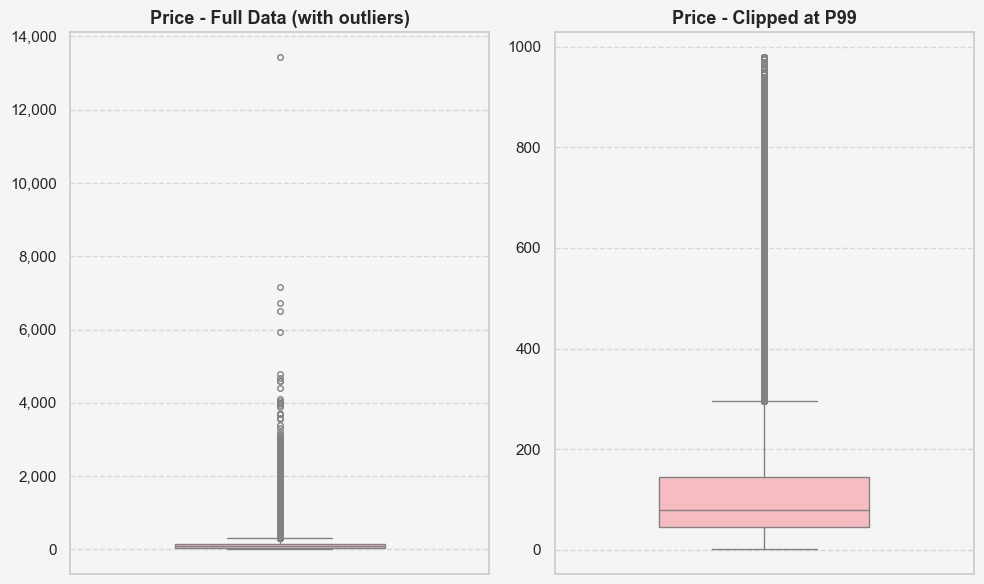


===== Histogram Comparison (Full vs Clipped) =====



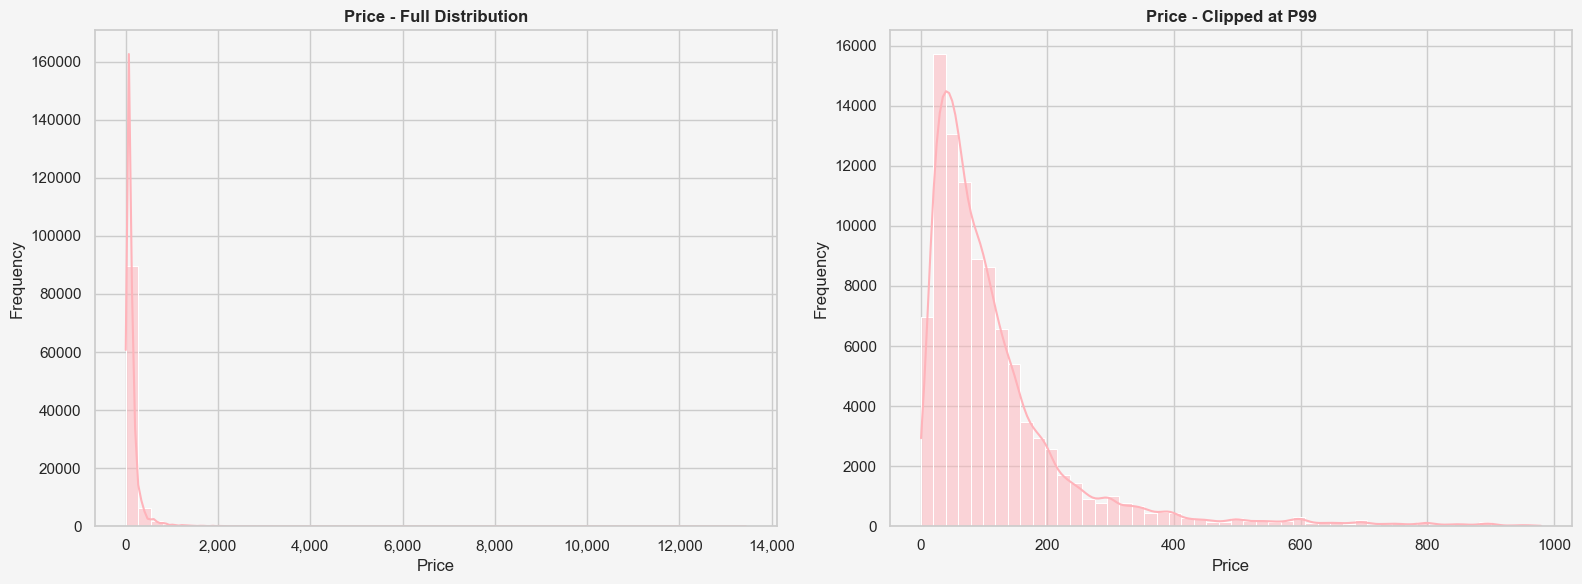

In [66]:
analyze_numerical_feature(full_data, 'Price')

- The `Price` feature ranges from **0.85 to 13,440**, with a **mean of 133.33** and a **median of 82.89**, indicating a **right-skewed distribution**.
- Most prices cluster around common retail points like **59.90**, **69.90**, and **49.90**, reflecting pricing strategies or promotions.
- The top **25% of orders exceed 148.70**, suggesting a significant portion of high-value transactions.
- The wide range and high standard deviation indicate substantial variation in product pricing across the catalog.

### 3.13) Shipping Fee

===== Summary of feature: Shipping Fee =====

Feature: Shipping Fee
------------------------------------------------------------
Data Type: float64
Missing Values: 0 (0.00%)
------------------------------------------------------------
Description:
count    98834.000000
mean        22.063727
std         20.554688
min          0.000000
25%         13.552500
50%         16.920000
75%         23.310000
max       1794.960000
Name: Shipping Fee, dtype: float64
------------------------------------------------------------
Value Counts (All):
              Count  Frequency (%)
Shipping Fee                      
15.10          2921       2.955461
7.78           1846       1.867778
14.10          1498       1.515673
11.85          1464       1.481272
18.23          1221       1.235405
...             ...            ...
99.52             1       0.001012
60.32             1       0.001012
42.35             1       0.001012
76.49             1       0.001012
40.67             1       0.001012

[787

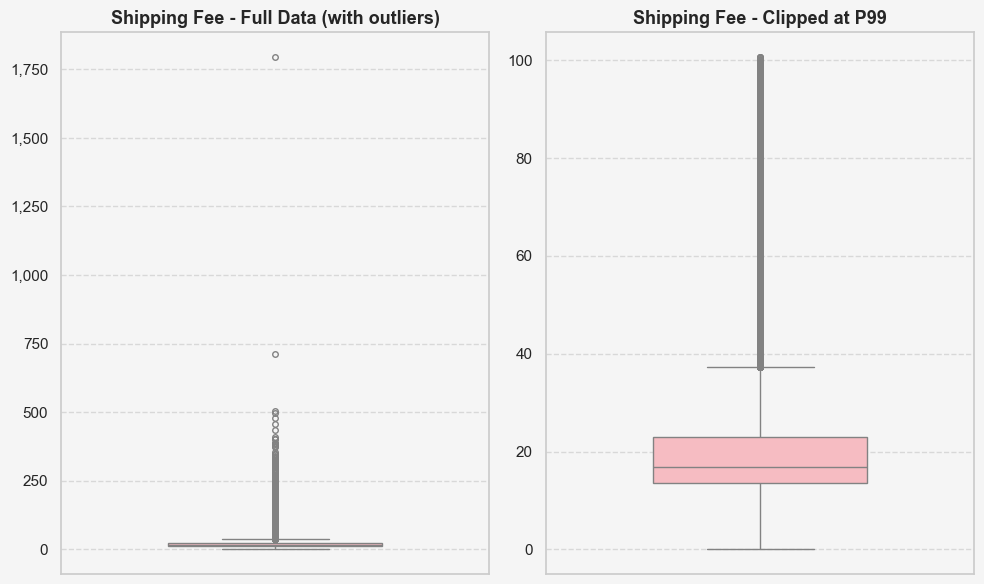


===== Histogram Comparison (Full vs Clipped) =====



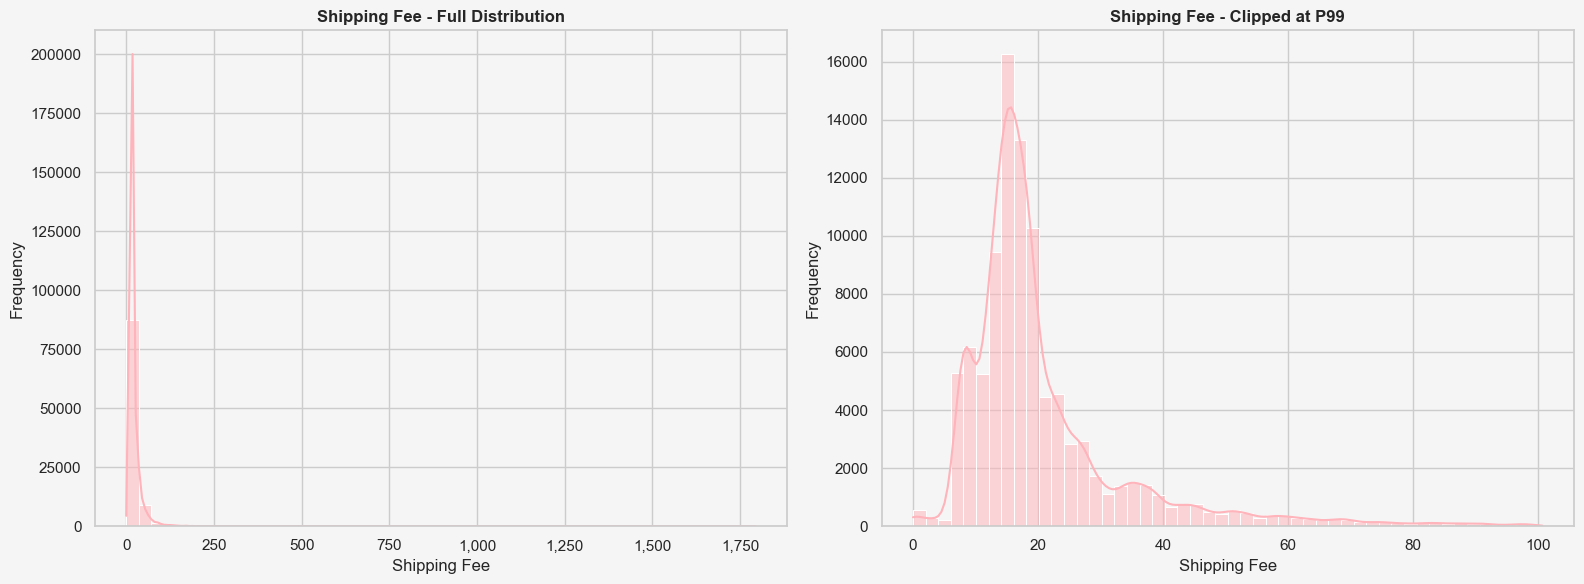

In [69]:
analyze_numerical_feature(full_data, 'Shipping Fee')

- The `Shipping Fee` ranges from **0 to 1,794.96**, with a **mean of 22.06** and a **median of 16.92**, showing a **right-skewed distribution**.
- The majority of fees fall between **13.55 and 23.31**, indicating a relatively consistent cost range for most deliveries.
- Some values are exceptionally high, likely tied to large, heavy, or long-distance shipments.
- The presence of **0 shipping fees** suggests that free shipping may be offered in select cases, possibly as a promotion or policy.

## 4) Bivariate analysis

### 4.1) Numerical vs numerical features (Correlation & scatter plots)

#### 4.1.1) Scatter plots

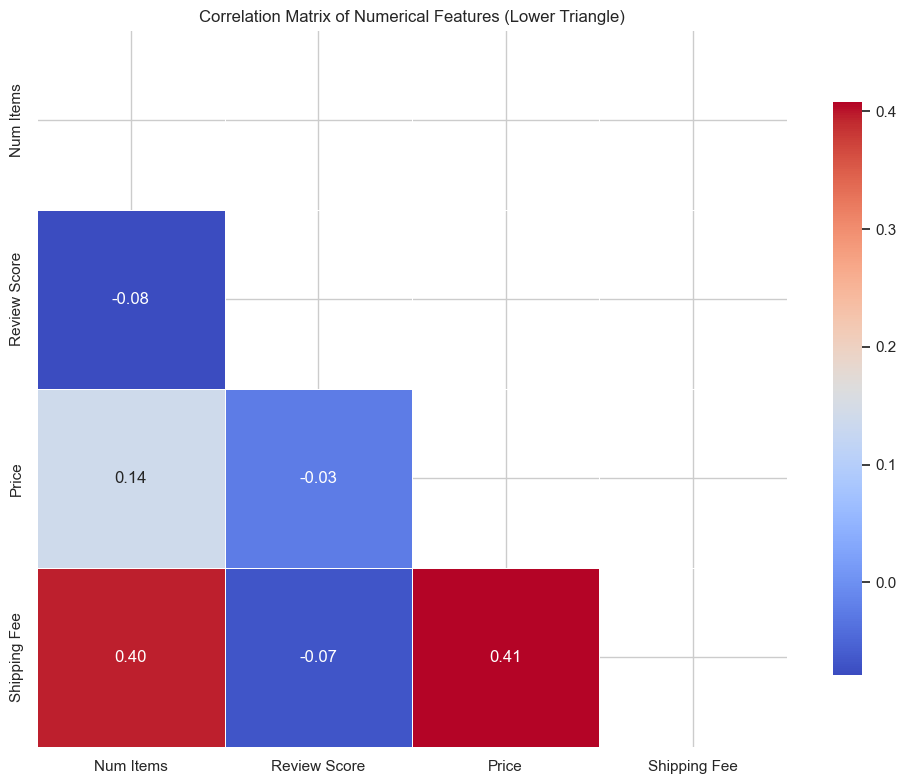

In [74]:
# Select numerical features to analyze correlation
numerical_cols = [
    'Num Items', 'Review Score', 'Price', 'Shipping Fee'
]

# Compute pairwise Pearson correlation matrix
corr = full_data[numerical_cols].corr()

# Mask the upper triangle for a cleaner lower-triangle heatmap
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5,
    cbar_kws={'shrink': .8}
)
plt.title('Correlation Matrix of Numerical Features (Lower Triangle)')
plt.tight_layout()
plt.show()


- **Shipping Fee** shows the strongest correlations:  
  - with `Price` (r = **0.41**)  
  - with `Num Items` (r = **0.40**)  
> Higher prices and more items generally lead to higher shipping costs.

- **Price** and `Num Items` have a weak positive correlation (r = **0.14**), suggesting slight cost increase with more products.

- **Review Score** has **very weak or no correlation** with any numerical feature (`Num Items`: -0.08, `Price`: -0.03, `Shipping Fee`: -0.07), implying that customer satisfaction may depend more on qualitative aspects like service or delivery experience.

- Overall, no signs of strong multicollinearity among variables — good for modeling.

### 4.2) Numerical vs categorical features (ANOVA)

In [77]:
def plot_numerical_vs_categorical(df, numerical_cols, categorical_cols):
    """
    Plots how numerical features differ across categorical groups using bar charts and ANOVA p-values.
    """
    pastel_colors = [
        "#FFB3BA", "#FFDFBA", "#FFFFBA", "#BAFFC9", "#BAE1FF",
        "#D5BAFF", "#FFC4E1", "#C4FFFF", "#E6FFBA", "#FFBACD"
    ]

    sns.set(style="whitegrid")

    for num_col in numerical_cols:
        n_cat = len(categorical_cols)
        cols_per_row = 3
        rows = math.ceil(n_cat / cols_per_row)

        # Create a grid of subplots
        fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 6, rows * 4))
        fig.suptitle(f"{num_col} vs Categorical Features", fontsize=16)
        axes = axes.flatten()

        for idx, cat_col in enumerate(categorical_cols):
            ax = axes[idx]
            sub_df = df[[num_col, cat_col]].dropna()

            # Prepare groups for ANOVA test
            categories = sub_df[cat_col].value_counts().index.tolist()
            num_categories = len(categories)
            groups = [group[num_col].values for name, group in sub_df.groupby(cat_col)]
            f_stat, p_val = f_oneway(*groups) if num_categories > 1 else (None, None)
            title_suffix = f"p = {p_val:.4f}" if p_val is not None else ""

            ax.set_facecolor("#f5f5f5")

            if num_categories <= 4:
                # Use vertical column plot for fewer categories
                avg_vals = sub_df.groupby(cat_col)[num_col].mean().sort_index()
                colors = pastel_colors[:len(avg_vals)]
                sns.barplot(x=avg_vals.index, y=avg_vals.values, palette=colors,
                            edgecolor="black", ax=ax)
                ax.set_title(f"{num_col} vs {cat_col}\n(Column Plot {title_suffix})")
                ax.set_ylabel(num_col)
                ax.set_xlabel(cat_col)
                ax.tick_params(axis='x', rotation=45)

                # Add data labels on bars
                for i, v in enumerate(avg_vals.values):
                    ax.text(i, v + 0.01 * max(avg_vals.values), f"{v:.2f}", ha='center', va='bottom', fontsize=9)

            else:
                # Use horizontal bar plot for many categories (top 10 only)
                avg_vals = sub_df.groupby(cat_col)[num_col].mean().sort_values(ascending=False).head(10)
                colors = pastel_colors[:len(avg_vals)]
                sns.barplot(y=avg_vals.index, x=avg_vals.values, palette=colors,
                            edgecolor="black", ax=ax)
                ax.set_title(f"{num_col} vs {cat_col}\n(Bar Plot {title_suffix})")
                ax.set_xlabel(num_col)
                ax.set_ylabel(cat_col)

                # Add data labels inside bars
                for i, (cat, val) in enumerate(avg_vals.items()):
                    ax.text(val / 2, i, f"{val:.2f}", va='center', ha='center', fontsize=9)

        # Hide unused subplots
        for j in range(len(categorical_cols), len(axes)):
            fig.delaxes(axes[j])

        # Adjust layout to fit the title
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()


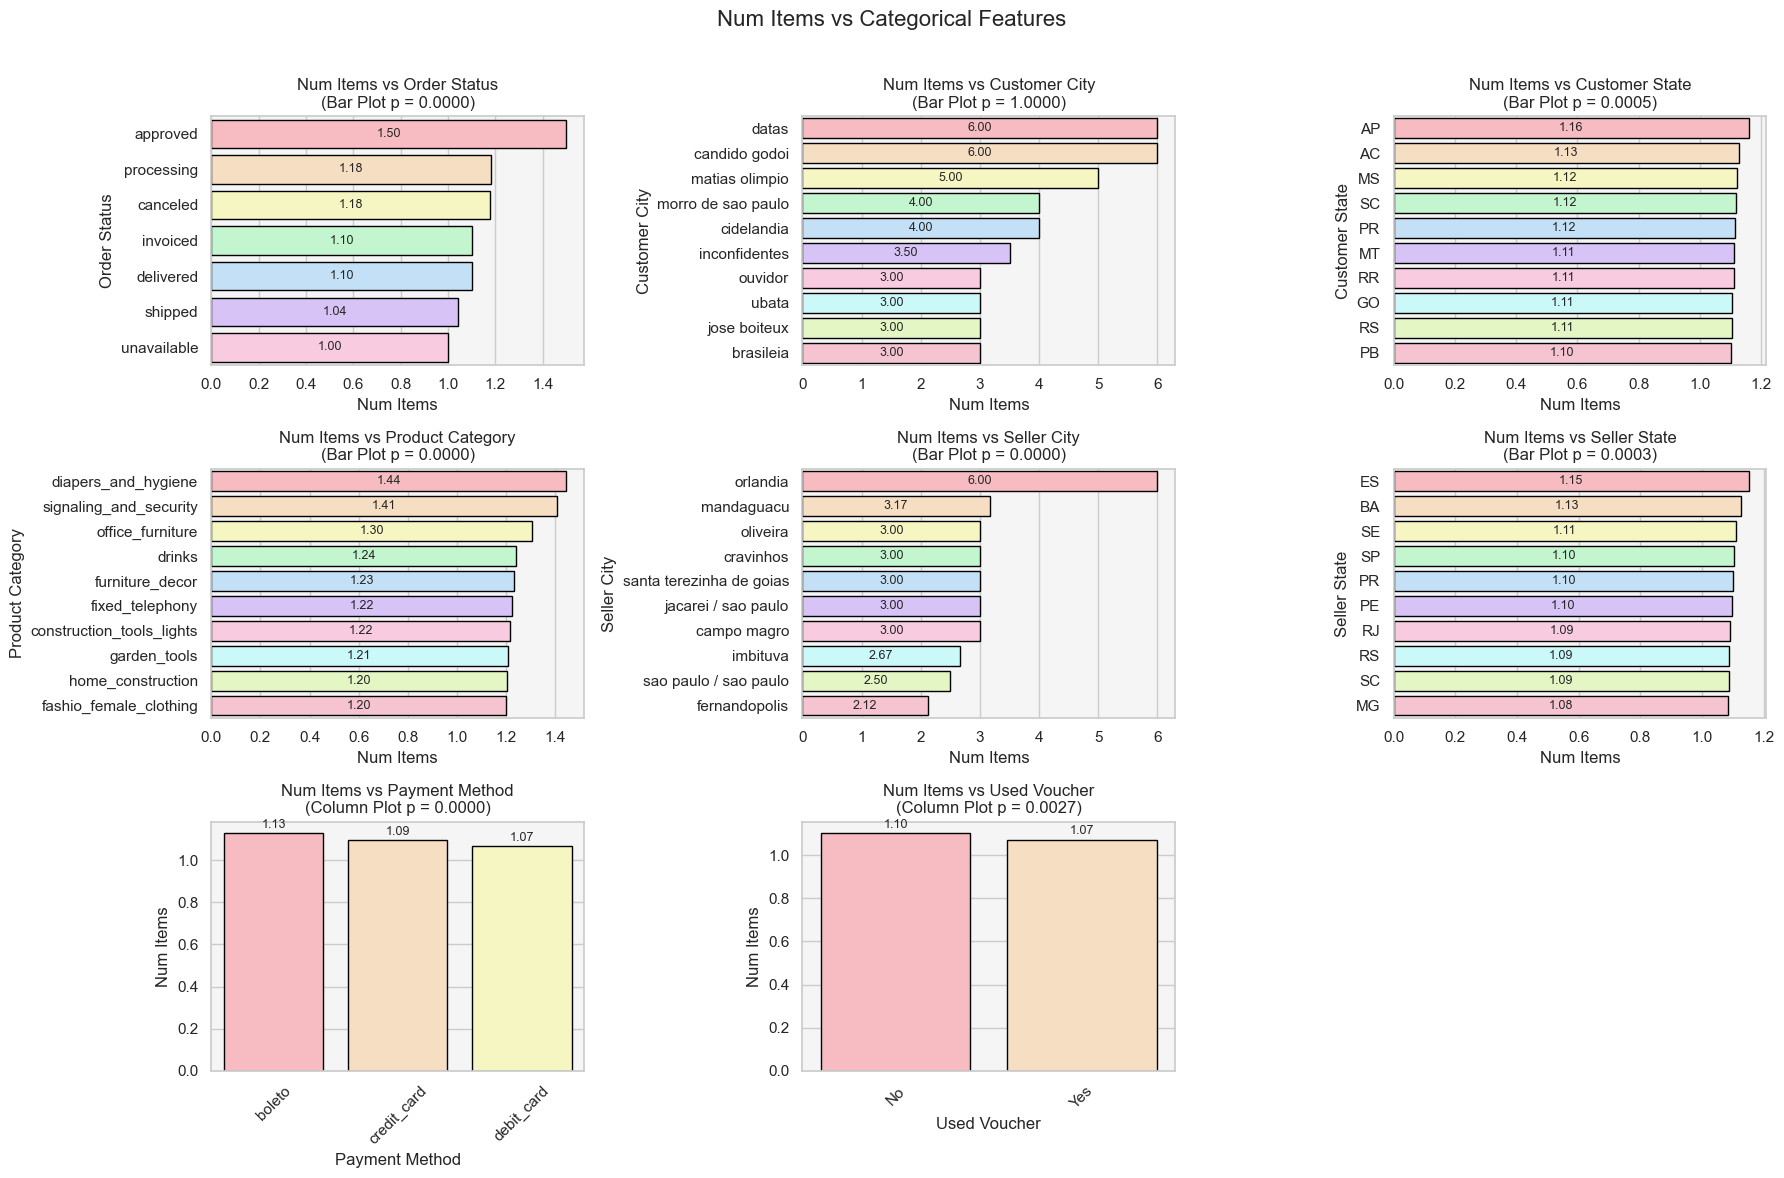

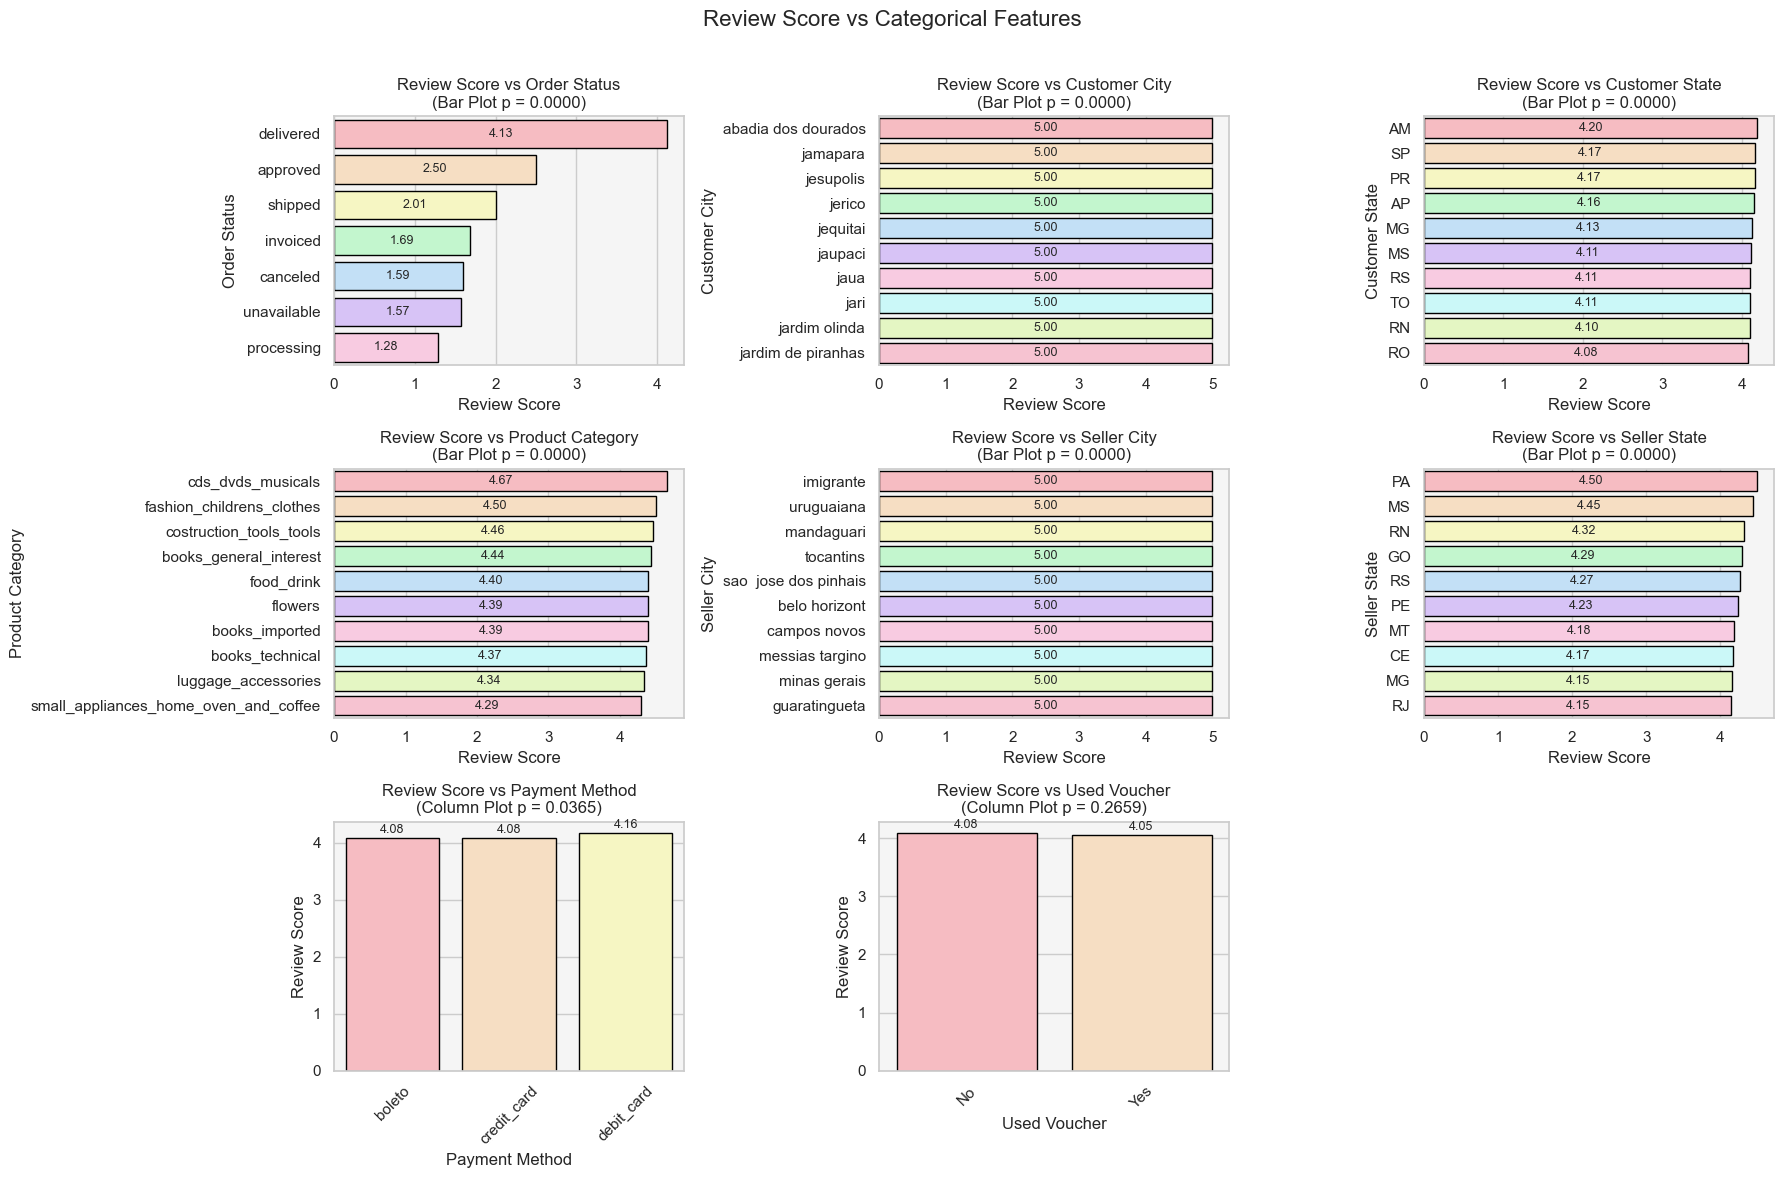

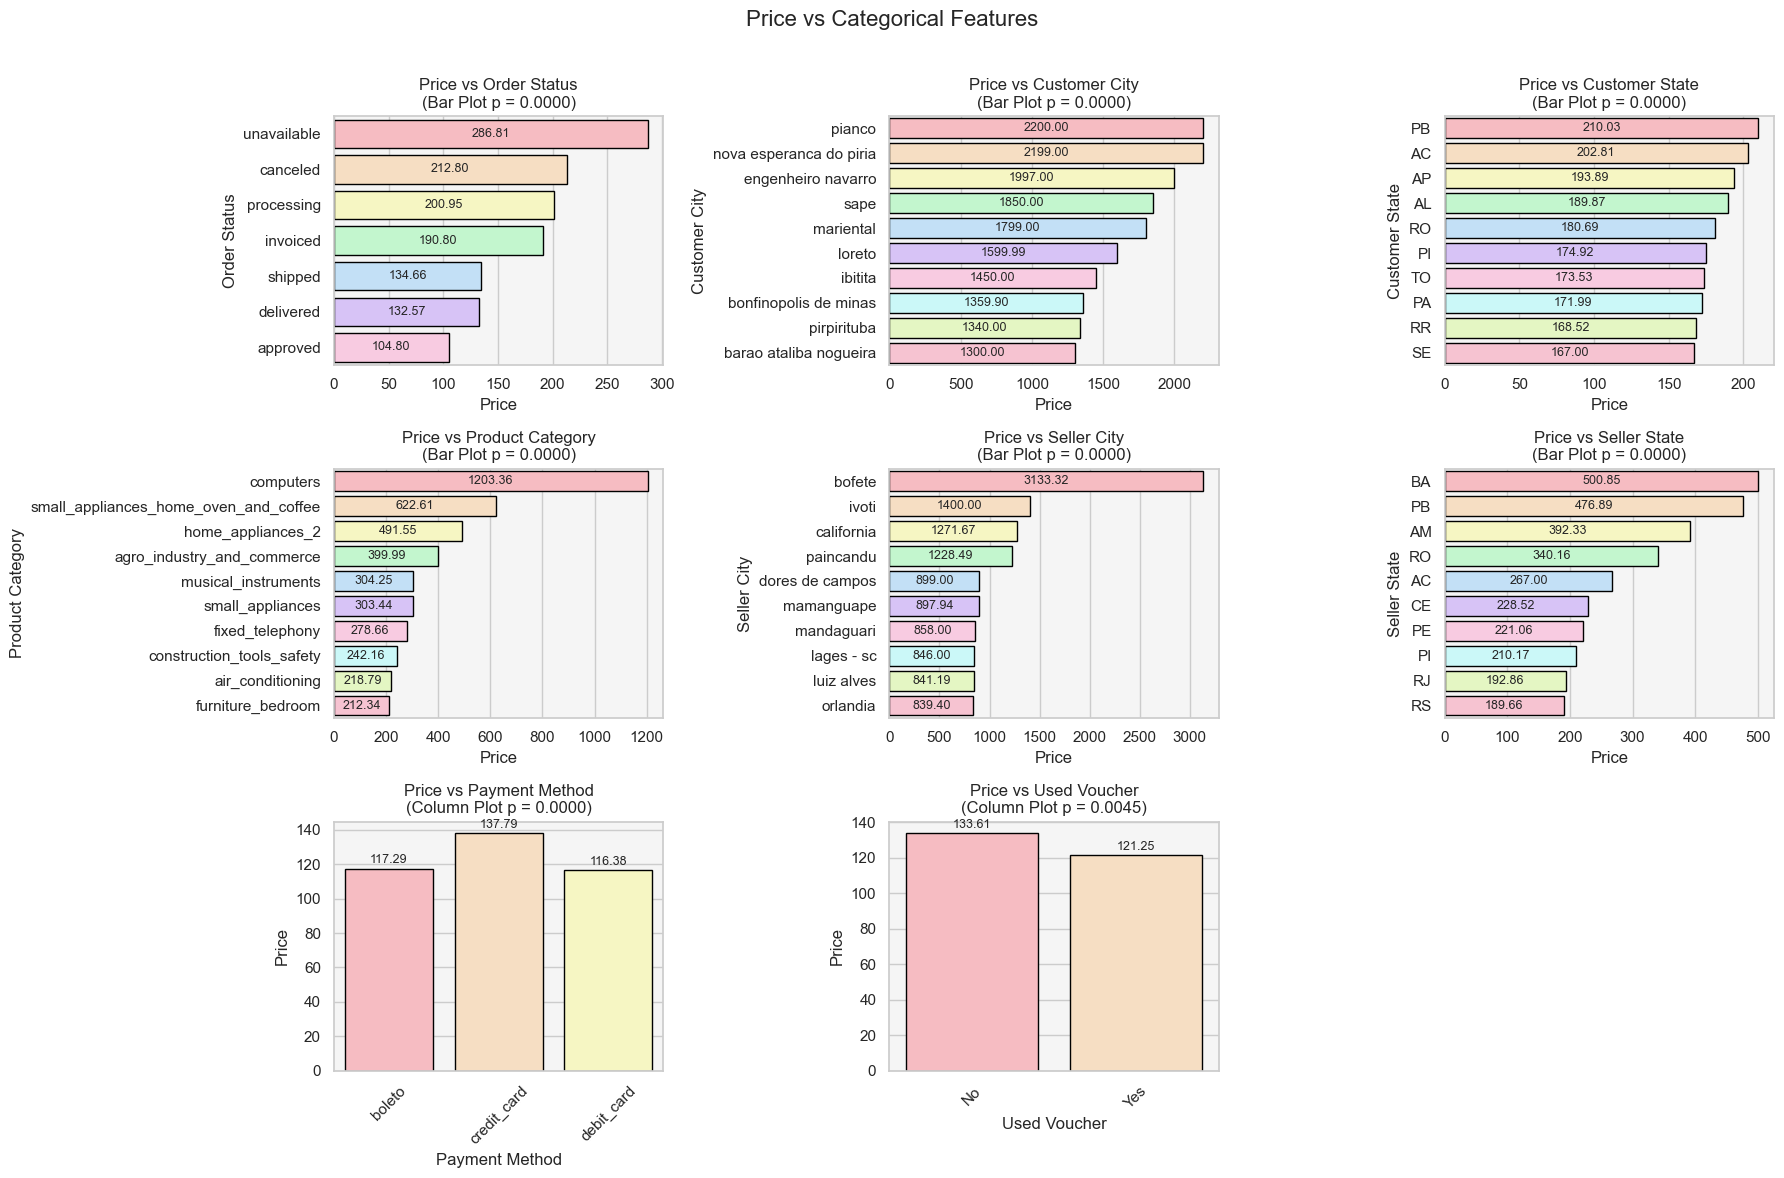

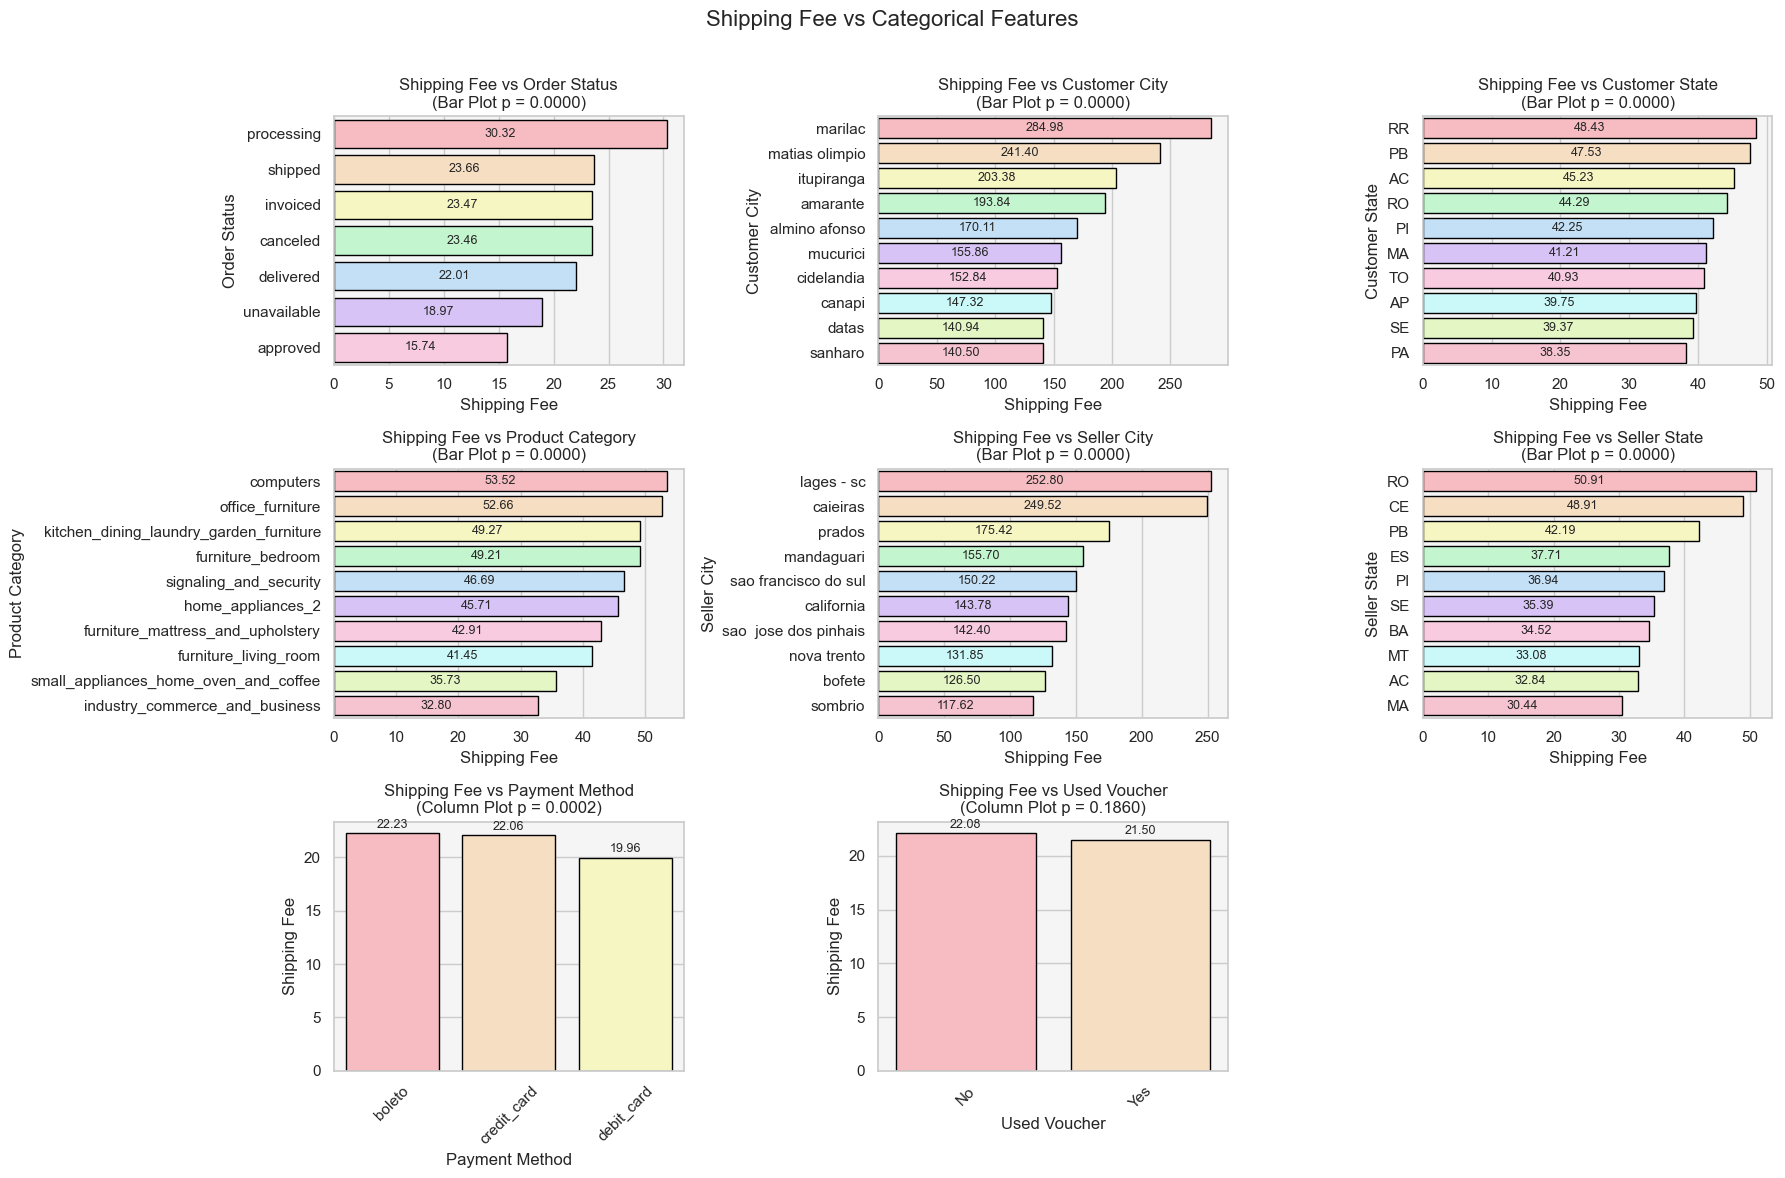

In [78]:
numerical_cols = ['Num Items', 'Review Score', 'Price', 'Shipping Fee']
categorical_cols = [
    'Order Status', 'Customer City', 'Customer State', 'Product Category', 'Seller City', 'Seller State',
    'Payment Method', 'Used Voucher'
]

plot_numerical_vs_categorical(full_data, numerical_cols, categorical_cols)

**Summary of Key Insights**

**Num Items**
- Most customers purchase **only one item per order** (average ≈ 1.10).
- **Product category** and **seller city** strongly influence item count:
  - `diapers_and_hygiene` has the **highest** number of items per order.
  - Cities like Orlândia may engage in **bulk or bundled sales**.
- **Order status** and **payment method** affect item count:
  - `approved` orders and `boleto` payments show **higher item counts**.
- **Voucher usage**: Non-users buy **slightly more items**.
- **Geographic factors** (seller/customer state): Minor effects, but **customer city is not significant**.

**Review Score**
- Average review score is **4.06** – generally **positive** customer satisfaction.
- **Order status** has the **largest effect**:
  - `delivered` orders score highest; `processing` orders lowest.
- **Seller city/state** and **customer state** impact satisfaction:
  - Extreme scores observed in cities like **Abadia de Goiás (5.0)** vs. **Macatuba (1.0)**.
- **Product category** matters:
  - Highest satisfaction: `CDs/DVDs/Musicals`
  - Lowest: `Security`, `Services`
- **Payment method** has significant effect:
  - **Debit card** users are most satisfied.
  - **Undefined** methods score lowest.
- **Voucher usage**: No significant effect.

**Price**
- Average price ≈ **132.48**, but varies **widely**.
- **Product category** is the most powerful driver:
  - `computers`: High price (avg. ~1231.84)
  - `home_comfort_2`: Low price (avg. ~32.49)
- **Seller location** influences price:
  - Cities like **Bofete** show very high averages.
- **Customer location** also matters:
  - **Paraíba (PB)** has high prices; **São Paulo (SP)** the lowest.
- **Order status** impacts pricing:
  - `processing`: Higher prices
  - `created`: Zero price (likely incomplete)
- **Payment method**: Credit card users spend more; `not_defined` often has 0 price.
- **Voucher usage**: Lowers price by ~11.32 on average.

**Shipping Fee**
- Average shipping fee ≈ **21.89**, but varies by **location** and **product**.
- **Geography** is key:
  - Higher fees in **remote** locations like **Roraima (RR)** and **Marilac**.
  - Lowest fees in **urban centers** like **São Paulo (SP)**.
- **Product category** affects cost:
  - Heavy/valuable items (e.g., `computers`) cost more to ship.
  - Small/light items (e.g., `children’s fashion`) cost less.
- **Seller location** and **order status** also matter:
  - `processing`: Highest shipping fees
  - `created`: Zero fees (likely incomplete)
- **Payment method**: Minor differences; `boleto` slightly higher.
- **Voucher usage**: No significant impact on shipping fee.

> **Conclusion**: Factors like product type, logistics, and fulfillment status strongly influence key order metrics, while voucher usage has limited impact beyond price.

In [79]:
# Pastel color palette
pastel_colors = [
    "#FFB3BA", "#FFDFBA", "#FFFFBA", "#BAFFC9", "#BAE1FF",
    "#D5BAFF", "#FFC4E1", "#C4FFFF", "#E6FFBA", "#FFBACD"
]

def bubble_plots_by_category_mean(
    df, numerical_cols, categorical_cols,
    cols_per_row: int = 3,
    bubble_size: int = 1500,
    annot_fontsize: int = 10,
    max_cats: int = 10,
    top_n: int = 5
):
    """
    Draws bubble plots (mean x, y per category) for each categorical column.
    If the number of groups > max_cats, only keeps top_n groups with the highest 'score'
    (score = mean across all numerical_cols).
    """
    sns.set(style="whitegrid")
    
    combos = list(combinations(numerical_cols, 2))
    n_plots = len(combos)
    rows = math.ceil(n_plots / cols_per_row)
    
    for cat_col in categorical_cols:
        # Compute mean for each group
        subdf = df[numerical_cols + [cat_col]].dropna()
        mean_df = subdf.groupby(cat_col)[numerical_cols].mean().reset_index()
        
        # If number of groups > max_cats, select top_n by average score
        if mean_df.shape[0] > max_cats:
            mean_df['score'] = mean_df[numerical_cols].mean(axis=1)
            mean_df = mean_df.nlargest(top_n, 'score').drop(columns='score')
        
        categories = mean_df[cat_col].tolist()
        palette = dict(zip(categories, pastel_colors[:len(categories)]))
        
        # Create figure and axes
        fig, axes = plt.subplots(rows, cols_per_row,
                                 figsize=(cols_per_row * 5, rows * 4))
        axes = axes.flatten()
        fig.suptitle(f"Mean Bubble Plots by '{cat_col}' (showing {len(categories)} categories)", y=0.98, fontsize=16)
        
        # Draw each subplot, disable internal legends
        for ax, (x_col, y_col) in zip(axes, combos):
            sns.scatterplot(
                data=mean_df,
                x=x_col, y=y_col,
                hue=cat_col,
                palette=palette,
                s=bubble_size,
                edgecolor='k',
                linewidth=1.0,
                alpha=0.7,
                ax=ax,
                legend=False
            )
            ax.set_xlabel(f"Mean {x_col}")
            ax.set_ylabel(f"Mean {y_col}")
            
            # Annotate mean y-values
            for _, row in mean_df.iterrows():
                ax.text(
                    row[x_col], row[y_col],
                    f"{row[y_col]:.2f}",
                    ha='center', va='center',
                    fontsize=annot_fontsize,
                    color='black',
                    weight='bold'
                )
        
        # Remove unused axes
        for ax in axes[n_plots:]:
            fig.delaxes(ax)
        
        # Create a shared legend with black borders
        patches = [
            mpatches.Patch(
                facecolor=palette[cat],
                edgecolor='k',
                label=str(cat),
                linewidth=1.5
            )
            for cat in categories
        ]
        fig.legend(
            handles=patches,
            title=cat_col,
            loc='upper center',
            bbox_to_anchor=(0.5, 0.92),
            ncol=len(categories),
            frameon=True,
            fontsize='small',
            title_fontsize='medium'
        )
        
        plt.tight_layout(rect=[0, 0, 1, 0.90])
        plt.show()


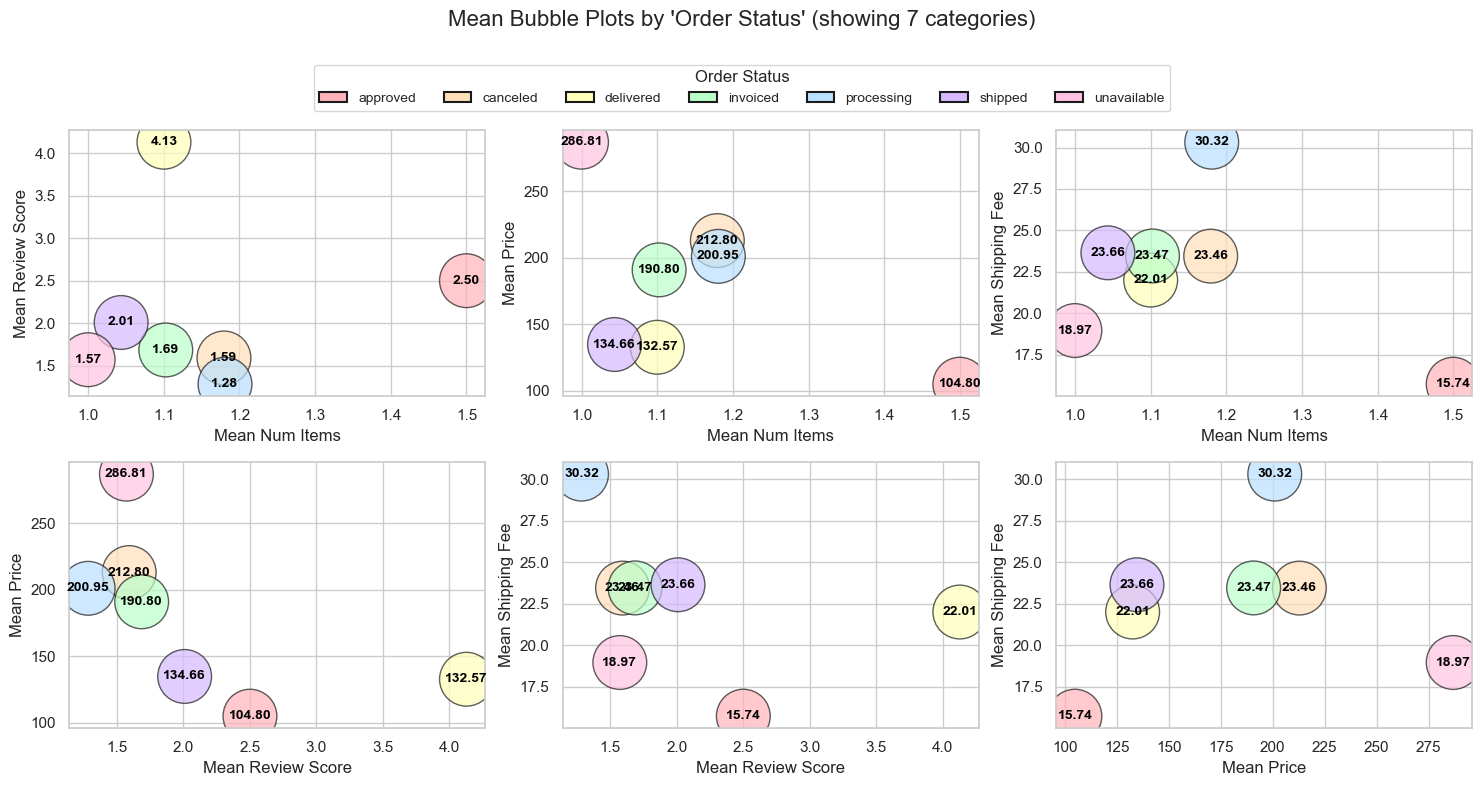

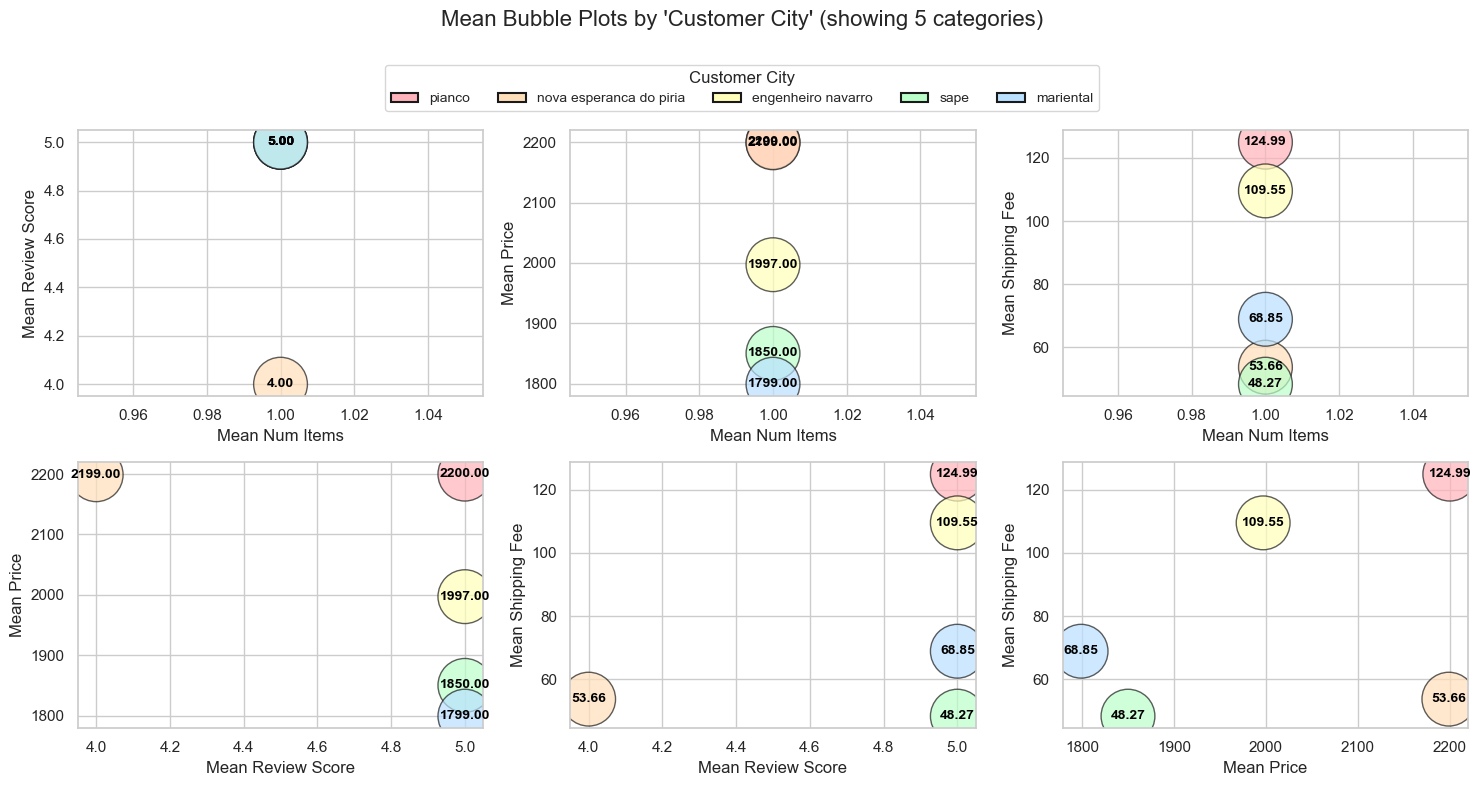

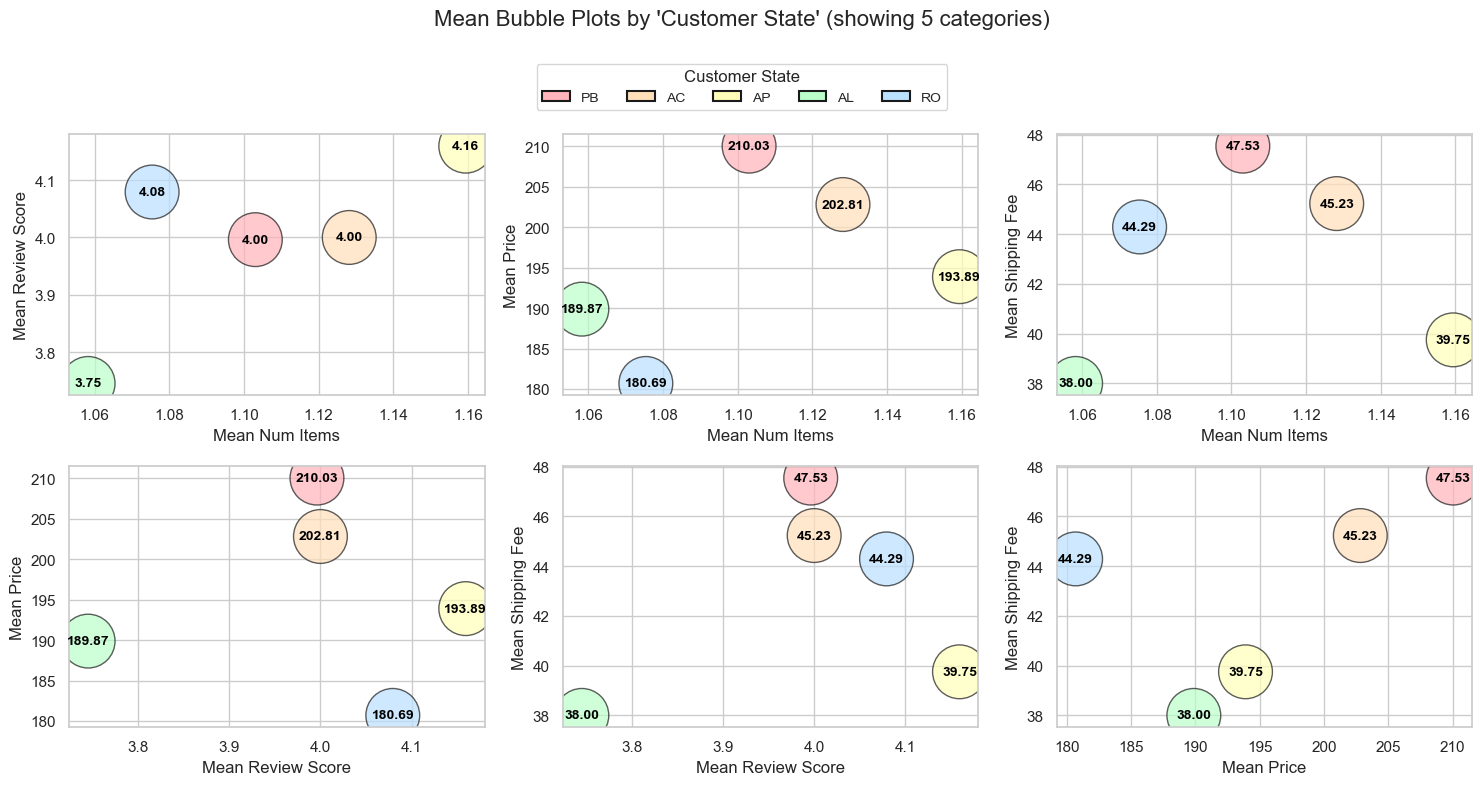

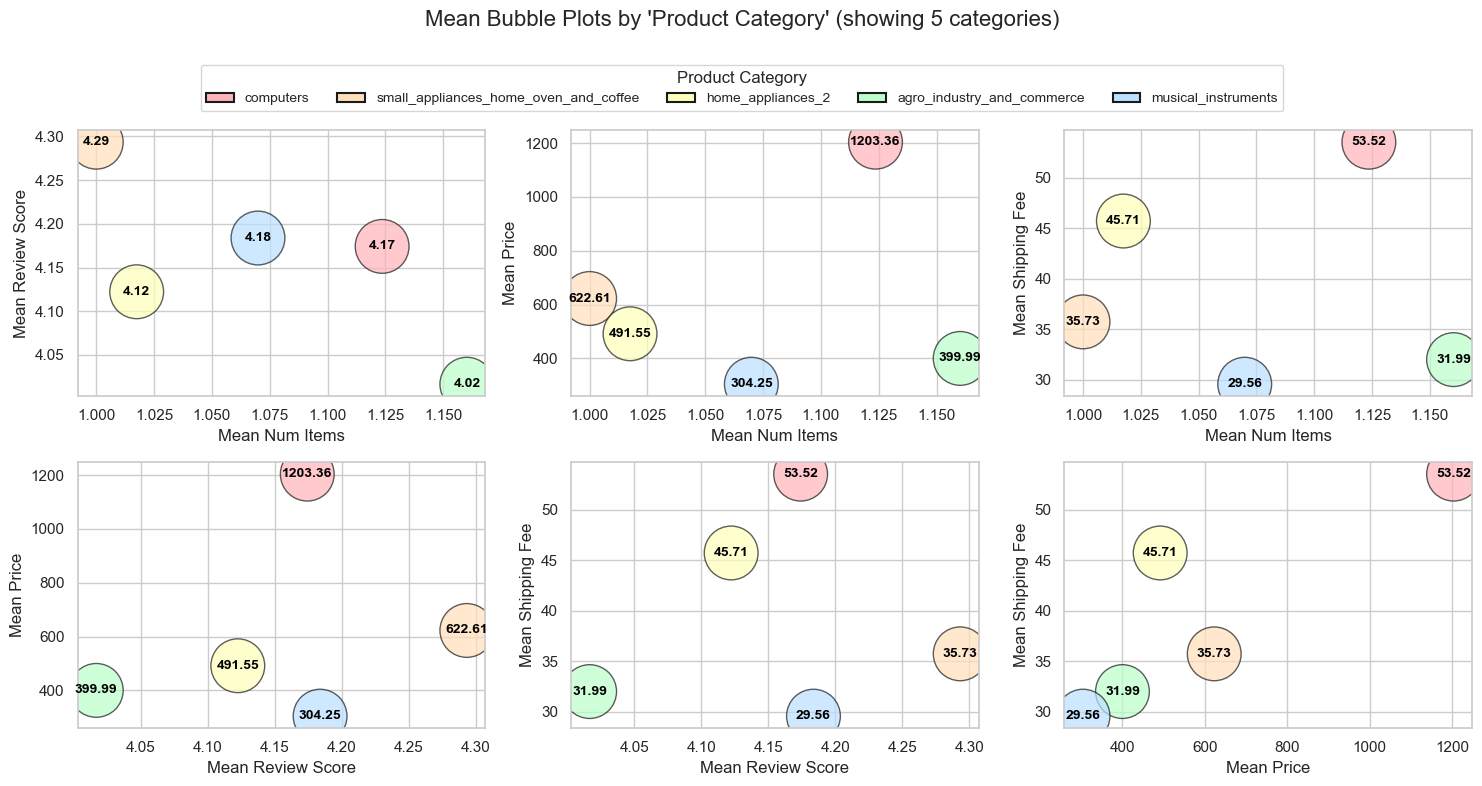

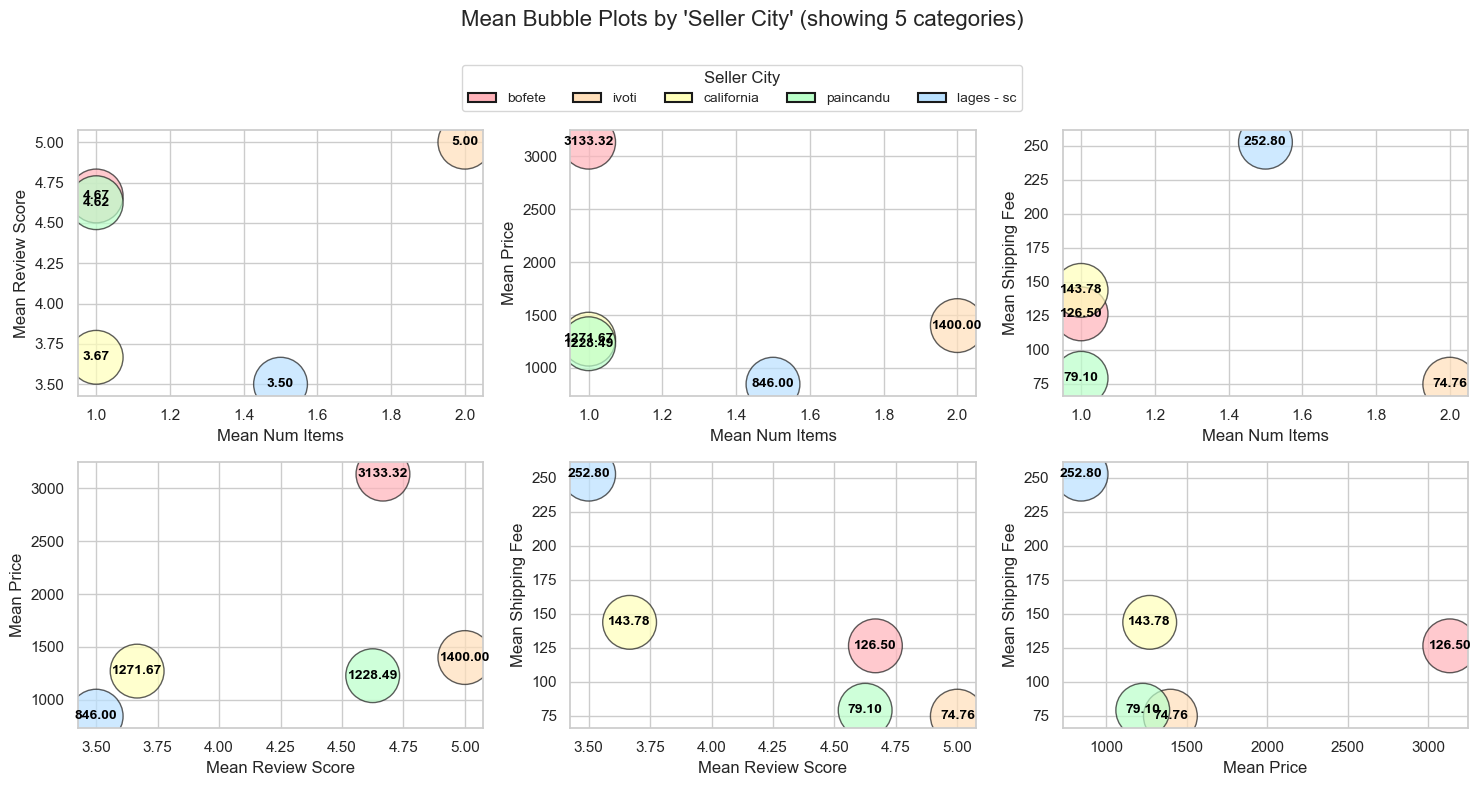

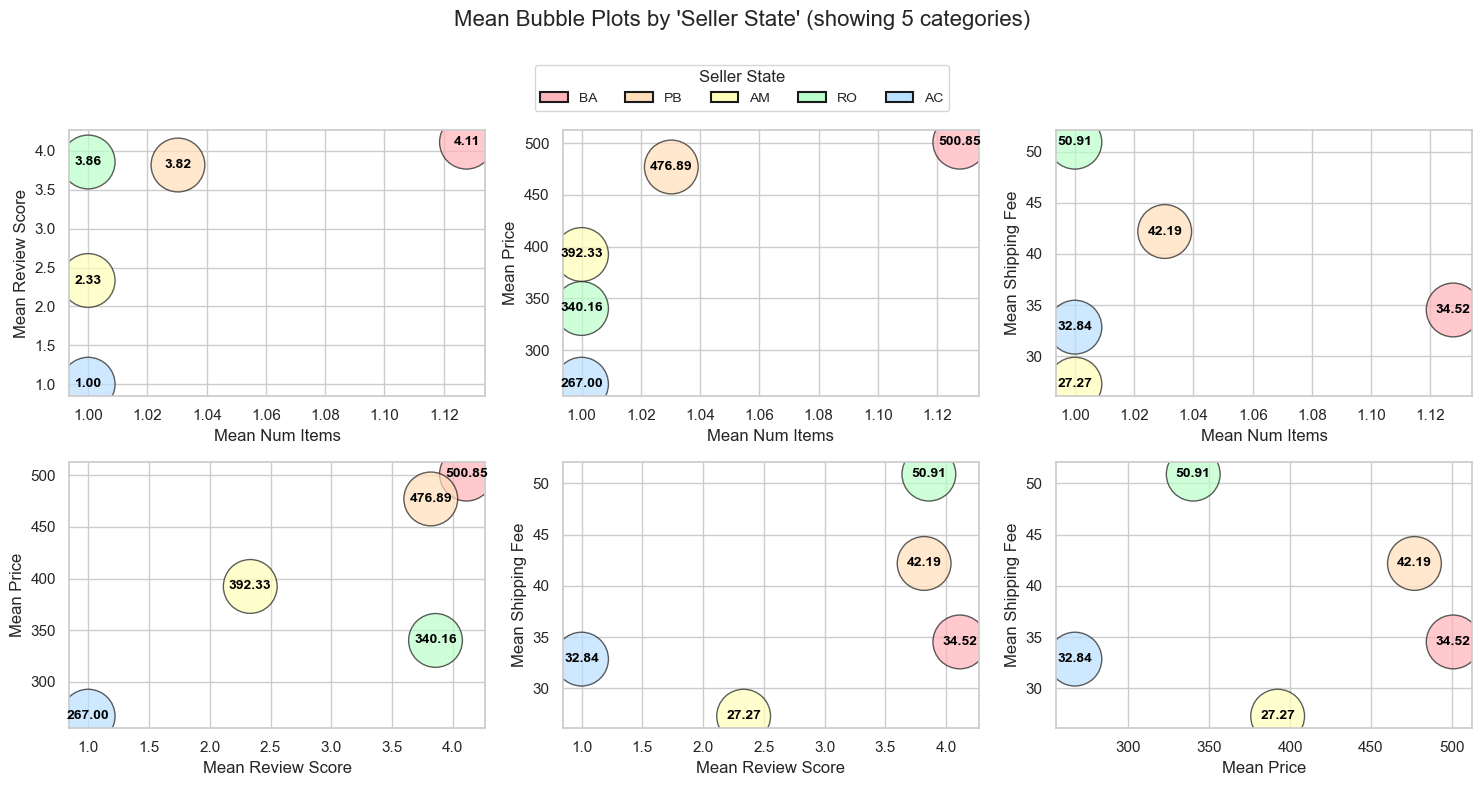

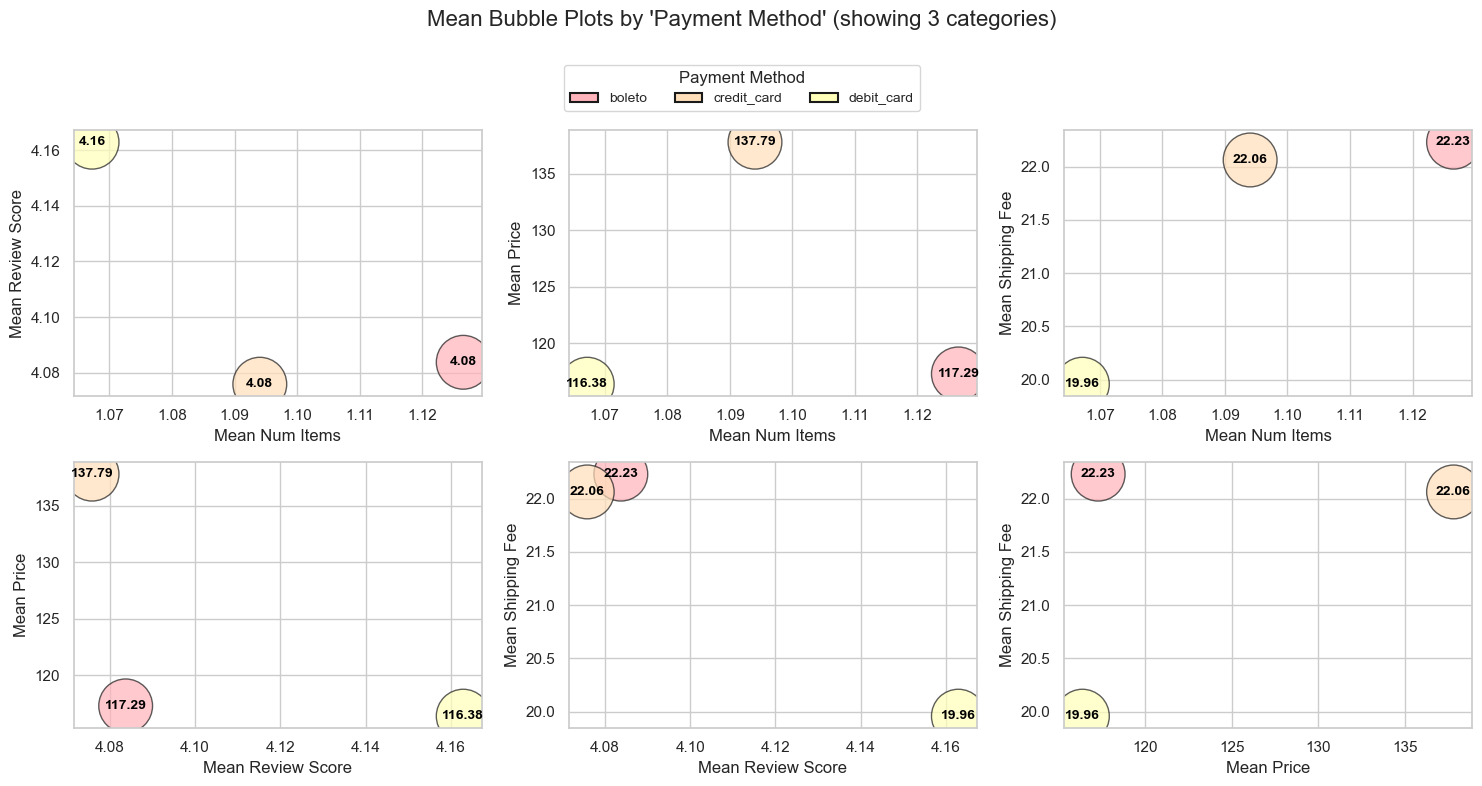

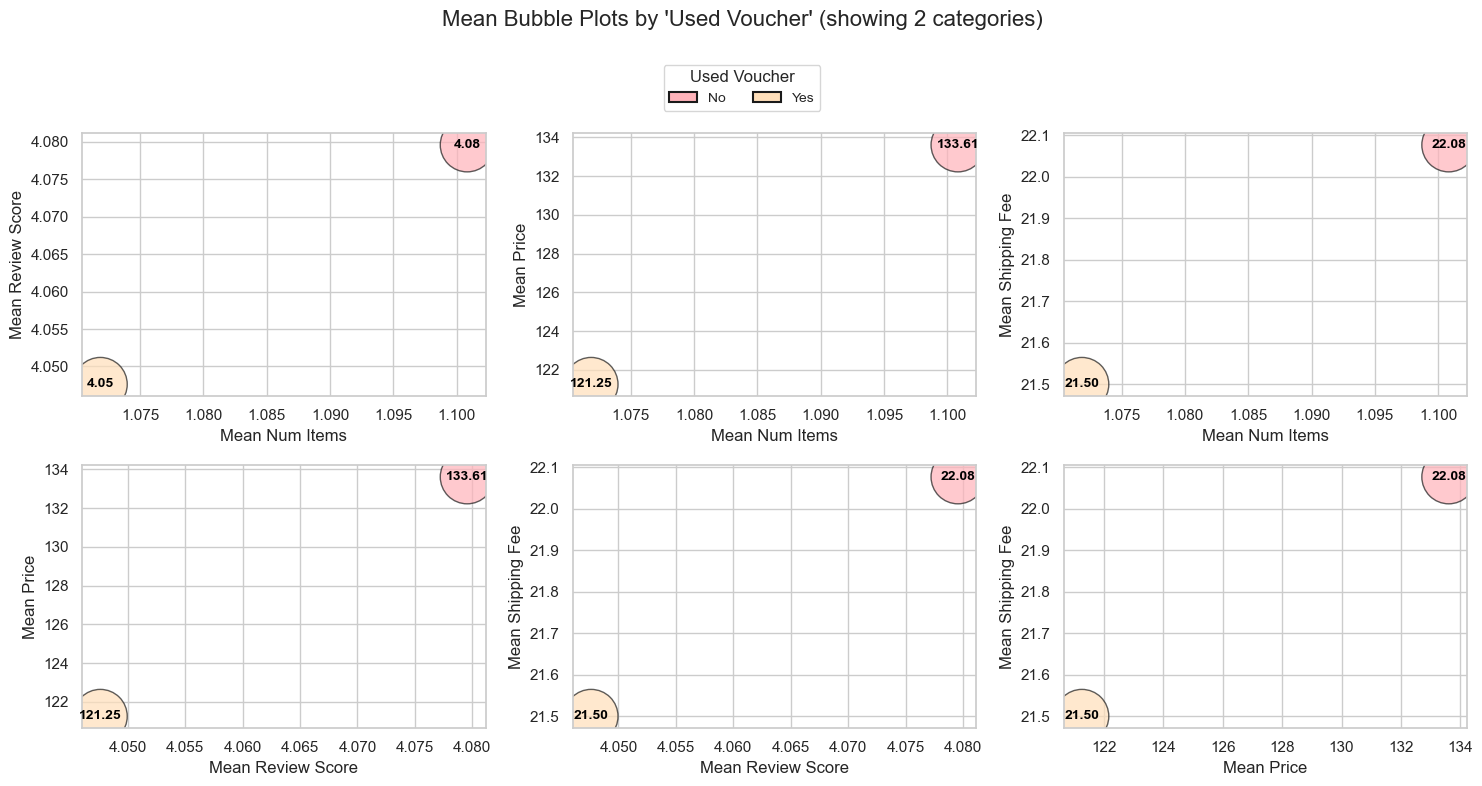

In [80]:
bubble_plots_by_category_mean(full_data, numerical_cols, categorical_cols)

**Key Insights Summary**

**Order Status**
- `created` and `unavailable` show outlier behavior due to near-zero price and shipping fee — likely invalid or incomplete orders.
- `processing` has the **highest price and shipping fee** but **lowest review score** → High cost does not guarantee satisfaction.
- `delivered` stands out with the **highest review score (4.13)** despite average costs.
- **Correlation**: Strong positive correlation between **Price** and **Shipping Fee** (r = 0.9578, p < 0.001).

---

**Customer City**
- Analysis focused on top 5 cities out of 4,108.
- `Pianco`: Highest price (2200.00), shipping fee, and perfect review score (5.0).
- `Nova Esperança do Piriá`: High price, low shipping fee, **lowest review score** (4.0).
- `Mariental`: Low price and shipping despite high review score → possibly low-value orders.
- **Correlation**: Review Score vs Shipping Fee (r = 0.66), not statistically significant.

---

**Customer State**
- Top 5 states: PB, AC, AP, AL, RO.
- `AP` has highest review score (4.16) and most items/order (1.16).
- `AL` is weakest performer with lowest review score (3.74).
- `PB` has highest price/shipping but only average satisfaction.
- **Correlation**:
  - Num Items vs Review Score: r = 0.8579
  - Price vs Shipping Fee: r = 0.5011
  - None statistically significant.

---

**Product Category**
- Top 5 categories: computers, small appliances, home appliances 2, agro industry, musical instruments.
- `Computers`: Highest price (1203.36), highest shipping fee (53.52), and strong overall performance.
- `Small appliances`: Highest review score (4.29), with moderate price/fee and low item count.
- `Musical instruments`: Lowest across most metrics.
- **Correlation**:
  - Num Items vs Review Score: r = -0.7104
  - Price vs Shipping Fee: r = 0.8510
  - All non-significant.

---

**Seller City**
- Top 5 cities: bofete, ivoti, california, paincandu, lages - sc.
- `bofete`: High price (3133.32) and good review score (4.67).
- `lages - sc`: Worst performance — lowest score (3.50), highest fee (252.80).
- **Correlation Highlights**:
  - Review Score vs Shipping Fee: **strong negative** (r = -0.8510)
  - Other correlations are weak and not significant.

---

**Seller State**
- Top 5 states: BA, PB, AM, RO, AC.
- `BA`: Best overall — highest score (4.11), item count, and price.
- `AC`: Worst — lowest score (1.00), price, and item count.
- **Correlation Highlights**:
  - Num Items vs Price: r = 0.7693
  - Review Score vs Price: r = 0.7726
  - Review Score vs Shipping Fee: r = 0.5622
  - None statistically significant.

---

**Payment Method**
- Best: `credit_card` — strong overall performance.
- Worst: `not_defined` — zero price/fee, very low review score (1.67).
- **Significant Correlations** (p < 0.05):
  - Review Score vs Price: r = 0.9840
  - Review Score vs Shipping Fee: r = 0.9917
  - Price vs Shipping Fee: r = 0.9903

---

**Used Voucher**
- `No` voucher users → Slightly higher values across all metrics (items, score, price, shipping).
- `Yes` voucher users → Slightly lower scores; differences are minimal.
- All correlations = 1.0000 (statistical artifact due to only 2 categories).
- Conclusion: Voucher usage has **no practical effect** on customer satisfaction or order value.

---

In [81]:
def plot_numerical_vs_release_date(df, numerical_cols, date_col='Purchase Time'):
    """
    Plot line charts showing the monthly average of numerical columns over time.
    This helps visualize trends and seasonality in user behavior or product performance.
    """

    # Copy & parse datetime column
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.dropna(subset=[date_col] + numerical_cols)
    
    # Set datetime index and resample by month
    df.set_index(date_col, inplace=True)
    monthly = df[numerical_cols].resample('M').mean().reset_index()
    
    # Set up subplot grid
    num_plots = len(numerical_cols)
    ncols = 2
    nrows = (num_plots + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(14, 5 * nrows))
    axes = axes.flatten()
    
    for ax, col in zip(axes, numerical_cols):
        # Line plot without confidence interval
        ax.plot(monthly[date_col], monthly[col], marker='o', linestyle='-')
        ax.set_title(f'{col} over Time')
        
        # Format x-axis with month-year
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        ax.grid(True, alpha=0.3)
    
    # Remove unused axes
    for ax in axes[len(numerical_cols):]:
        fig.delaxes(ax)
    
    fig.suptitle('Numerical Features vs. Purchase Time (Monthly Average)', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


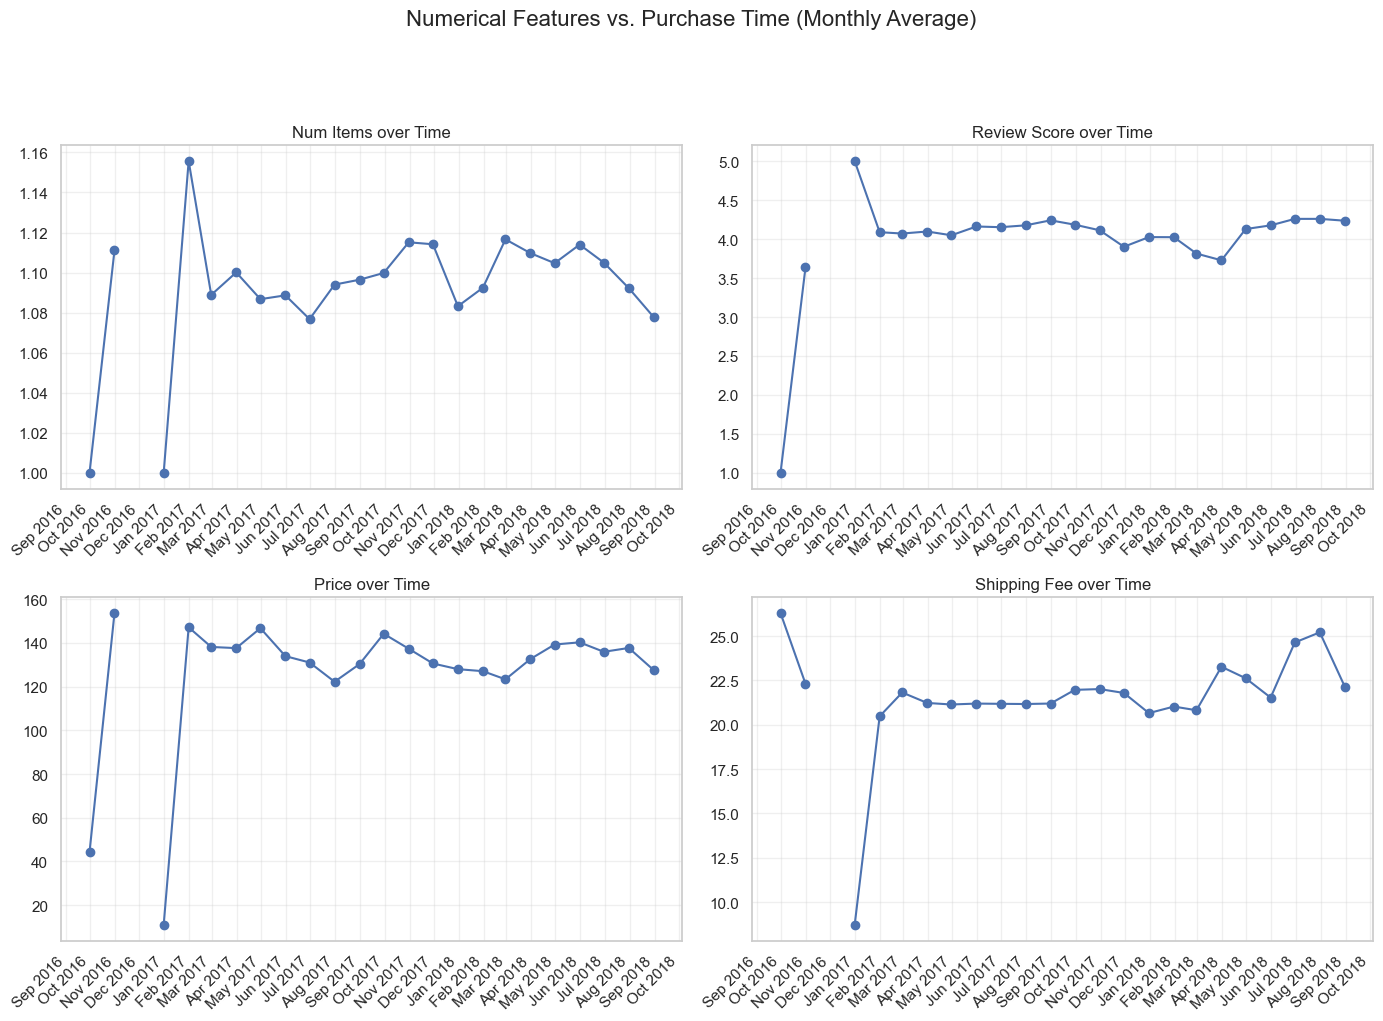

In [82]:
plot_numerical_vs_release_date(full_data, numerical_cols, date_col='Purchase Time')


**Time Series Analysis: Key Insights**

**1. Num Items over Time**
- The average number of items per order hovers around **1.1**, indicating that customers mostly purchase single-item orders.
- A noticeable **spike in March 2017** (~1.16 items) is followed by a stable trend.
- Significant fluctuations in the early months (2016) may be due to sparse or inconsistent data.

---

**2. Review Score over Time**
- Review scores are generally **high and stable** around **4.0** from 2017 onward.
- **Extreme values** in the early period (1.0 to 5.0) suggest unreliable data or low sample size.
- A **minor dip** in early 2018 is observed, potentially indicating a temporary drop in customer satisfaction.

---

**3. Price over Time**
- Order prices generally range between **125 and 145**, showing a relatively **consistent pricing pattern**.
- Some **anomalous low prices** appear before March 2017, likely due to data issues or early platform testing.
- Prices drop slightly in late 2017 but recover quickly, suggesting short-term promotions or product shifts.

---

**4. Shipping Fee over Time**
- Shipping fees remain mostly stable between **20 and 23** after early 2017.
- Prior to that, **lower and more volatile values** (as low as 10) are seen, possibly due to free shipping offers or missing data.
- A small upward trend in **mid-to-late 2018**, with some spikes near **25–26**, could reflect adjustments in shipping policies or cost structures.

---

**Overall Observations**
- Data from **before March 2017** appears **unstable or inconsistent** across all metrics and may require cleaning or exclusion for modeling purposes.
- From **2017 onward**, metrics show strong consistency:
  - Slight improvements in review score and number of items per order.
  - Stable pricing and shipping fee trends.
- **Important periods** such as March 2017 and mid-2018 could be explored further for potential business interventions (e.g., campaigns or platform changes).


## 5) Business findings from the EDA

**Business Insights Summary**

- **High Order Completion Rate (~97.9%)**  
  Most orders are delivered successfully, indicating strong fulfillment and logistics processes. However, the small “processing” segment incurs the highest costs and lowest review scores—this group merits a closer look to optimize both expense and customer experience.

- **Geographic Concentration**  
  Customers and sellers are heavily centered in São Paulo and the Southeast region (SP accounts for >40% of orders; SP sellers >70%). There is significant growth potential by expanding reach into under‑served states and cities.

- **Single‑Item Order Pattern**  
  Average order size is just 1.10 items, with ~93% of orders containing only one product. Introducing multi‑item bundles or cross‑sell promotions could increase average order value.

- **Product Category & Pricing Dynamics**  
  - High‑value categories (e.g., computers) drive both price and shipping cost.  
  - Lightweight or small items (e.g., children’s fashion) incur lower fees.  
  ⇒ Pricing and shipping strategies should be tailored by category to balance margin and customer satisfaction.

- **Payment Method Distribution**  
  Credit cards dominate (78%), followed by boleto (20%) and debit cards (1.6%). The small “not_defined” segment shows near‑zero revenue and poor review scores—investigate to clarify or eliminate this option.

- **Low Voucher Redemption Rate**  
  Only ~2.3% of orders use vouchers, with negligible differences in order value or satisfaction. Consider redesigning voucher campaigns (e.g., minimum spend thresholds, targeted offers) to boost uptake and impact.

- **Temporal Trends & Data Quality**  
  Data before March 2017 shows instability and may require cleaning. From 2017 onward, key metrics (items per order, price, shipping fee, review score) are stable, with notable peaks around March 2017 and mid‑2018—likely reflecting promotional events or policy changes.

---

**Recommendations:**  
1. **Optimize “Processing” Orders**: Analyze cost drivers and customer feedback to reduce expense and improve satisfaction.  
2. **Expand Geographical Footprint**: Target marketing and logistics partnerships in regions outside São Paulo to capture untapped demand.  
3. **Bundle & Upsell**: Develop multi‑item bundles or tiered promotions to increase average items per order.  
4. **Category‑Specific Pricing**: Implement dynamic shipping fees and pricing plans tailored to product weight/value profiles.  
5. **Refine Voucher Strategy**: Enhance voucher appeal through minimum purchase requirements, time‑limited offers, or personalized discounts.  


#  IV) Prepare the data

## 1) Transform to be done on each feature

**Feature Transformation Plan**

Below is a structured plan to transform and engineer features for modeling. It’s organized by feature type, with specific techniques and rationale.

| Feature                | Type         | Transformation                                              | Rationale / Notes                                 |
|------------------------|--------------|-------------------------------------------------------------|---------------------------------------------------|
| **Num Items**          | Numeric      | - Cap at 95th percentile (e.g. max=3)                       | Reduce influence of extreme bulk orders.          |
|                        |              | - Scale (RobustScaler)                                      | Handles outliers better than MinMax/Standard.     |
| **Review Score**       | Ordinal      | - Map 1–5 to [0–1]                                          | Preserve order; treat as continuous.              |
|                        |              | - Optionally bin (low:1–2, mid:3, high:4–5)                 | For tree-based models or imbalance correction.    |
| **Price**              | Numeric      | - Log1p transform                                           | Mitigate right skew.                              |
|                        |              | - Scale (StandardScaler)                                    | Standardize for distance-based models.            |
| **Shipping Fee**       | Numeric      | - Log1p transform                                           | Reduce skew from zero-fee and high outliers.      |
|                        |              | - Scale (RobustScaler)                                      | Robust to remaining extremes.                     |
| **Order Status**       | Categorical  | - Binary flag “Delivered” vs. “Not Delivered”               | Simplify target/outcome modeling.                 |
|                        |              | - One-hot encode remaining statuses (shipped, canceled…)    | Capture intermediate states if needed.            |
| **Customer State**     | Categorical  | - One-hot encode top 5 states by frequency                  | Capture main markets.                             |
|                        |              | - “Other” bucket for remaining states                       | Control dimensionality.                           |
| **Customer City**      | High-card.   | - Target-encode (mean target) or frequency-encode           | Avoid one-hot explosion.                          |
| **Seller State**       | Categorical  | - One-hot encode top 3 states                                | São Paulo, MG, PR.                                |
|                        |              | - “Other” bucket                                           |                                                   |
| **Seller City**        | High-card.   | - Frequency-encode                                        | Capture relative importance without too many dummies. |
| **Product Category**   | Categorical  | - One-hot encode top 10 categories                          | High-volume segments.                             |
|                        |              | - “Other” bucket                                           | Consolidate tail.                                 |
| **Payment Method**     | Categorical  | - One-hot encode (credit, boleto, debit)                    | Small number of levels.                           |
| **Used Voucher**       | Binary       | - Map “Yes”→1, “No”→0                                       | Ready for modeling.                               |
| **Day of Month**       | Temporal     | - Cyclical encode:  
  -  sin_day = sin(2π·day/31)  
  -  cos_day = cos(2π·day/31)                                 | Preserve circularity.                             |
| **Month**              | Temporal     | - Cyclical encode:  
  -  sin_month = sin(2π·month/12)  
  -  cos_month = cos(2π·month/12)                             | Capture seasonality.                              |
| **Year**               | Temporal     | - If all data in 2016–2018, map to ordinal [0,1,2] or drop | Low variance; may not add value.                  |

**Additional Engineered Features**
- **Price per Item:** `price / num_items` (after num_items > 0)  
  *Captures average unit price.*
- **Shipping Ratio:** `shipping_fee / price`  
  *Indicates relative shipping burden.*
- **High-Value Flag:** `price > p75` (75th percentile)  
  *Binary marker for premium orders.*
- **Weekend Indicator:** `is_weekend = month/day → weekday ∈ {Sat, Sun}`  
  *If day-of-week available via order date.*

---

> **Implementation Notes:**  
> 1. Fit encoders/scalers only on training data; apply to validation/test.  
> 2. Use cross-validation to evaluate impact of each transformation.  
> 3. Monitor feature importances to revisit rare-category grouping thresholds.  


## 3) Feature selection

### 3.1) Drop features

## 4) Feature engineering

In [92]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

# 1. Numeric Feature Transformers
class NumItemsTransformer(BaseEstimator, TransformerMixin):
    """
    Cap `Num Items` at the 95th percentile and apply RobustScaler.
    """
    def __init__(self):
        self.feature = 'Num Items'
        self.percentile = 95
        self.cap_value_ = None
        self.scaler_ = RobustScaler()

    def fit(self, X, y=None):
        self.cap_value_ = np.percentile(X[self.feature], self.percentile)
        capped_values = np.where(
            X[self.feature] > self.cap_value_, self.cap_value_, X[self.feature]
        )
        self.scaler_.fit(capped_values.reshape(-1, 1))
        return self

    def transform(self, X):
        X_copy = X.copy()
        # Cap values
        X_copy[self.feature] = np.where(
            X_copy[self.feature] > self.cap_value_, self.cap_value_, X_copy[self.feature]
        )
        # Scale values
        X_copy[self.feature] = self.scaler_.transform(X_copy[self.feature].values.reshape(-1, 1)).flatten()
        return X_copy

class PriceTransformer(BaseEstimator, TransformerMixin):
    """
    Apply log1p transform to `Price` and StandardScaler.
    """
    def __init__(self):
        self.feature = 'Price'
        self.scaler_ = StandardScaler()

    def fit(self, X, y=None):
        log_values = np.log1p(X[self.feature])
        self.scaler_.fit(log_values.values.reshape(-1, 1))
        return self

    def transform(self, X):
        X_copy = X.copy()
        # Log transform
        X_copy[self.feature] = np.log1p(X_copy[self.feature])
        # Scale values
        X_copy[self.feature] = self.scaler_.transform(X_copy[self.feature].values.reshape(-1, 1)).flatten()
        return X_copy

class ShippingFeeTransformer(BaseEstimator, TransformerMixin):
    """
    Apply log1p transform to `Shipping Fee` and RobustScaler.
    """
    def __init__(self):
        self.feature = 'Shipping Fee'
        self.scaler_ = RobustScaler()

    def fit(self, X, y=None):
        log_values = np.log1p(X[self.feature])
        self.scaler_.fit(log_values.values.reshape(-1, 1))
        return self

    def transform(self, X):
        X_copy = X.copy()
        # Log transform
        X_copy[self.feature] = np.log1p(X_copy[self.feature])
        # Scale values
        X_copy[self.feature] = self.scaler_.transform(X_copy[self.feature].values.reshape(-1, 1)).flatten()
        return X_copy

# 2. Ordinal Feature Transformers
class ReviewScoreTransformer(BaseEstimator, TransformerMixin):
    """
    Map review scores from [1-5] to [0-1].
    Optionally bin into low (1-2), mid (3), high (4-5).
    """
    def __init__(self, bin_scores=False):
        self.feature = 'Review Score'
        self.bin_scores = bin_scores

    def fit(self, X, y=None): 
        return self

    def transform(self, X):
        X_copy = X.copy()
        if self.bin_scores:
            # Create binned version (low:1-2, mid:3, high:4-5)
            bins = {1: 'low', 2: 'low', 3: 'mid', 4: 'high', 5: 'high'}
            X_copy[f'{self.feature}_bin'] = X_copy[self.feature].map(bins)
        else:
            # Map 1-5 to 0-1 range
            X_copy[self.feature] = (X_copy[self.feature] - 1) / 4
        return X_copy

# 3. Categorical Feature Transformers
class OrderStatusTransformer(BaseEstimator, TransformerMixin):
    """
    Binary flag for "Delivered" vs "Not Delivered" and one-hot encode all statuses.
    """
    def __init__(self):
        self.feature = 'Order Status'
        self.encoder_ = None
        self.categories_ = None

    def fit(self, X, y=None):
        self.encoder_ = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        self.encoder_.fit(X[self.feature].values.reshape(-1, 1))
        self.categories_ = self.encoder_.categories_[0]
        return self

    def transform(self, X):
        X_copy = X.copy()
        # Binary delivery flag
        X_copy['is_delivered'] = (X_copy[self.feature] == 'delivered').astype(int)
        
        # One-hot encode all statuses
        oh = self.encoder_.transform(X_copy[self.feature].values.reshape(-1, 1))
        
        # Add encoded columns directly to the dataframe
        for i, category in enumerate(self.categories_):
            X_copy[f"{self.feature}_{category}"] = oh[:, i]
        
        return X_copy

class CustomerStateTransformer(BaseEstimator, TransformerMixin):
    """
    One-hot encode top 5 frequent states and group others into 'Other'.
    """
    def __init__(self):
        self.feature = 'Customer State'
        self.top_k = 5
        self.top_states_ = None
        self.encoder_ = None
        self.categories_ = None

    def fit(self, X, y=None):
        self.top_states_ = X[self.feature].value_counts().nlargest(self.top_k).index.tolist()
        categories = self.top_states_ + ['Other']
        
        # Create a temporary series for fitting
        temp_series = X[self.feature].fillna('Other').copy()
        temp_series.loc[~temp_series.isin(self.top_states_)] = 'Other'
        
        self.encoder_ = OneHotEncoder(categories=[categories], handle_unknown='ignore', sparse_output=False)
        self.encoder_.fit(temp_series.values.reshape(-1, 1))
        self.categories_ = categories
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        # Create a temporary series for transformation
        temp_series = X_copy[self.feature].fillna('Other').copy()
        temp_series.loc[~temp_series.isin(self.top_states_)] = 'Other'
        
        # Get one-hot encoded values
        oh = self.encoder_.transform(temp_series.values.reshape(-1, 1))
        
        # Add encoded columns directly to the dataframe
        for i, category in enumerate(self.categories_):
            X_copy[f"{self.feature}_{category}"] = oh[:, i]
        
        return X_copy

class CustomerCityTransformer(BaseEstimator, TransformerMixin):
    """
    Frequency encode high-cardinality city feature.
    """
    def __init__(self):
        self.feature = 'Customer City'
        self.freq_map_ = None

    def fit(self, X, y=None):
        self.freq_map_ = X[self.feature].value_counts(normalize=True)
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[f'{self.feature}_freq'] = X_copy[self.feature].map(self.freq_map_).fillna(0)
        return X_copy

class SellerStateTransformer(BaseEstimator, TransformerMixin):
    """
    One-hot encode top 3 seller states (São Paulo, MG, PR) and group others.
    """
    def __init__(self):
        self.feature = 'Seller State'
        self.top_k = 3
        self.top_states_ = None
        self.encoder_ = None
        self.categories_ = None

    def fit(self, X, y=None):
        self.top_states_ = X[self.feature].value_counts().nlargest(self.top_k).index.tolist()
        categories = self.top_states_ + ['Other']
        
        # Create a temporary series for fitting
        temp_series = X[self.feature].fillna('Other').copy()
        temp_series.loc[~temp_series.isin(self.top_states_)] = 'Other'
        
        self.encoder_ = OneHotEncoder(categories=[categories], handle_unknown='ignore', sparse_output=False)
        self.encoder_.fit(temp_series.values.reshape(-1, 1))
        self.categories_ = categories
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        # Create a temporary series for transformation
        temp_series = X_copy[self.feature].fillna('Other').copy()
        temp_series.loc[~temp_series.isin(self.top_states_)] = 'Other'
        
        # Get one-hot encoded values
        oh = self.encoder_.transform(temp_series.values.reshape(-1, 1))
        
        # Add encoded columns directly to the dataframe
        for i, category in enumerate(self.categories_):
            X_copy[f"{self.feature}_{category}"] = oh[:, i]
        
        return X_copy

class SellerCityTransformer(BaseEstimator, TransformerMixin):
    """
    Frequency encode high-cardinality seller city feature.
    """
    def __init__(self):
        self.feature = 'Seller City'
        self.freq_map_ = None

    def fit(self, X, y=None):
        self.freq_map_ = X[self.feature].value_counts(normalize=True)
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[f'{self.feature}_freq'] = X_copy[self.feature].map(self.freq_map_).fillna(0)
        return X_copy

class ProductCategoryTransformer(BaseEstimator, TransformerMixin):
    """
    One-hot encode top 10 product categories and group others into 'Other'.
    """
    def __init__(self):
        self.feature = 'Product Category'
        self.top_k = 10
        self.top_categories_ = None
        self.encoder_ = None
        self.categories_ = None

    def fit(self, X, y=None):
        self.top_categories_ = X[self.feature].value_counts().nlargest(self.top_k).index.tolist()
        categories = self.top_categories_ + ['Other']
        
        # Create a temporary series for fitting
        temp_series = X[self.feature].fillna('Other').copy()
        temp_series.loc[~temp_series.isin(self.top_categories_)] = 'Other'
        
        self.encoder_ = OneHotEncoder(categories=[categories], handle_unknown='ignore', sparse_output=False)
        self.encoder_.fit(temp_series.values.reshape(-1, 1))
        self.categories_ = categories
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        # Create a temporary series for transformation
        temp_series = X_copy[self.feature].fillna('Other').copy()
        temp_series.loc[~temp_series.isin(self.top_categories_)] = 'Other'
        
        # Get one-hot encoded values
        oh = self.encoder_.transform(temp_series.values.reshape(-1, 1))
        
        # Add encoded columns directly to the dataframe
        for i, category in enumerate(self.categories_):
            X_copy[f"{self.feature}_{category}"] = oh[:, i]
        
        return X_copy

class PaymentMethodTransformer(BaseEstimator, TransformerMixin):
    """
    One-hot encode payment methods (credit, boleto, debit).
    """
    def __init__(self):
        self.feature = 'Payment Method'
        self.encoder_ = None
        self.categories_ = None

    def fit(self, X, y=None):
        self.encoder_ = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        self.encoder_.fit(X[self.feature].values.reshape(-1, 1))
        self.categories_ = self.encoder_.categories_[0]
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        # Get one-hot encoded values
        oh = self.encoder_.transform(X_copy[self.feature].values.reshape(-1, 1))
        
        # Add encoded columns directly to the dataframe
        for i, category in enumerate(self.categories_):
            X_copy[f"{self.feature}_{category}"] = oh[:, i]
        
        return X_copy

class UsedVoucherTransformer(BaseEstimator, TransformerMixin):
    """
    Map "Yes" -> 1, "No" -> 0 for Used Voucher.
    """
    def __init__(self):
        self.feature = 'Used Voucher'

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.feature] = (X_copy[self.feature] == 'Yes').astype(int)
        return X_copy

# 4. Feature Engineering Transformers
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    """
    Add engineered features:
    - price_per_item: Price / Num Items
    - shipping_ratio: Shipping Fee / Price
    - high_value_flag: Price > 75th percentile
    """
    def __init__(self):
        self.price_75th_ = None

    def fit(self, X, y=None):
        self.price_75th_ = np.percentile(X['Price'], 75)
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        # Price per item
        X_copy['price_per_item'] = X_copy['Price'] / X_copy['Num Items'].replace(0, np.nan)
        
        # Shipping ratio
        X_copy['shipping_ratio'] = X_copy['Shipping Fee'] / X_copy['Price'].replace(0, np.nan)
        
        # High value flag
        X_copy['high_value_flag'] = (X_copy['Price'] > self.price_75th_).astype(int)
        
        # Fill NaNs
        X_copy = X_copy.fillna(0)
        
        return X_copy

# 5. Temporal Feature Transformers
class TemporalFeatureTransformer(BaseEstimator, TransformerMixin):
    """
    Extract and encode temporal features:
    - Cyclical encoding for day and month
    - Weekend indicator
    - Year ordinal encoding
    """
    def __init__(self):
        self.date_col = 'Purchase Time'
        self.year_mapping_ = None

    def fit(self, X, y=None):
        dates = pd.to_datetime(X[self.date_col], errors='coerce')
        years = dates.dt.year.dropna().unique()
        self.year_mapping_ = {year: idx for idx, year in enumerate(sorted(years))}
        return self

    def transform(self, X):
        X_copy = X.copy()
        dates = pd.to_datetime(X_copy[self.date_col], errors='coerce')
        
        # Extract basic components
        X_copy['Day'] = dates.dt.day
        X_copy['Month'] = dates.dt.month
        X_copy['Year'] = dates.dt.year
        
        # Cyclical encoding for day
        X_copy['Day_sin'] = np.sin(2 * np.pi * X_copy['Day'] / 31)
        X_copy['Day_cos'] = np.cos(2 * np.pi * X_copy['Day'] / 31)
        
        # Cyclical encoding for month
        X_copy['Month_sin'] = np.sin(2 * np.pi * X_copy['Month'] / 12)
        X_copy['Month_cos'] = np.cos(2 * np.pi * X_copy['Month'] / 12)
        
        # Weekend indicator
        X_copy['is_weekend'] = dates.dt.weekday.isin([5, 6]).astype(int)
        
        # Year ordinal encoding
        X_copy['Year_ord'] = X_copy['Year'].map(self.year_mapping_).fillna(-1)
        
        return X_copy

# 6. Feature Remover
class FeatureRemover(BaseEstimator, TransformerMixin):
    """
    Drop specified identifier columns not needed for modeling.
    """
    def __init__(self):
        self.features_to_drop = [
            'Order ID', 'Customer ID', 'Customer Unique ID', 
            'Product ID', 'Seller ID', 'Purchase Time'
        ]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        missing = set(self.features_to_drop) - set(X_copy.columns)
        if missing:
            print(f"Warning: features not found for drop: {missing}")
        return X_copy.drop(columns=[f for f in self.features_to_drop if f in X_copy.columns], errors='ignore')


## 5) Data Preprocessing

In [94]:
# Create a complete feature transformation pipeline
def create_feature_pipeline():
    """
    Create a full preprocessing pipeline for all features.
    """
    return Pipeline([
        # Numeric transformers
        ('num_items', NumItemsTransformer()),
        ('price', PriceTransformer()),
        ('shipping_fee', ShippingFeeTransformer()),
        
        # Ordinal transformers
        ('review_score', ReviewScoreTransformer(bin_scores=True)),
        
        # Categorical transformers
        ('order_status', OrderStatusTransformer()),
        ('customer_state', CustomerStateTransformer()),
        ('customer_city', CustomerCityTransformer()),
        ('seller_state', SellerStateTransformer()),
        ('seller_city', SellerCityTransformer()),
        ('product_category', ProductCategoryTransformer()),
        ('payment_method', PaymentMethodTransformer()),
        ('used_voucher', UsedVoucherTransformer()),
        
        # Feature engineering
        ('engineered_features', FeatureEngineeringTransformer()),
        
        # Temporal features
        ('temporal_features', TemporalFeatureTransformer()),
        
        # Remove identifier columns
        ('feature_remover', FeatureRemover())
    ])

# Example code to verify row count stays the same throughout pipeline
def verify_row_count(X):
    """
    Verify that the number of rows stays the same through each transformer.
    """
    pipeline = create_feature_pipeline()
    original_row_count = X.shape[0]
    print(f"Original row count: {original_row_count}")
    
    # Check each step in the pipeline
    temp_X = X.copy()
    for name, transformer in pipeline.steps:
        transformer.fit(temp_X)
        temp_X = transformer.transform(temp_X)
        current_row_count = temp_X.shape[0]
        print(f"After {name}: {current_row_count} rows")
        assert original_row_count == current_row_count, f"Row count changed at step {name}!"
    
    return "All steps maintain the same row count."

# Usage example
# pipeline = create_feature_pipeline()
# X_transformed = pipeline.fit_transform(X_train)
# verify_row_count(X_train)  # Verify row count doesn't change

# VII) Customer Segmentation

## 1) Data Preprocessing

In [97]:
pipeline = create_feature_pipeline()
train_data_seg = pipeline.fit_transform(full_data)
verify_row_count(full_data)

Original row count: 98834
After num_items: 98834 rows
After price: 98834 rows
After shipping_fee: 98834 rows
After review_score: 98834 rows
After order_status: 98834 rows
After customer_state: 98834 rows
After customer_city: 98834 rows
After seller_state: 98834 rows
After seller_city: 98834 rows
After product_category: 98834 rows
After payment_method: 98834 rows
After used_voucher: 98834 rows
After engineered_features: 98834 rows
After temporal_features: 98834 rows
After feature_remover: 98834 rows


'All steps maintain the same row count.'

In [98]:
train_data_seg = train_data_seg.drop(columns=['Purchase Time'], errors='ignore')

train_data_seg = train_data_seg.drop(columns=train_data_seg.select_dtypes(include='object').columns)

In [99]:
train_data_seg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98834 entries, 0 to 101760
Data columns (total 51 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Num Items                               98834 non-null  float64
 1   Price                                   98834 non-null  float64
 2   Shipping Fee                            98834 non-null  float64
 3   Used Voucher                            98834 non-null  int32  
 4   Review Score                            98834 non-null  float64
 5   Day                                     98834 non-null  int32  
 6   Month                                   98834 non-null  int32  
 7   Year                                    98834 non-null  int32  
 8   is_delivered                            98834 non-null  int32  
 9   Order Status_approved                   98834 non-null  float64
 10  Order Status_canceled                   98834 non-null  float6

## 2) K-Means Clustering

In [101]:
X = np.asarray(train_data_seg)

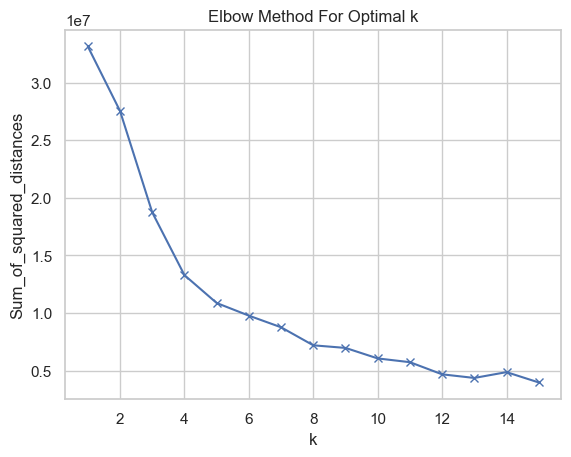

In [102]:
Sum_of_squared_distances = []
K = range(1,16)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [103]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    """
    Applies KMeans clustering on the normalized RFM dataset.
    Adds cluster labels to the original RFM data and visualizes clusters using t-SNE.
    Returns the original DataFrame with an added 'Cluster' column.
    """
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new


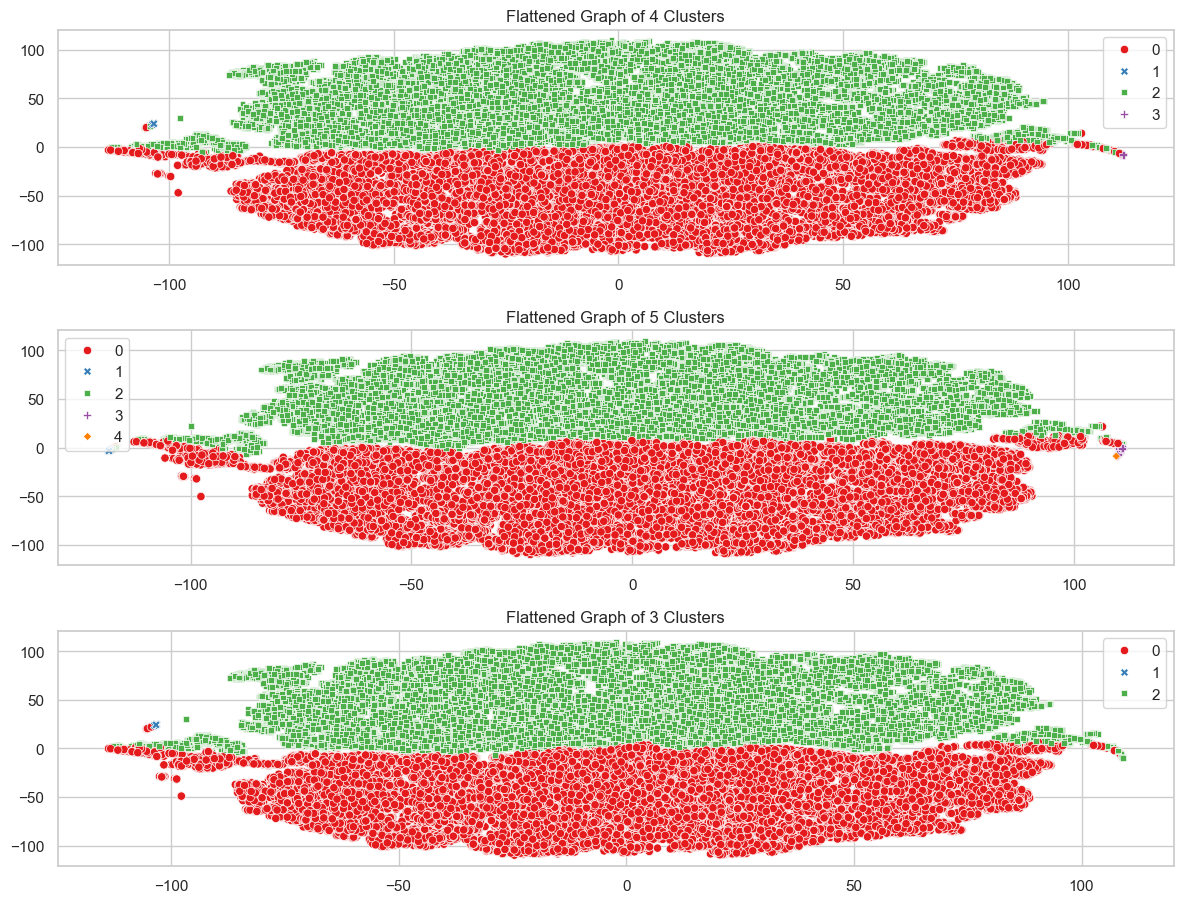

In [104]:
plt.figure(figsize=(12, 12))

# Subplot 2: K = 3
plt.subplot(4, 1, 4)
df_rfm_k3 = kmeans(train_data_seg, 3, train_data_seg)

# Subplot 3: K = 4
plt.subplot(4, 1, 2)
df_rfm_k4 = kmeans(train_data_seg, 4, train_data_seg)

# Subplot 4: K = 5
plt.subplot(4, 1, 3)
df_rfm_k5 = kmeans(train_data_seg, 5, train_data_seg)

plt.tight_layout()

## 3) Evaluating Model

In [106]:
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    score = davies_bouldin_score(X, kmeans.labels_)
    print(f'k = {k}, Davies-Bouldin Score = {score:.4f}')


k = 2, Davies-Bouldin Score = 0.3252
k = 3, Davies-Bouldin Score = 0.7682
k = 4, Davies-Bouldin Score = 0.6614
k = 5, Davies-Bouldin Score = 0.6441


**Clustering Evaluation using Davies-Bouldin Score**

| Number of Clusters (k) | Davies-Bouldin Score |
|------------------------|----------------------|
| 3                      | 0.7682               |
| 4                      | 0.6614               |
| 5                      | **0.6441**           |

**Analysis:**
- The **Davies-Bouldin Score (DBS)** measures cluster quality — **lower scores indicate better, more distinct clusters**.
- Among the tested values, **k = 5** yields the lowest DBS (**0.6441**), indicating the best clustering performance.
- From **k = 3 to k = 6**, the DBS increases, suggesting that clusters become less distinct and more overlapping.

**Conclusion:**  
**k = 5** appears to be the most appropriate number of clusters based on the Davies-Bouldin Score.

> **Tip:** Consider combining this with other metrics such as Silhouette Score or visualizing the clusters for more robust evaluation.


# VIII) Save final dataset

In [109]:
df = df_result.copy()
df = df.dropna()
df.loc[df_rfm_k5.index, 'Cluster'] = df_rfm_k5['Cluster']
df['Cluster'] = df['Cluster'].astype('int32')
df.head()

Order ID       Purchase Time Order Status  \
0  50ba38c4dc467baab1ea2c8c7747934d 2018-03-02 21:32:44    delivered   
1  d99e6849f7676dade195f20c26f0eb4f 2017-09-02 22:37:17    delivered   
2  0a9a43ac5fe59c6c4bee2a8f9b9fcce8 2018-07-02 08:00:35    delivered   
3  3f1294f87d79b57f5d55ba7b80c3d94f 2018-01-28 14:21:58    delivered   
4  5525ea8ee9e6150faa9b41dfc4024552 2018-08-20 21:33:48    delivered   

                        Customer ID                Customer Unique ID  \
0  9e01f714a2b3b8962c222cf2b74c20dc  e1feae9083c4c2895ddf6dc80526a85d   
1  a23e3f9a2b656b23b7e52075964b42cd  afddf43a03a9941624ed42c0b2c17280   
2  f11eb8f0b8b87510a93e3e1aa10b0ade  64ee476500a01beb94df40f97a108c50   
3  576d71ddb21b21763cfedce73b902180  8d76b559181609308fcae630ea64cd61   
4  08528824266cd0720658ff01df662b6a  8f7f547488a05660770b51be707eb2a3   

         Customer City Customer State                        Product ID  \
0  abadia dos dourados             MG  418d480693f2f01e9cf4568db0346d28   
1  abadia dos dourados             MG  1081ae52311daac87fb54ba8ce4670ac   
2  abadia dos dourados             MG  c1aabbb6f4caec9f5bf7cd80519d6cc0   
3            abadiania             GO  0a9b9a871ffaec6c0198334558a6c6a1   
4               abaete             MG  3354a4e684f5e7199f9407db70ccd92b   

         Product Category  Num Items   Price  Shipping Fee  \
0              cool_stuff          1  199.00         20.63   
1          sports_leisure          1  120.00         15.59   
2  books_general_interest          1   39.90         18.38   
3        small_appliances          1  949.99         75.53   
4              cool_stuff          1   85.99         23.40   

                          Seller ID     Seller City Seller State  \
0  12b9676b00f60f3b700e83af21824c0e      montenegro           RS   
1  4371b634e0efc0e22b09b52907d9d469       sao paulo           SP   
2  579891617139df7d8671d373f0669622  rio de janeiro           RJ   
3  f9244d45189d3a3605499abddeade7d5       sao paulo           SP   
4  7a67c85e85bb2ce8582c35f2203ad736       sao paulo           SP   

  Payment Method Used Voucher  Review Score  Cluster  
0    credit_card           No           5.0        0  
1    credit_card           No           5.0        0  
2         boleto           No           5.0        0  
3    credit_card           No           4.0        2  
4    credit_card           No           5.0        2

In [ ]:
df.to_csv('segment_dataset.csv', index = False)